# Relative Positional Encoding Shaw et al 2018

https://arxiv.org/abs/1803.02155

Unclear from paper but from [tensor2tensor implementation](https://github.com/tensorflow/tensor2tensor/blob/9e0a894034d8090892c238df1bd9bd3180c2b9a3/tensor2tensor/layers/common_attention.py#L1644): same embeddings are shared across all layers

While the paper implemented the Vaswani et al 2017 encoder-decoder architecture, here we'll just do a very small GPT-style decoder stack since these are easier to train and we have previous training curves for these

In [303]:
import numpy as np
import torch.nn as nn
import torch
import importlib
import pickle
from functools import partial
import matplotlib.pyplot as plt

from src import relative_attention as rpe
from src import torch_models as tm
from src import data
from src import train_utils
from src import utils

In [171]:
def reload_modules():
    importlib.reload(tm)
    importlib.reload(rpe)
    importlib.reload(data)
    importlib.reload(train_utils)
    importlib.reload(utils)

## BBPE

In [2]:
train_path_en = 'data/train.en'
train_path_de = 'data/train.de'
tokenizer_path = "data/tokenizer-bbpe-joint.json"

In [3]:
bbpe = data.get_bbpe_tokenizer(tokenizer_path, data_file_list=[train_path_en, train_path_de])

## model def

In [255]:
reload_modules()
max_context = 64
max_distance = 32
base_model_config = tm.ModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    position_encoding_class=tm.LearnablePositionalEncoding,
)
model_base = tm.Autoregressive.from_config(base_model_config)

krpe_config = rpe.RPEModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    relative=True,
    per_layer=True,
    use_value_rpe=False,
    max_distance=max_distance,
)
model_krpe_perlayer = rpe.RelativeGPT.from_config(krpe_config)

kv_rpe_config = rpe.RPEModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    relative=True,
    per_layer=True,
    use_value_rpe=True,
    max_distance=max_distance,
)

model_kvrpe_perlayer = rpe.RelativeGPT.from_config(kv_rpe_config)

In [256]:
k_rpe_global_config = rpe.RPEModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    relative=True,
    per_layer=False,
    use_value_rpe=False,
    max_distance=max_distance,
)

model_krpe_global = rpe.RelativeGPT.from_config(k_rpe_global_config)

In [257]:
reload_modules()
k_pe_perlayer_config = rpe.RPEModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    relative=False,
    per_layer=True,
    use_value_rpe=False,
    max_distance=max_distance,
)

model_pe_perlayer= rpe.RelativeGPT.from_config(k_pe_perlayer_config)
model_base = tm.Autoregressive.from_config(base_model_config)

In [248]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def print_numel(model, name):
    print(f'{name:>30}: {count_params(model):,}')

Note that the per-layer PE model uses a smaller context and coincidentally ends up with the same number of params as the base model 

In [258]:
print_numel(model_base, 'base')
print_numel(model_pe_perlayer, 'per-layer PE')
print_numel(model_krpe_global, 'key-only global RPE')
print_numel(model_krpe_perlayer, 'key-only per-layer RPE')
print_numel(model_kvrpe_perlayer, 'key-value per-layer RPE')

                          base: 55,992,627
                  per-layer PE: 56,222,003
           key-only global RPE: 55,964,019
        key-only per-layer RPE: 55,993,139
       key-value per-layer RPE: 56,026,419


## Data Pipelines

In [250]:
if 'train_lines' not in locals():
    train_lines = sum(1 for line in open(data.TRAIN_PATH_EN, encoding='utf-8'))
if 'test_lines' not in locals():
    test_lines = sum(1 for line in open(data.TEST_PATH_EN, encoding='utf-8'))
print(f'train lines: {train_lines}')
print(f'test lines: {test_lines}')

train lines: 4468840
test lines: 2737


### training/ data params

docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [251]:
importlib.reload(data)
dataset_config = data.DatasetConfig(bbpe, max_context)
tok_fn = partial(data.str_to_tok, add_start=False)
tok_fn_w_start = partial(data.str_to_tok, add_start=True)

def input_fn(en_line, de_line, data_config):
    en_input = data.str_to_tok(en_line, data_config, add_start=True)
    return [en_input]

def target_fn(en_line, de_line, data_config):
    return data.str_to_tok(en_line, data_config, add_start=False)


In [252]:
# autoregressive training
importlib.reload(data)

batch_size = 64

train_dataset_autoreg = data.WMT2014Mixing(
    num_pools=7919,  # pick a prime number
    start_line=0,
    end_line=train_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=True,
    overwrite_de_path=data.TRAIN_PATH_EN,
)
train_loader_autoreg = torch.utils.data.DataLoader(
    train_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

test_dataset_autoreg = data.WMT2014Mixing(
    num_pools=101,  # pick a prime number
    start_line=0,
    end_line=test_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=False,
    overwrite_de_path=data.TEST_PATH_EN,
)
test_loader_autoreg = torch.utils.data.DataLoader(
    test_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

## Training

In [253]:
#loss_histories = dict()
with open('./saved_models/loss_histories.pickle', 'rb') as f:
    loss_histories = pickle.load(f)
with open('./saved_models/loss_histories_bkup.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)
loss_histories.keys()

dict_keys(['mingpt_n2_h8_d512_c64', 'autoreg_n2_h8_d512_c64_wproj_xavier', 'autoreg_n2_h8_d512_c64_wproj_mingptinit', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'res_n8_h8_d256_c64_wproj_mingptinit_learnablepe_shuffle', 'rpe_konly_n8_h8_d512_c64', 'rpe_konly_perlayer_n8_h8_d512_c64', 'autoreg_n8_h8_d512_c64', 'rpe_kv_perlayer_n8_h8_d512_c64', 'rpe_konly_global_n8_h8_d512_c64'])

In [97]:
key_base = 'autoreg_n8_h8_d512_c64'
model = model_base

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key_base,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:57<39:22:28,  2.03s/it]

       10048: training loss 5.8661723136901855, test loss 5.873531097589537


  0%|          | 313/69826 [01:52<40:17:03,  2.09s/it]

       20032: training loss 4.9752326011657715, test loss 5.204001326893652


  1%|          | 469/69826 [02:47<39:20:14,  2.04s/it]

       30016: training loss 4.486691951751709, test loss 4.956349683362384


  1%|          | 625/69826 [03:43<39:36:37,  2.06s/it]

       40000: training loss 4.42121696472168, test loss 4.810094190198321


  1%|          | 782/69826 [04:39<39:20:33,  2.05s/it]

       50048: training loss 4.4884161949157715, test loss 4.714888916459194


  1%|▏         | 938/69826 [05:34<40:12:11,  2.10s/it]

       60032: training loss 4.159120559692383, test loss 4.637413623721101


  2%|▏         | 1094/69826 [06:30<39:01:43,  2.04s/it]

       70016: training loss 4.173267364501953, test loss 4.574435145355935


  2%|▏         | 1250/69826 [07:25<39:48:45,  2.09s/it]

       80000: training loss 4.10932731628418, test loss 4.524564410364905


  2%|▏         | 1407/69826 [08:21<38:59:03,  2.05s/it]

       90048: training loss 4.030656814575195, test loss 4.462795423906903


  2%|▏         | 1563/69826 [09:18<42:37:34,  2.25s/it]

      100032: training loss 4.296462059020996, test loss 4.40951327390449


  2%|▏         | 1719/69826 [10:13<39:36:39,  2.09s/it]

      110016: training loss 3.942486524581909, test loss 4.383649304855702


  3%|▎         | 1875/69826 [11:09<38:48:40,  2.06s/it]

      120000: training loss 4.079443454742432, test loss 4.355281330818354


  3%|▎         | 2032/69826 [12:05<39:08:57,  2.08s/it]

      130048: training loss 3.89398455619812, test loss 4.305520700853925


  3%|▎         | 2188/69826 [13:01<39:16:49,  2.09s/it]

      140032: training loss 3.6933271884918213, test loss 4.298813686814419


  3%|▎         | 2344/69826 [13:57<39:11:48,  2.09s/it]

      150016: training loss 3.6511688232421875, test loss 4.25591224847838


  4%|▎         | 2500/69826 [14:53<39:07:24,  2.09s/it]

      160000: training loss 3.7067935466766357, test loss 4.233241813127385


  4%|▍         | 2657/69826 [15:48<38:29:24,  2.06s/it]

      170048: training loss 3.939575433731079, test loss 4.192556902419689


  4%|▍         | 2813/69826 [16:45<44:26:00,  2.39s/it]

      180032: training loss 4.000027656555176, test loss 4.169360127559928


  4%|▍         | 2969/69826 [17:41<39:09:03,  2.11s/it]

      190016: training loss 3.756578207015991, test loss 4.163900918738786


  4%|▍         | 3125/69826 [18:37<40:57:10,  2.21s/it]

      200000: training loss 3.6865456104278564, test loss 4.144940559254136


  5%|▍         | 3282/69826 [19:33<38:30:26,  2.08s/it]

      210048: training loss 3.6881017684936523, test loss 4.109688426173011


  5%|▍         | 3438/69826 [20:29<37:53:37,  2.05s/it]

      220032: training loss 3.6680829524993896, test loss 4.0905574865119405


  5%|▌         | 3594/69826 [21:24<38:39:40,  2.10s/it]

      230016: training loss 3.649021625518799, test loss 4.101153251736663


  5%|▌         | 3750/69826 [22:20<37:53:12,  2.06s/it]

      240000: training loss 3.7251148223876953, test loss 4.0737267205881516


  6%|▌         | 3907/69826 [23:16<38:32:55,  2.11s/it]

      250048: training loss 3.5929861068725586, test loss 4.070974649384964


  6%|▌         | 4063/69826 [24:16<42:43:40,  2.34s/it]

      260032: training loss 3.4543983936309814, test loss 4.054683136385541


  6%|▌         | 4219/69826 [25:18<42:56:10,  2.36s/it]

      270016: training loss 3.580904483795166, test loss 4.035017041272895


  6%|▋         | 4375/69826 [26:19<42:59:02,  2.36s/it]

      280000: training loss 3.622138738632202, test loss 4.014338066411573


  6%|▋         | 4532/69826 [27:21<43:48:48,  2.42s/it]

      290048: training loss 3.568835973739624, test loss 4.01197635850241


  7%|▋         | 4688/69826 [28:23<46:12:40,  2.55s/it]

      300032: training loss 3.470397710800171, test loss 4.000323578368786


  7%|▋         | 4844/69826 [29:24<43:43:43,  2.42s/it]

      310016: training loss 3.4879395961761475, test loss 3.991780452950056


  7%|▋         | 5000/69826 [30:25<44:01:30,  2.44s/it]

      320000: training loss 3.440781354904175, test loss 3.9670896363812824


  7%|▋         | 5157/69826 [31:27<41:46:37,  2.33s/it]

      330048: training loss 3.359232187271118, test loss 3.9740119423977163


  8%|▊         | 5313/69826 [32:27<41:34:26,  2.32s/it]

      340032: training loss 3.4146728515625, test loss 3.9611269318780233


  8%|▊         | 5469/69826 [33:28<41:14:43,  2.31s/it]

      350016: training loss 3.373244047164917, test loss 3.944220005079757


  8%|▊         | 5625/69826 [34:29<42:31:07,  2.38s/it]

      360000: training loss 3.420297145843506, test loss 3.940975932187812


  8%|▊         | 5782/69826 [35:30<41:04:58,  2.31s/it]

      370048: training loss 3.5163986682891846, test loss 3.943082238352576


  9%|▊         | 5938/69826 [36:32<42:19:57,  2.39s/it]

      380032: training loss 3.4627668857574463, test loss 3.923927612082903


  9%|▊         | 6094/69826 [37:34<41:54:04,  2.37s/it]

      390016: training loss 3.6056060791015625, test loss 3.921154033306033


  9%|▉         | 6250/69826 [38:36<46:09:25,  2.61s/it]

      400000: training loss 3.319056749343872, test loss 3.9119408186091933


  9%|▉         | 6407/69826 [39:38<43:16:43,  2.46s/it]

      410048: training loss 3.39280104637146, test loss 3.898813153422156


  9%|▉         | 6563/69826 [40:40<44:18:07,  2.52s/it]

      420032: training loss 3.3968279361724854, test loss 3.9024291870205903


 10%|▉         | 6719/69826 [41:41<41:19:19,  2.36s/it]

      430016: training loss 3.474616765975952, test loss 3.8807329022607138


 10%|▉         | 6875/69826 [42:42<41:01:08,  2.35s/it]

      440000: training loss 3.638042449951172, test loss 3.8802625245826188


 10%|█         | 7032/69826 [43:45<47:36:33,  2.73s/it]

      450048: training loss 3.4670426845550537, test loss 3.8676543568455894


 10%|█         | 7188/69826 [44:46<40:44:49,  2.34s/it]

      460032: training loss 3.082578182220459, test loss 3.8659442912700563


 11%|█         | 7344/69826 [45:47<40:37:22,  2.34s/it]

      470016: training loss 3.3888189792633057, test loss 3.8624637958615327


 11%|█         | 7500/69826 [46:49<41:56:19,  2.42s/it]

      480000: training loss 3.3223443031311035, test loss 3.8323968842972156


 11%|█         | 7657/69826 [47:50<41:08:54,  2.38s/it]

      490048: training loss 3.4804279804229736, test loss 3.857989555181459


 11%|█         | 7813/69826 [48:53<44:46:24,  2.60s/it]

      500032: training loss 3.3803012371063232, test loss 3.853998905004457


 11%|█▏        | 7969/69826 [49:54<39:48:50,  2.32s/it]

      510016: training loss 3.378037214279175, test loss 3.822984906130059


 12%|█▏        | 8125/69826 [50:56<42:45:21,  2.49s/it]

      520000: training loss 3.237100839614868, test loss 3.8163402413212975


 12%|█▏        | 8282/69826 [51:57<41:15:00,  2.41s/it]

      530048: training loss 3.5636322498321533, test loss 3.819994954175727


 12%|█▏        | 8438/69826 [53:00<41:07:22,  2.41s/it]

      540032: training loss 3.3513689041137695, test loss 3.824492848196695


 12%|█▏        | 8594/69826 [54:01<39:21:17,  2.31s/it]

      550016: training loss 3.327054023742676, test loss 3.823714572329854


 13%|█▎        | 8750/69826 [55:02<41:11:16,  2.43s/it]

      560000: training loss 3.2761073112487793, test loss 3.8058551799419313


 13%|█▎        | 8907/69826 [56:05<39:45:21,  2.35s/it]

      570048: training loss 3.3326637744903564, test loss 3.8134109641230385


 13%|█▎        | 9063/69826 [57:06<39:16:54,  2.33s/it]

      580032: training loss 3.224870204925537, test loss 3.819420620452526


 13%|█▎        | 9219/69826 [58:08<40:04:02,  2.38s/it]

      590016: training loss 3.339857339859009, test loss 3.7964032916135566


 13%|█▎        | 9375/69826 [59:10<42:45:52,  2.55s/it]

      600000: training loss 3.364842653274536, test loss 3.792915627013805


 14%|█▎        | 9532/69826 [1:00:12<40:25:50,  2.41s/it]

      610048: training loss 3.3613288402557373, test loss 3.792327653530032


 14%|█▍        | 9688/69826 [1:01:14<42:04:19,  2.52s/it]

      620032: training loss 3.220412254333496, test loss 3.7864458117374156


 14%|█▍        | 9844/69826 [1:02:15<39:02:58,  2.34s/it]

      630016: training loss 3.303832769393921, test loss 3.793526521948881


 14%|█▍        | 10000/69826 [1:03:17<39:19:18,  2.37s/it]

      640000: training loss 3.4027957916259766, test loss 3.774208201918491


 15%|█▍        | 10157/69826 [1:04:18<39:04:20,  2.36s/it]

      650048: training loss 3.4095990657806396, test loss 3.77360536885816


 15%|█▍        | 10313/69826 [1:05:20<41:25:20,  2.51s/it]

      660032: training loss 3.197589874267578, test loss 3.7786558894223945


 15%|█▍        | 10469/69826 [1:06:21<38:30:21,  2.34s/it]

      670016: training loss 3.2418134212493896, test loss 3.7650543645370838


 15%|█▌        | 10625/69826 [1:07:22<38:46:15,  2.36s/it]

      680000: training loss 3.2633137702941895, test loss 3.774768646373305


 15%|█▌        | 10782/69826 [1:08:24<38:14:43,  2.33s/it]

      690048: training loss 3.3172924518585205, test loss 3.752868879673093


 16%|█▌        | 10938/69826 [1:09:27<41:13:00,  2.52s/it]

      700032: training loss 3.1887848377227783, test loss 3.757450636043105


 16%|█▌        | 11094/69826 [1:10:29<43:28:59,  2.67s/it]

      710016: training loss 3.2429463863372803, test loss 3.75754498880963


 16%|█▌        | 11250/69826 [1:11:32<38:52:50,  2.39s/it]

      720000: training loss 3.3591012954711914, test loss 3.7492621610330983


 16%|█▋        | 11407/69826 [1:12:33<39:46:42,  2.45s/it]

      730048: training loss 3.345731258392334, test loss 3.736389259959376


 17%|█▋        | 11563/69826 [1:13:35<38:34:26,  2.38s/it]

      740032: training loss 3.1544320583343506, test loss 3.731267995612566


 17%|█▋        | 11719/69826 [1:14:37<40:14:52,  2.49s/it]

      750016: training loss 3.124603748321533, test loss 3.7480647064918697


 17%|█▋        | 11875/69826 [1:15:38<38:15:50,  2.38s/it]

      760000: training loss 3.260591506958008, test loss 3.742339799570483


 17%|█▋        | 12032/69826 [1:16:40<36:48:41,  2.29s/it]

      770048: training loss 3.1988091468811035, test loss 3.730907057606897


 17%|█▋        | 12188/69826 [1:17:42<38:26:55,  2.40s/it]

      780032: training loss 3.2990591526031494, test loss 3.7188812965570492


 18%|█▊        | 12344/69826 [1:18:43<37:41:56,  2.36s/it]

      790016: training loss 3.207808017730713, test loss 3.7124026487039967


 18%|█▊        | 12500/69826 [1:19:45<39:13:05,  2.46s/it]

      800000: training loss 3.324657678604126, test loss 3.715155462886012


 18%|█▊        | 12657/69826 [1:20:46<37:38:10,  2.37s/it]

      810048: training loss 3.3299500942230225, test loss 3.7170621905215953


 18%|█▊        | 12813/69826 [1:21:48<36:39:02,  2.31s/it]

      820032: training loss 3.197274684906006, test loss 3.7261200727418413


 19%|█▊        | 12969/69826 [1:22:50<39:18:57,  2.49s/it]

      830016: training loss 3.250140905380249, test loss 3.7026796895404193


 19%|█▉        | 13125/69826 [1:23:52<38:16:44,  2.43s/it]

      840000: training loss 3.1388015747070312, test loss 3.709643890691358


 19%|█▉        | 13282/69826 [1:24:54<38:12:38,  2.43s/it]

      850048: training loss 2.8883800506591797, test loss 3.7080794933230377


 19%|█▉        | 13438/69826 [1:25:56<35:16:05,  2.25s/it]

      860032: training loss 2.992785692214966, test loss 3.6957251415696253


 19%|█▉        | 13594/69826 [1:26:57<37:54:18,  2.43s/it]

      870016: training loss 3.0225517749786377, test loss 3.686430104943209


 20%|█▉        | 13750/69826 [1:27:58<37:30:50,  2.41s/it]

      880000: training loss 3.2726383209228516, test loss 3.684546631436015


 20%|█▉        | 13907/69826 [1:29:00<37:35:13,  2.42s/it]

      890048: training loss 3.1485846042633057, test loss 3.6965455399003138


 20%|██        | 14063/69826 [1:30:02<38:02:12,  2.46s/it]

      900032: training loss 3.159682512283325, test loss 3.684370229410571


 20%|██        | 14219/69826 [1:31:03<37:23:44,  2.42s/it]

      910016: training loss 3.2476422786712646, test loss 3.688548814418704


 21%|██        | 14375/69826 [1:32:04<36:06:04,  2.34s/it]

      920000: training loss 3.1525583267211914, test loss 3.6796989385471788


 21%|██        | 14532/69826 [1:33:06<37:38:51,  2.45s/it]

      930048: training loss 3.2729954719543457, test loss 3.6827209051265273


 21%|██        | 14688/69826 [1:34:08<37:01:34,  2.42s/it]

      940032: training loss 3.081641912460327, test loss 3.68421792429547


 21%|██▏       | 14844/69826 [1:35:09<37:25:03,  2.45s/it]

      950016: training loss 3.3386404514312744, test loss 3.6716825684835745


 21%|██▏       | 15000/69826 [1:36:11<35:32:44,  2.33s/it]

      960000: training loss 3.096646308898926, test loss 3.667191732761472


 22%|██▏       | 15157/69826 [1:37:12<37:30:03,  2.47s/it]

      970048: training loss 3.1829371452331543, test loss 3.6610094780145688


 22%|██▏       | 15313/69826 [1:38:15<39:19:02,  2.60s/it]

      980032: training loss 3.087900161743164, test loss 3.6709587518558946


 22%|██▏       | 15469/69826 [1:39:17<36:24:30,  2.41s/it]

      990016: training loss 3.331005811691284, test loss 3.664547554282255


 22%|██▏       | 15625/69826 [1:40:20<39:23:20,  2.62s/it]

     1000000: training loss 3.2350192070007324, test loss 3.6528000277142194


 23%|██▎       | 15782/69826 [1:41:22<35:51:41,  2.39s/it]

     1010048: training loss 3.338732957839966, test loss 3.665705131929974


 23%|██▎       | 15938/69826 [1:42:23<35:18:24,  2.36s/it]

     1020032: training loss 3.277979612350464, test loss 3.651861867239309


 23%|██▎       | 16094/69826 [1:43:24<33:58:55,  2.28s/it]

     1030016: training loss 3.054579019546509, test loss 3.653432929238608


 23%|██▎       | 16250/69826 [1:44:26<35:13:41,  2.37s/it]

     1040000: training loss 3.1380743980407715, test loss 3.6605757779853287


 23%|██▎       | 16407/69826 [1:45:27<35:09:34,  2.37s/it]

     1050048: training loss 3.1542515754699707, test loss 3.637509922648585


 24%|██▎       | 16563/69826 [1:46:28<35:35:17,  2.41s/it]

     1060032: training loss 2.9854323863983154, test loss 3.626116203707318


 24%|██▍       | 16719/69826 [1:47:30<36:28:11,  2.47s/it]

     1070016: training loss 3.1242291927337646, test loss 3.625501222388689


 24%|██▍       | 16875/69826 [1:48:31<33:46:43,  2.30s/it]

     1080000: training loss 3.2815916538238525, test loss 3.6428139098854952


 24%|██▍       | 17032/69826 [1:49:33<34:42:07,  2.37s/it]

     1090048: training loss 3.0515706539154053, test loss 3.6319216129391694


 25%|██▍       | 17188/69826 [1:50:36<39:52:34,  2.73s/it]

     1100032: training loss 3.196561813354492, test loss 3.6443983676821685


 25%|██▍       | 17344/69826 [1:51:36<34:15:56,  2.35s/it]

     1110016: training loss 3.0262742042541504, test loss 3.6349034143048664


 25%|██▌       | 17500/69826 [1:52:38<33:34:14,  2.31s/it]

     1120000: training loss 3.1826770305633545, test loss 3.6362968433734983


 25%|██▌       | 17657/69826 [1:53:39<35:06:20,  2.42s/it]

     1130048: training loss 3.1430740356445312, test loss 3.6209206137546275


 26%|██▌       | 17813/69826 [1:54:41<34:26:43,  2.38s/it]

     1140032: training loss 3.2777700424194336, test loss 3.6145584306051566


 26%|██▌       | 17969/69826 [1:55:43<34:47:25,  2.42s/it]

     1150016: training loss 3.022718906402588, test loss 3.6126513425693956


 26%|██▌       | 18125/69826 [1:56:44<33:30:22,  2.33s/it]

     1160000: training loss 3.144838809967041, test loss 3.6099546399227407


 26%|██▌       | 18282/69826 [1:57:46<34:24:24,  2.40s/it]

     1170048: training loss 3.1452524662017822, test loss 3.6121824508489566


 26%|██▋       | 18438/69826 [1:58:47<32:59:56,  2.31s/it]

     1180032: training loss 3.2033607959747314, test loss 3.6151923467946605


 27%|██▋       | 18594/69826 [1:59:48<33:00:54,  2.32s/it]

     1190016: training loss 3.2331931591033936, test loss 3.615463972091675


 27%|██▋       | 18750/69826 [2:00:49<34:23:56,  2.42s/it]

     1200000: training loss 3.033658504486084, test loss 3.6050420971803887


 27%|██▋       | 18907/69826 [2:01:51<34:04:33,  2.41s/it]

     1210048: training loss 3.1812243461608887, test loss 3.613385000894236


 27%|██▋       | 19063/69826 [2:02:53<34:25:09,  2.44s/it]

     1220032: training loss 3.0444183349609375, test loss 3.6011357362880263


 28%|██▊       | 19219/69826 [2:03:53<33:51:46,  2.41s/it]

     1230016: training loss 3.000037908554077, test loss 3.6024375682653385


 28%|██▊       | 19375/69826 [2:04:55<38:41:23,  2.76s/it]

     1240000: training loss 3.0638864040374756, test loss 3.6020234462826752


 28%|██▊       | 19532/69826 [2:05:56<31:59:27,  2.29s/it]

     1250048: training loss 3.1219449043273926, test loss 3.5980108505071597


 28%|██▊       | 19688/69826 [2:06:57<32:09:26,  2.31s/it]

     1260032: training loss 3.0976107120513916, test loss 3.6024853074273397


 28%|██▊       | 19844/69826 [2:07:59<32:38:54,  2.35s/it]

     1270016: training loss 3.278477668762207, test loss 3.5902066785235736


 29%|██▊       | 20000/69826 [2:09:01<33:19:17,  2.41s/it]

     1280000: training loss 2.9723734855651855, test loss 3.5922385980916576


 29%|██▉       | 20157/69826 [2:10:03<32:16:19,  2.34s/it]

     1290048: training loss 3.1643810272216797, test loss 3.596612281577532


 29%|██▉       | 20313/69826 [2:11:05<33:33:15,  2.44s/it]

     1300032: training loss 3.1873390674591064, test loss 3.591335335443186


 29%|██▉       | 20469/69826 [2:12:06<32:43:51,  2.39s/it]

     1310016: training loss 3.1414730548858643, test loss 3.5898369023966237


 30%|██▉       | 20625/69826 [2:13:08<33:36:22,  2.46s/it]

     1320000: training loss 3.200371742248535, test loss 3.583039560983347


 30%|██▉       | 20782/69826 [2:14:09<32:37:18,  2.39s/it]

     1330048: training loss 3.2112128734588623, test loss 3.576102606085844


 30%|██▉       | 20938/69826 [2:15:11<34:38:03,  2.55s/it]

     1340032: training loss 3.0381155014038086, test loss 3.5860629137172255


 30%|███       | 21094/69826 [2:16:12<31:45:01,  2.35s/it]

     1350016: training loss 3.1816205978393555, test loss 3.5802349877911945


 30%|███       | 21250/69826 [2:17:15<34:13:42,  2.54s/it]

     1360000: training loss 2.983757495880127, test loss 3.5721431277519047


 31%|███       | 21407/69826 [2:18:17<31:39:54,  2.35s/it]

     1370048: training loss 3.1153929233551025, test loss 3.570662487384885


 31%|███       | 21563/69826 [2:19:18<31:44:10,  2.37s/it]

     1380032: training loss 2.914064407348633, test loss 3.568395132242247


 31%|███       | 21719/69826 [2:20:20<32:28:05,  2.43s/it]

     1390016: training loss 3.1505510807037354, test loss 3.5786942493083864


 31%|███▏      | 21875/69826 [2:21:23<34:39:36,  2.60s/it]

     1400000: training loss 3.16983962059021, test loss 3.5679284029228744


 32%|███▏      | 22032/69826 [2:22:25<31:30:21,  2.37s/it]

     1410048: training loss 3.0110113620758057, test loss 3.571161236873893


 32%|███▏      | 22188/69826 [2:23:26<32:20:16,  2.44s/it]

     1420032: training loss 2.8657004833221436, test loss 3.5655697223752045


 32%|███▏      | 22344/69826 [2:24:28<31:22:06,  2.38s/it]

     1430016: training loss 3.0298426151275635, test loss 3.5671935192374296


 32%|███▏      | 22500/69826 [2:25:29<31:00:08,  2.36s/it]

     1440000: training loss 2.8558688163757324, test loss 3.566615343093872


 32%|███▏      | 22657/69826 [2:26:31<30:42:26,  2.34s/it]

     1450048: training loss 2.7748985290527344, test loss 3.571169459542563


 33%|███▎      | 22813/69826 [2:27:33<32:10:56,  2.46s/it]

     1460032: training loss 3.0752129554748535, test loss 3.572003336839898


 33%|███▎      | 22969/69826 [2:28:33<30:35:39,  2.35s/it]

     1470016: training loss 3.1482224464416504, test loss 3.563408191813979


 33%|███▎      | 23125/69826 [2:29:36<32:41:47,  2.52s/it]

     1480000: training loss 3.075465679168701, test loss 3.5591816125914106


 33%|███▎      | 23282/69826 [2:30:37<30:44:51,  2.38s/it]

     1490048: training loss 3.117349624633789, test loss 3.566921278487804


 34%|███▎      | 23438/69826 [2:31:39<33:09:31,  2.57s/it]

     1500032: training loss 3.0691051483154297, test loss 3.5575088234834893


 34%|███▍      | 23594/69826 [2:32:42<39:27:36,  3.07s/it]

     1510016: training loss 2.9982950687408447, test loss 3.553945835246596


 34%|███▍      | 23750/69826 [2:33:43<30:36:06,  2.39s/it]

     1520000: training loss 3.0043230056762695, test loss 3.5560573588970095


 34%|███▍      | 23907/69826 [2:34:45<31:37:14,  2.48s/it]

     1530048: training loss 3.0126309394836426, test loss 3.563604654267777


 34%|███▍      | 24063/69826 [2:35:46<30:26:40,  2.39s/it]

     1540032: training loss 3.092151641845703, test loss 3.5521460632945216


 35%|███▍      | 24219/69826 [2:36:48<31:23:45,  2.48s/it]

     1550016: training loss 3.1025238037109375, test loss 3.561305522918701


 35%|███▍      | 24375/69826 [2:37:49<30:24:57,  2.41s/it]

     1560000: training loss 2.975470781326294, test loss 3.553373852441477


 35%|███▌      | 24532/69826 [2:38:51<31:09:23,  2.48s/it]

     1570048: training loss 2.8984129428863525, test loss 3.548965808957122


 35%|███▌      | 24688/69826 [2:39:53<29:58:56,  2.39s/it]

     1580032: training loss 3.3288872241973877, test loss 3.543744131576183


 36%|███▌      | 24844/69826 [2:40:55<30:49:24,  2.47s/it]

     1590016: training loss 2.996508836746216, test loss 3.553518378457358


 36%|███▌      | 25000/69826 [2:41:57<31:26:48,  2.53s/it]

     1600000: training loss 3.05024790763855, test loss 3.5544295033743216


 36%|███▌      | 25157/69826 [2:43:00<30:45:31,  2.48s/it]

     1610048: training loss 3.1764330863952637, test loss 3.5515745850496514


 36%|███▋      | 25313/69826 [2:44:02<31:37:41,  2.56s/it]

     1620032: training loss 2.9737117290496826, test loss 3.533898957940035


 36%|███▋      | 25469/69826 [2:45:03<28:23:11,  2.30s/it]

     1630016: training loss 3.0023157596588135, test loss 3.530851208886435


 37%|███▋      | 25625/69826 [2:46:04<29:35:07,  2.41s/it]

     1640000: training loss 3.0666675567626953, test loss 3.533554792404175


 37%|███▋      | 25782/69826 [2:47:07<29:28:21,  2.41s/it]

     1650048: training loss 3.013356924057007, test loss 3.526039949683256


 37%|███▋      | 25938/69826 [2:48:08<29:25:31,  2.41s/it]

     1660032: training loss 2.8622066974639893, test loss 3.5226481681646304


 37%|███▋      | 26094/69826 [2:49:09<29:20:19,  2.42s/it]

     1670016: training loss 3.0385689735412598, test loss 3.5360925696616947


 38%|███▊      | 26250/69826 [2:50:10<29:47:38,  2.46s/it]

     1680000: training loss 3.190783739089966, test loss 3.5379449933074243


 38%|███▊      | 26407/69826 [2:51:13<30:29:25,  2.53s/it]

     1690048: training loss 3.09635853767395, test loss 3.533721646597219


 38%|███▊      | 26563/69826 [2:52:15<31:39:18,  2.63s/it]

     1700032: training loss 3.2201082706451416, test loss 3.526778692422911


 38%|███▊      | 26719/69826 [2:53:17<28:31:14,  2.38s/it]

     1710016: training loss 3.1617650985717773, test loss 3.5276500236156374


 38%|███▊      | 26875/69826 [2:54:18<28:45:51,  2.41s/it]

     1720000: training loss 3.0279033184051514, test loss 3.5286192006843033


 39%|███▊      | 27032/69826 [2:55:20<28:12:05,  2.37s/it]

     1730048: training loss 3.013514757156372, test loss 3.5268754959106445


 39%|███▉      | 27188/69826 [2:56:22<28:07:19,  2.37s/it]

     1740032: training loss 2.997424840927124, test loss 3.529646269110746


 39%|███▉      | 27344/69826 [2:57:23<29:24:20,  2.49s/it]

     1750016: training loss 3.053025007247925, test loss 3.5158308494922728


 39%|███▉      | 27500/69826 [2:58:25<28:55:16,  2.46s/it]

     1760000: training loss 2.9995248317718506, test loss 3.521426089974337


 40%|███▉      | 27657/69826 [2:59:27<31:18:54,  2.67s/it]

     1770048: training loss 2.8773412704467773, test loss 3.5306782223457516


 40%|███▉      | 27813/69826 [3:00:29<28:47:22,  2.47s/it]

     1780032: training loss 3.0150821208953857, test loss 3.5176638170730237


 40%|████      | 27969/69826 [3:01:30<26:36:10,  2.29s/it]

     1790016: training loss 2.8951594829559326, test loss 3.512240082718605


 40%|████      | 28125/69826 [3:02:32<31:03:09,  2.68s/it]

     1800000: training loss 3.1286346912384033, test loss 3.516435229501059


 41%|████      | 28282/69826 [3:03:33<28:01:56,  2.43s/it]

     1810048: training loss 3.1789774894714355, test loss 3.5080240382704626


 41%|████      | 28438/69826 [3:04:36<28:33:42,  2.48s/it]

     1820032: training loss 2.8763768672943115, test loss 3.510741012040959


 41%|████      | 28594/69826 [3:05:36<26:32:31,  2.32s/it]

     1830016: training loss 2.9505560398101807, test loss 3.5081698450931285


 41%|████      | 28750/69826 [3:06:39<28:21:30,  2.49s/it]

     1840000: training loss 3.132575511932373, test loss 3.506744157436282


 41%|████▏     | 28907/69826 [3:07:40<27:19:39,  2.40s/it]

     1850048: training loss 2.979705572128296, test loss 3.5073161568752553


 42%|████▏     | 29063/69826 [3:08:42<27:01:30,  2.39s/it]

     1860032: training loss 2.9894282817840576, test loss 3.505156539207281


 42%|████▏     | 29219/69826 [3:09:44<28:00:30,  2.48s/it]

     1870016: training loss 2.8900458812713623, test loss 3.509168164674626


 42%|████▏     | 29375/69826 [3:10:45<27:01:04,  2.40s/it]

     1880000: training loss 2.6938464641571045, test loss 3.510940429776214


 42%|████▏     | 29532/69826 [3:11:47<26:06:21,  2.33s/it]

     1890048: training loss 3.024885892868042, test loss 3.5017447028049205


 43%|████▎     | 29688/69826 [3:12:49<27:59:44,  2.51s/it]

     1900032: training loss 2.9793920516967773, test loss 3.509390121282533


 43%|████▎     | 29844/69826 [3:13:50<25:58:45,  2.34s/it]

     1910016: training loss 2.9393603801727295, test loss 3.5025092890096263


 43%|████▎     | 30000/69826 [3:14:52<26:32:26,  2.40s/it]

     1920000: training loss 3.1122915744781494, test loss 3.5072283467581107


 43%|████▎     | 30157/69826 [3:15:54<27:31:25,  2.50s/it]

     1930048: training loss 2.929919958114624, test loss 3.5107131447902944


 43%|████▎     | 30313/69826 [3:16:56<25:37:22,  2.33s/it]

     1940032: training loss 2.9800734519958496, test loss 3.5004244238831275


 44%|████▎     | 30469/69826 [3:17:58<26:29:03,  2.42s/it]

     1950016: training loss 2.8635544776916504, test loss 3.506805270217186


 44%|████▍     | 30625/69826 [3:18:59<25:12:53,  2.32s/it]

     1960000: training loss 3.001006603240967, test loss 3.5038836113242215


 44%|████▍     | 30782/69826 [3:20:01<25:14:44,  2.33s/it]

     1970048: training loss 3.090270519256592, test loss 3.49459395297738


 44%|████▍     | 30938/69826 [3:21:03<26:25:11,  2.45s/it]

     1980032: training loss 2.8746132850646973, test loss 3.4935805354007456


 45%|████▍     | 31094/69826 [3:22:05<26:28:40,  2.46s/it]

     1990016: training loss 2.9422497749328613, test loss 3.4987073110979656


 45%|████▍     | 31250/69826 [3:23:06<27:04:55,  2.53s/it]

     2000000: training loss 2.9652764797210693, test loss 3.491504120272259


 45%|████▍     | 31407/69826 [3:24:08<24:52:08,  2.33s/it]

     2010048: training loss 3.0452260971069336, test loss 3.4926907295404477


 45%|████▌     | 31563/69826 [3:25:09<24:43:24,  2.33s/it]

     2020032: training loss 3.168949604034424, test loss 3.491276890732521


 45%|████▌     | 31719/69826 [3:26:11<25:03:58,  2.37s/it]

     2030016: training loss 3.1979165077209473, test loss 3.483799318934596


 46%|████▌     | 31875/69826 [3:27:13<28:35:15,  2.71s/it]

     2040000: training loss 2.9473230838775635, test loss 3.4915331352588743


 46%|████▌     | 32032/69826 [3:28:15<24:09:50,  2.30s/it]

     2050048: training loss 3.0386013984680176, test loss 3.483106030974277


 46%|████▌     | 32188/69826 [3:29:17<26:13:17,  2.51s/it]

     2060032: training loss 2.8669261932373047, test loss 3.483265233594318


 46%|████▋     | 32344/69826 [3:30:18<24:30:44,  2.35s/it]

     2070016: training loss 2.9229440689086914, test loss 3.5005499540373335


 47%|████▋     | 32500/69826 [3:31:20<24:24:28,  2.35s/it]

     2080000: training loss 2.9254910945892334, test loss 3.4974785072858943


 47%|████▋     | 32657/69826 [3:32:22<24:09:41,  2.34s/it]

     2090048: training loss 3.4010727405548096, test loss 3.4834778031637503


 47%|████▋     | 32813/69826 [3:33:24<26:29:55,  2.58s/it]

     2100032: training loss 3.0260226726531982, test loss 3.4944893537565718


 47%|████▋     | 32969/69826 [3:34:26<24:04:25,  2.35s/it]

     2110016: training loss 2.918243885040283, test loss 3.4872210136679715


 47%|████▋     | 33125/69826 [3:35:27<24:22:06,  2.39s/it]

     2120000: training loss 2.970684051513672, test loss 3.477980048157448


 48%|████▊     | 33282/69826 [3:36:28<24:29:53,  2.41s/it]

     2130048: training loss 2.992072582244873, test loss 3.4763330858807233


 48%|████▊     | 33438/69826 [3:37:30<23:03:19,  2.28s/it]

     2140032: training loss 2.9230005741119385, test loss 3.487941869469576


 48%|████▊     | 33594/69826 [3:38:31<23:15:29,  2.31s/it]

     2150016: training loss 3.0784924030303955, test loss 3.4792651298434234


 48%|████▊     | 33750/69826 [3:39:32<23:11:03,  2.31s/it]

     2160000: training loss 2.995398998260498, test loss 3.4766821195912914


 49%|████▊     | 33907/69826 [3:40:34<23:47:05,  2.38s/it]

     2170048: training loss 3.064868450164795, test loss 3.4740355458370473


 49%|████▉     | 34063/69826 [3:41:36<23:01:42,  2.32s/it]

     2180032: training loss 2.9548771381378174, test loss 3.477313529613406


 49%|████▉     | 34219/69826 [3:42:38<24:07:21,  2.44s/it]

     2190016: training loss 2.841799020767212, test loss 3.4802749655967533


 49%|████▉     | 34375/69826 [3:43:40<24:43:09,  2.51s/it]

     2200000: training loss 3.169346809387207, test loss 3.4836809247039087


 49%|████▉     | 34532/69826 [3:44:41<22:34:37,  2.30s/it]

     2210048: training loss 2.8817317485809326, test loss 3.476570822471796


 50%|████▉     | 34688/69826 [3:45:43<23:06:22,  2.37s/it]

     2220032: training loss 2.7094199657440186, test loss 3.4564594778903697


 50%|████▉     | 34844/69826 [3:46:44<23:42:26,  2.44s/it]

     2230016: training loss 2.9694643020629883, test loss 3.479020584461301


 50%|█████     | 35000/69826 [3:47:46<23:12:03,  2.40s/it]

     2240000: training loss 2.9362003803253174, test loss 3.4781777636949407


 50%|█████     | 35157/69826 [3:48:48<23:20:13,  2.42s/it]

     2250048: training loss 2.9646987915039062, test loss 3.4641572042953137


 51%|█████     | 35313/69826 [3:49:50<22:09:42,  2.31s/it]

     2260032: training loss 2.8508052825927734, test loss 3.4647308172181597


 51%|█████     | 35469/69826 [3:50:51<22:20:07,  2.34s/it]

     2270016: training loss 2.9085254669189453, test loss 3.4685112986453746


 51%|█████     | 35625/69826 [3:51:53<22:06:12,  2.33s/it]

     2280000: training loss 2.900653600692749, test loss 3.4740087320638255


 51%|█████     | 35782/69826 [3:52:55<23:21:50,  2.47s/it]

     2290048: training loss 2.9553115367889404, test loss 3.469013530154561


 51%|█████▏    | 35938/69826 [3:53:59<28:37:30,  3.04s/it]

     2300032: training loss 2.8394176959991455, test loss 3.461667992347895


 52%|█████▏    | 36094/69826 [3:55:00<22:21:58,  2.39s/it]

     2310016: training loss 2.9905295372009277, test loss 3.4647321756495986


 52%|█████▏    | 36250/69826 [3:56:02<22:44:53,  2.44s/it]

     2320000: training loss 3.0846633911132812, test loss 3.466196614642476


 52%|█████▏    | 36407/69826 [3:57:03<21:28:43,  2.31s/it]

     2330048: training loss 2.9542441368103027, test loss 3.4663513760234035


 52%|█████▏    | 36563/69826 [3:58:06<22:26:00,  2.43s/it]

     2340032: training loss 3.0020952224731445, test loss 3.460443191750105


 53%|█████▎    | 36719/69826 [3:59:07<22:37:18,  2.46s/it]

     2350016: training loss 3.0844967365264893, test loss 3.4628702152607054


 53%|█████▎    | 36875/69826 [4:00:08<20:49:49,  2.28s/it]

     2360000: training loss 2.948413372039795, test loss 3.461306749388229


 53%|█████▎    | 37032/69826 [4:01:10<21:37:58,  2.37s/it]

     2370048: training loss 2.9295847415924072, test loss 3.453920830127805


 53%|█████▎    | 37188/69826 [4:02:12<22:46:44,  2.51s/it]

     2380032: training loss 3.1379754543304443, test loss 3.451043883035349


 53%|█████▎    | 37344/69826 [4:03:14<21:42:37,  2.41s/it]

     2390016: training loss 2.9280035495758057, test loss 3.4544261111769567


 54%|█████▎    | 37500/69826 [4:04:15<23:09:23,  2.58s/it]

     2400000: training loss 2.6403636932373047, test loss 3.4588966369628906


 54%|█████▍    | 37657/69826 [4:05:17<20:56:55,  2.34s/it]

     2410048: training loss 2.786795139312744, test loss 3.456885104955629


 54%|█████▍    | 37813/69826 [4:06:19<21:13:50,  2.39s/it]

     2420032: training loss 2.9210360050201416, test loss 3.4538770553677582


 54%|█████▍    | 37969/69826 [4:07:20<21:22:40,  2.42s/it]

     2430016: training loss 3.075207471847534, test loss 3.4617619126342065


 55%|█████▍    | 38125/69826 [4:08:22<20:53:11,  2.37s/it]

     2440000: training loss 3.0717051029205322, test loss 3.4419064300004827


 55%|█████▍    | 38282/69826 [4:09:23<20:46:10,  2.37s/it]

     2450048: training loss 2.8872084617614746, test loss 3.444053134252859


 55%|█████▌    | 38438/69826 [4:10:24<21:56:45,  2.52s/it]

     2460032: training loss 2.8590266704559326, test loss 3.4546071762262387


 55%|█████▌    | 38594/69826 [4:11:26<21:07:01,  2.43s/it]

     2470016: training loss 2.8796489238739014, test loss 3.4544694312783175


 55%|█████▌    | 38750/69826 [4:12:28<20:31:53,  2.38s/it]

     2480000: training loss 3.0250072479248047, test loss 3.4458142214043197


 56%|█████▌    | 38907/69826 [4:13:30<20:09:07,  2.35s/it]

     2490048: training loss 2.8945155143737793, test loss 3.454025107760762


 56%|█████▌    | 39063/69826 [4:14:32<21:09:50,  2.48s/it]

     2500032: training loss 3.0128965377807617, test loss 3.4439710683600846


 56%|█████▌    | 39219/69826 [4:15:34<20:16:57,  2.39s/it]

     2510016: training loss 2.687269449234009, test loss 3.4501867294311523


 56%|█████▋    | 39375/69826 [4:16:35<20:31:46,  2.43s/it]

     2520000: training loss 2.78397798538208, test loss 3.446454774501712


 57%|█████▋    | 39532/69826 [4:17:37<19:34:36,  2.33s/it]

     2530048: training loss 2.8293190002441406, test loss 3.4452324634374576


 57%|█████▋    | 39688/69826 [4:18:38<19:34:07,  2.34s/it]

     2540032: training loss 3.02065110206604, test loss 3.4440202768458876


 57%|█████▋    | 39844/69826 [4:19:39<19:20:07,  2.32s/it]

     2550016: training loss 2.8714253902435303, test loss 3.445689229078071


 57%|█████▋    | 40000/69826 [4:20:41<19:54:52,  2.40s/it]

     2560000: training loss 2.8729209899902344, test loss 3.4485769770866215


 58%|█████▊    | 40157/69826 [4:21:44<23:38:22,  2.87s/it]

     2570048: training loss 3.0736238956451416, test loss 3.4478440451067547


 58%|█████▊    | 40313/69826 [4:22:46<19:30:03,  2.38s/it]

     2580032: training loss 2.910979986190796, test loss 3.455576774685882


 58%|█████▊    | 40469/69826 [4:23:48<19:44:18,  2.42s/it]

     2590016: training loss 2.921053647994995, test loss 3.4403323739074


 58%|█████▊    | 40625/69826 [4:24:50<20:50:34,  2.57s/it]

     2600000: training loss 3.104501485824585, test loss 3.436421970988429


 58%|█████▊    | 40782/69826 [4:25:52<19:13:56,  2.38s/it]

     2610048: training loss 2.9225263595581055, test loss 3.44741816853368


 59%|█████▊    | 40938/69826 [4:26:54<18:52:02,  2.35s/it]

     2620032: training loss 2.9872522354125977, test loss 3.4417177521905233


 59%|█████▉    | 41094/69826 [4:27:56<19:22:15,  2.43s/it]

     2630016: training loss 2.7808449268341064, test loss 3.4422254784162654


 59%|█████▉    | 41250/69826 [4:28:58<19:51:00,  2.50s/it]

     2640000: training loss 2.8594281673431396, test loss 3.4327837755513744


 59%|█████▉    | 41407/69826 [4:30:00<19:10:27,  2.43s/it]

     2650048: training loss 2.8683974742889404, test loss 3.438434916873311


 60%|█████▉    | 41563/69826 [4:31:02<18:41:32,  2.38s/it]

     2660032: training loss 2.9918761253356934, test loss 3.4371224447738293


 60%|█████▉    | 41719/69826 [4:32:03<18:39:36,  2.39s/it]

     2670016: training loss 3.0236058235168457, test loss 3.4442076294921167


 60%|█████▉    | 41875/69826 [4:33:05<19:16:05,  2.48s/it]

     2680000: training loss 2.870018482208252, test loss 3.441302327222602


 60%|██████    | 42032/69826 [4:34:06<17:43:32,  2.30s/it]

     2690048: training loss 2.853132486343384, test loss 3.4244017767351727


 60%|██████    | 42188/69826 [4:35:08<20:09:34,  2.63s/it]

     2700032: training loss 2.807950496673584, test loss 3.4262745491293973


 61%|██████    | 42344/69826 [4:36:10<17:52:00,  2.34s/it]

     2710016: training loss 2.9464566707611084, test loss 3.4362934800081475


 61%|██████    | 42500/69826 [4:37:12<18:18:54,  2.41s/it]

     2720000: training loss 2.9037647247314453, test loss 3.444471375886784


 61%|██████    | 42657/69826 [4:38:14<18:29:15,  2.45s/it]

     2730048: training loss 2.857178211212158, test loss 3.434031447698904


 61%|██████▏   | 42813/69826 [4:39:15<18:17:35,  2.44s/it]

     2740032: training loss 2.8904144763946533, test loss 3.4310285546058834


 62%|██████▏   | 42969/69826 [4:40:16<18:13:19,  2.44s/it]

     2750016: training loss 2.9861137866973877, test loss 3.430606409560802


 62%|██████▏   | 43125/69826 [4:41:18<17:56:00,  2.42s/it]

     2760000: training loss 2.962709665298462, test loss 3.443765956302022


 62%|██████▏   | 43282/69826 [4:42:20<17:50:07,  2.42s/it]

     2770048: training loss 3.1473207473754883, test loss 3.437252454979475


 62%|██████▏   | 43438/69826 [4:43:23<17:45:10,  2.42s/it]

     2780032: training loss 2.810988426208496, test loss 3.4274418908496234


 62%|██████▏   | 43594/69826 [4:44:24<17:01:35,  2.34s/it]

     2790016: training loss 2.952007532119751, test loss 3.4316185851429784


 63%|██████▎   | 43750/69826 [4:45:26<18:34:21,  2.56s/it]

     2800000: training loss 2.8581511974334717, test loss 3.432182411814845


 63%|██████▎   | 43907/69826 [4:46:27<17:34:09,  2.44s/it]

     2810048: training loss 2.9846582412719727, test loss 3.4233272131099257


 63%|██████▎   | 44063/69826 [4:47:29<17:31:18,  2.45s/it]

     2820032: training loss 2.9607338905334473, test loss 3.436484131702157


 63%|██████▎   | 44219/69826 [4:48:32<19:29:33,  2.74s/it]

     2830016: training loss 2.8584322929382324, test loss 3.430017110913299


 64%|██████▎   | 44375/69826 [4:49:34<16:44:33,  2.37s/it]

     2840000: training loss 2.9212489128112793, test loss 3.434963575629301


 64%|██████▍   | 44532/69826 [4:50:36<16:19:24,  2.32s/it]

     2850048: training loss 3.091752767562866, test loss 3.428121705387914


 64%|██████▍   | 44688/69826 [4:51:37<17:46:55,  2.55s/it]

     2860032: training loss 3.2148280143737793, test loss 3.438228435294573


 64%|██████▍   | 44844/69826 [4:52:38<16:30:37,  2.38s/it]

     2870016: training loss 2.8863699436187744, test loss 3.4335267155669458


 64%|██████▍   | 45000/69826 [4:53:40<16:40:58,  2.42s/it]

     2880000: training loss 2.7725632190704346, test loss 3.4199708617010782


 65%|██████▍   | 45157/69826 [4:54:42<16:14:22,  2.37s/it]

     2890048: training loss 2.8591742515563965, test loss 3.4311193255491035


 65%|██████▍   | 45313/69826 [4:55:44<17:43:54,  2.60s/it]

     2900032: training loss 2.860091209411621, test loss 3.4249689911687096


 65%|██████▌   | 45469/69826 [4:56:45<15:53:16,  2.35s/it]

     2910016: training loss 2.941709518432617, test loss 3.429359280785849


 65%|██████▌   | 45625/69826 [4:57:47<16:29:55,  2.45s/it]

     2920000: training loss 3.0118961334228516, test loss 3.4244512735411177


 66%|██████▌   | 45782/69826 [4:58:49<15:35:16,  2.33s/it]

     2930048: training loss 2.7365517616271973, test loss 3.4259908254756484


 66%|██████▌   | 45938/69826 [4:59:50<15:33:31,  2.34s/it]

     2940032: training loss 2.7299153804779053, test loss 3.433940737746483


 66%|██████▌   | 46094/69826 [5:00:52<15:50:52,  2.40s/it]

     2950016: training loss 2.835684299468994, test loss 3.4256164085033327


 66%|██████▌   | 46250/69826 [5:01:54<15:51:33,  2.42s/it]

     2960000: training loss 3.0289037227630615, test loss 3.4381469127743745


 66%|██████▋   | 46407/69826 [5:02:55<15:10:29,  2.33s/it]

     2970048: training loss 2.8618695735931396, test loss 3.4270115896712903


 67%|██████▋   | 46563/69826 [5:03:57<15:11:42,  2.35s/it]

     2980032: training loss 3.0641396045684814, test loss 3.421568000039389


 67%|██████▋   | 46719/69826 [5:04:57<15:08:47,  2.36s/it]

     2990016: training loss 2.8778536319732666, test loss 3.417232546695443


 67%|██████▋   | 46875/69826 [5:05:59<16:05:46,  2.52s/it]

     3000000: training loss 2.858379602432251, test loss 3.420252722363139


 67%|██████▋   | 47032/69826 [5:07:01<15:34:40,  2.46s/it]

     3010048: training loss 2.9660894870758057, test loss 3.415531568749006


 68%|██████▊   | 47188/69826 [5:08:02<15:56:30,  2.54s/it]

     3020032: training loss 2.846935749053955, test loss 3.4093890800032507


 68%|██████▊   | 47344/69826 [5:09:04<14:38:02,  2.34s/it]

     3030016: training loss 3.0007259845733643, test loss 3.4100137754928235


 68%|██████▊   | 47500/69826 [5:10:06<14:47:35,  2.39s/it]

     3040000: training loss 2.907088279724121, test loss 3.4189134642135266


 68%|██████▊   | 47657/69826 [5:11:08<14:56:21,  2.43s/it]

     3050048: training loss 2.8925957679748535, test loss 3.413965957109318


 68%|██████▊   | 47813/69826 [5:12:10<15:04:22,  2.47s/it]

     3060032: training loss 2.9052693843841553, test loss 3.4031832606293433


 69%|██████▊   | 47969/69826 [5:13:11<14:03:55,  2.32s/it]

     3070016: training loss 2.9527363777160645, test loss 3.4207409204438677


 69%|██████▉   | 48125/69826 [5:14:13<13:58:09,  2.32s/it]

     3080000: training loss 2.8565890789031982, test loss 3.413495329923408


 69%|██████▉   | 48282/69826 [5:15:14<14:17:22,  2.39s/it]

     3090048: training loss 2.993000030517578, test loss 3.411386395609656


 69%|██████▉   | 48438/69826 [5:16:17<17:04:27,  2.87s/it]

     3100032: training loss 2.9197988510131836, test loss 3.4161788086558498


 70%|██████▉   | 48594/69826 [5:17:19<13:57:14,  2.37s/it]

     3110016: training loss 3.000485420227051, test loss 3.4140371111936347


 70%|██████▉   | 48750/69826 [5:18:21<14:06:22,  2.41s/it]

     3120000: training loss 3.2282886505126953, test loss 3.4181356596392254


 70%|███████   | 48907/69826 [5:19:21<13:45:12,  2.37s/it]

     3130048: training loss 2.8538079261779785, test loss 3.4157695493032767


 70%|███████   | 49063/69826 [5:20:23<13:56:34,  2.42s/it]

     3140032: training loss 2.8538477420806885, test loss 3.417222577472066


 70%|███████   | 49219/69826 [5:21:24<13:26:24,  2.35s/it]

     3150016: training loss 2.964611291885376, test loss 3.414240526598553


 71%|███████   | 49375/69826 [5:22:25<13:26:21,  2.37s/it]

     3160000: training loss 2.7640726566314697, test loss 3.4177253246307373


 71%|███████   | 49532/69826 [5:23:27<13:11:30,  2.34s/it]

     3170048: training loss 2.7265660762786865, test loss 3.415782479352729


 71%|███████   | 49688/69826 [5:24:28<13:19:21,  2.38s/it]

     3180032: training loss 2.9315059185028076, test loss 3.41424392544946


 71%|███████▏  | 49844/69826 [5:25:29<12:45:04,  2.30s/it]

     3190016: training loss 2.613112211227417, test loss 3.4222053538921267


 72%|███████▏  | 50000/69826 [5:26:32<13:52:56,  2.52s/it]

     3200000: training loss 2.8886873722076416, test loss 3.4151131108749744


 72%|███████▏  | 50157/69826 [5:27:33<12:54:32,  2.36s/it]

     3210048: training loss 2.9354968070983887, test loss 3.407029684199843


 72%|███████▏  | 50313/69826 [5:28:34<12:59:47,  2.40s/it]

     3220032: training loss 2.7953577041625977, test loss 3.4032893568970435


 72%|███████▏  | 50469/69826 [5:29:35<12:39:50,  2.36s/it]

     3230016: training loss 2.8055660724639893, test loss 3.418396744617196


 73%|███████▎  | 50625/69826 [5:30:37<12:38:00,  2.37s/it]

     3240000: training loss 2.8919241428375244, test loss 3.403703667396723


 73%|███████▎  | 50782/69826 [5:31:39<12:41:06,  2.40s/it]

     3250048: training loss 2.860975742340088, test loss 3.4145776781924937


 73%|███████▎  | 50938/69826 [5:32:40<12:31:48,  2.39s/it]

     3260032: training loss 2.92374587059021, test loss 3.410084746604742


 73%|███████▎  | 51094/69826 [5:33:42<12:15:47,  2.36s/it]

     3270016: training loss 2.9440102577209473, test loss 3.4103099301803943


 73%|███████▎  | 51250/69826 [5:34:44<12:10:10,  2.36s/it]

     3280000: training loss 2.9985358715057373, test loss 3.4063075531360716


 74%|███████▎  | 51407/69826 [5:35:45<11:58:15,  2.34s/it]

     3290048: training loss 2.8303232192993164, test loss 3.4021393642869104


 74%|███████▍  | 51563/69826 [5:36:47<13:17:25,  2.62s/it]

     3300032: training loss 2.867825746536255, test loss 3.406474684560022


 74%|███████▍  | 51719/69826 [5:37:48<11:44:30,  2.33s/it]

     3310016: training loss 2.8153817653656006, test loss 3.3966332978980485


 74%|███████▍  | 51875/69826 [5:38:49<11:42:19,  2.35s/it]

     3320000: training loss 2.8557064533233643, test loss 3.3931177937707235


 75%|███████▍  | 52032/69826 [5:39:51<12:03:04,  2.44s/it]

     3330048: training loss 2.843508243560791, test loss 3.412533532741458


 75%|███████▍  | 52188/69826 [5:40:52<11:52:40,  2.42s/it]

     3340032: training loss 2.9697155952453613, test loss 3.3993206634077917


 75%|███████▍  | 52344/69826 [5:41:54<11:43:03,  2.41s/it]

     3350016: training loss 3.318354368209839, test loss 3.3934260967165923


 75%|███████▌  | 52500/69826 [5:42:56<12:27:40,  2.59s/it]

     3360000: training loss 2.579615592956543, test loss 3.3919871851455334


 75%|███████▌  | 52657/69826 [5:43:58<11:32:48,  2.42s/it]

     3370048: training loss 2.9757068157196045, test loss 3.4028363505075143


 76%|███████▌  | 52813/69826 [5:45:00<11:37:35,  2.46s/it]

     3380032: training loss 2.7967145442962646, test loss 3.3920801961144735


 76%|███████▌  | 52969/69826 [5:46:02<11:18:52,  2.42s/it]

     3390016: training loss 3.009277105331421, test loss 3.3996269647465196


 76%|███████▌  | 53125/69826 [5:47:03<11:17:48,  2.44s/it]

     3400000: training loss 2.847543954849243, test loss 3.3920661294183065


 76%|███████▋  | 53282/69826 [5:48:05<11:28:59,  2.50s/it]

     3410048: training loss 2.863532066345215, test loss 3.385971335477607


 77%|███████▋  | 53438/69826 [5:49:06<10:34:29,  2.32s/it]

     3420032: training loss 2.925203323364258, test loss 3.3934497445128686


 77%|███████▋  | 53594/69826 [5:50:08<10:48:25,  2.40s/it]

     3430016: training loss 2.9884445667266846, test loss 3.392471274664236


 77%|███████▋  | 53750/69826 [5:51:09<10:32:03,  2.36s/it]

     3440000: training loss 2.874601125717163, test loss 3.3916605738706367


 77%|███████▋  | 53907/69826 [5:52:11<10:59:01,  2.48s/it]

     3450048: training loss 2.7781031131744385, test loss 3.386044502258301


 77%|███████▋  | 54063/69826 [5:53:12<10:19:02,  2.36s/it]

     3460032: training loss 2.975973606109619, test loss 3.3980986129405886


 78%|███████▊  | 54219/69826 [5:54:14<10:13:32,  2.36s/it]

     3470016: training loss 2.7879014015197754, test loss 3.3966365636781206


 78%|███████▊  | 54375/69826 [5:55:16<10:12:55,  2.38s/it]

     3480000: training loss 2.7639052867889404, test loss 3.3841107612432437


 78%|███████▊  | 54532/69826 [5:56:17<10:20:10,  2.43s/it]

     3490048: training loss 3.0209968090057373, test loss 3.387539270312287


 78%|███████▊  | 54688/69826 [5:57:19<10:37:02,  2.52s/it]

     3500032: training loss 2.8830173015594482, test loss 3.3859767193018


 79%|███████▊  | 54844/69826 [5:58:20<9:55:00,  2.38s/it] 

     3510016: training loss 2.7579524517059326, test loss 3.386436395866926


 79%|███████▉  | 55000/69826 [5:59:21<9:42:58,  2.36s/it]

     3520000: training loss 2.8103857040405273, test loss 3.391860512799995


 79%|███████▉  | 55157/69826 [6:00:23<9:25:49,  2.31s/it]

     3530048: training loss 2.7601711750030518, test loss 3.3951294699380563


 79%|███████▉  | 55313/69826 [6:01:25<9:21:01,  2.32s/it]

     3540032: training loss 2.927374839782715, test loss 3.3749241662579914


 79%|███████▉  | 55469/69826 [6:02:26<9:35:23,  2.40s/it]

     3550016: training loss 2.9492151737213135, test loss 3.3792195874591204


 80%|███████▉  | 55625/69826 [6:03:27<9:07:42,  2.31s/it]

     3560000: training loss 2.9170234203338623, test loss 3.3928744072137875


 80%|███████▉  | 55782/69826 [6:04:29<9:30:23,  2.44s/it]

     3570048: training loss 3.0301482677459717, test loss 3.3865988642670386


 80%|████████  | 55938/69826 [6:05:30<9:04:38,  2.35s/it]

     3580032: training loss 2.8786470890045166, test loss 3.393778396207233


 80%|████████  | 56094/69826 [6:06:31<8:45:23,  2.30s/it]

     3590016: training loss 2.8388853073120117, test loss 3.389375387236129


 81%|████████  | 56250/69826 [6:07:33<9:47:29,  2.60s/it]

     3600000: training loss 2.8014376163482666, test loss 3.390353513318439


 81%|████████  | 56407/69826 [6:08:35<8:58:38,  2.41s/it]

     3610048: training loss 2.9450013637542725, test loss 3.3825531061305556


 81%|████████  | 56563/69826 [6:09:37<8:36:36,  2.34s/it]

     3620032: training loss 2.7958476543426514, test loss 3.391121088072311


 81%|████████  | 56719/69826 [6:10:40<10:07:54,  2.78s/it]

     3630016: training loss 2.728749990463257, test loss 3.390139186105063


 81%|████████▏ | 56875/69826 [6:11:40<8:28:15,  2.35s/it] 

     3640000: training loss 2.868356704711914, test loss 3.3783118558484455


 82%|████████▏ | 57032/69826 [6:12:42<8:53:36,  2.50s/it]

     3650048: training loss 3.2773516178131104, test loss 3.3855157009390897


 82%|████████▏ | 57188/69826 [6:13:44<8:21:42,  2.38s/it]

     3660032: training loss 2.8649067878723145, test loss 3.386122997417006


 82%|████████▏ | 57344/69826 [6:14:45<8:34:28,  2.47s/it]

     3670016: training loss 2.9270496368408203, test loss 3.378354638121849


 82%|████████▏ | 57500/69826 [6:15:48<8:28:24,  2.47s/it]

     3680000: training loss 2.8592028617858887, test loss 3.378137083940728


 83%|████████▎ | 57657/69826 [6:16:49<8:15:41,  2.44s/it]

     3690048: training loss 2.829989433288574, test loss 3.391156274218892


 83%|████████▎ | 57813/69826 [6:17:50<8:06:37,  2.43s/it]

     3700032: training loss 2.772003412246704, test loss 3.3846815242323767


 83%|████████▎ | 57969/69826 [6:18:51<7:31:50,  2.29s/it]

     3710016: training loss 2.9065022468566895, test loss 3.389262415641962


 83%|████████▎ | 58125/69826 [6:19:53<7:52:56,  2.43s/it]

     3720000: training loss 2.8364317417144775, test loss 3.385175632876019


 83%|████████▎ | 58282/69826 [6:20:55<7:33:50,  2.36s/it]

     3730048: training loss 2.892472267150879, test loss 3.382749551950499


 84%|████████▎ | 58438/69826 [6:21:56<7:22:09,  2.33s/it]

     3740032: training loss 2.9490134716033936, test loss 3.3806370191795883


 84%|████████▍ | 58594/69826 [6:22:57<7:07:26,  2.28s/it]

     3750016: training loss 2.831038236618042, test loss 3.378373855768248


 84%|████████▍ | 58750/69826 [6:23:58<7:08:29,  2.32s/it]

     3760000: training loss 2.811044454574585, test loss 3.381171315215355


 84%|████████▍ | 58907/69826 [6:24:59<7:26:29,  2.45s/it]

     3770048: training loss 2.748806953430176, test loss 3.383247924405475


 85%|████████▍ | 59063/69826 [6:26:01<7:02:24,  2.35s/it]

     3780032: training loss 2.920055627822876, test loss 3.377680318300114


 85%|████████▍ | 59219/69826 [6:27:01<6:43:20,  2.28s/it]

     3790016: training loss 2.976699113845825, test loss 3.3810647920120593


 85%|████████▌ | 59375/69826 [6:28:03<7:21:49,  2.54s/it]

     3800000: training loss 2.8208255767822266, test loss 3.3777866030848305


 85%|████████▌ | 59532/69826 [6:29:05<6:52:36,  2.40s/it]

     3810048: training loss 2.8275554180145264, test loss 3.374590801638226


 85%|████████▌ | 59688/69826 [6:30:07<6:32:09,  2.32s/it]

     3820032: training loss 2.831268310546875, test loss 3.3685391281926353


 86%|████████▌ | 59844/69826 [6:31:09<6:28:31,  2.34s/it]

     3830016: training loss 2.727385997772217, test loss 3.3698039110316786


 86%|████████▌ | 60000/69826 [6:32:11<6:33:03,  2.40s/it]

     3840000: training loss 2.8758156299591064, test loss 3.3756434196649594


 86%|████████▌ | 60157/69826 [6:33:12<6:24:46,  2.39s/it]

     3850048: training loss 2.7693753242492676, test loss 3.3832172793011335


 86%|████████▋ | 60313/69826 [6:34:14<6:15:57,  2.37s/it]

     3860032: training loss 2.8426201343536377, test loss 3.3816322393195573


 87%|████████▋ | 60469/69826 [6:35:15<5:58:20,  2.30s/it]

     3870016: training loss 2.9366793632507324, test loss 3.377844361371772


 87%|████████▋ | 60625/69826 [6:36:16<5:56:37,  2.33s/it]

     3880000: training loss 2.9793639183044434, test loss 3.372928868892581


 87%|████████▋ | 60782/69826 [6:37:18<6:27:20,  2.57s/it]

     3890048: training loss 2.6952672004699707, test loss 3.3761990458466284


 87%|████████▋ | 60938/69826 [6:38:20<6:16:02,  2.54s/it]

     3900032: training loss 2.6902809143066406, test loss 3.3711291080297427


 87%|████████▋ | 61094/69826 [6:39:22<5:36:10,  2.31s/it]

     3910016: training loss 3.04451584815979, test loss 3.3720235436461694


 88%|████████▊ | 61250/69826 [6:40:23<5:46:15,  2.42s/it]

     3920000: training loss 2.8278846740722656, test loss 3.3760940585025523


 88%|████████▊ | 61407/69826 [6:41:25<5:29:34,  2.35s/it]

     3930048: training loss 2.7831625938415527, test loss 3.375901593718418


 88%|████████▊ | 61563/69826 [6:42:27<5:35:22,  2.44s/it]

     3940032: training loss 2.7632181644439697, test loss 3.3728780968244685


 88%|████████▊ | 61719/69826 [6:43:29<5:30:59,  2.45s/it]

     3950016: training loss 2.9649288654327393, test loss 3.3675720525342365


 89%|████████▊ | 61875/69826 [6:44:31<5:23:29,  2.44s/it]

     3960000: training loss 2.993419885635376, test loss 3.3670544790667156


 89%|████████▉ | 62032/69826 [6:45:32<5:03:43,  2.34s/it]

     3970048: training loss 2.8672666549682617, test loss 3.3756131737731225


 89%|████████▉ | 62188/69826 [6:46:34<5:00:31,  2.36s/it]

     3980032: training loss 2.9862406253814697, test loss 3.3725422593050225


 89%|████████▉ | 62344/69826 [6:47:35<4:44:17,  2.28s/it]

     3990016: training loss 2.9764060974121094, test loss 3.3655261106269303


 90%|████████▉ | 62500/69826 [6:48:37<5:02:35,  2.48s/it]

     4000000: training loss 2.945624589920044, test loss 3.3677894625552867


 90%|████████▉ | 62657/69826 [6:49:38<4:46:26,  2.40s/it]

     4010048: training loss 2.740562915802002, test loss 3.374663131181584


 90%|████████▉ | 62813/69826 [6:50:39<4:44:09,  2.43s/it]

     4020032: training loss 2.8016927242279053, test loss 3.370117880577265


 90%|█████████ | 62969/69826 [6:51:41<4:24:25,  2.31s/it]

     4030016: training loss 2.69189715385437, test loss 3.3747937291167505


 90%|█████████ | 63125/69826 [6:52:42<4:35:17,  2.46s/it]

     4040000: training loss 2.8324360847473145, test loss 3.3622135727904565


 91%|█████████ | 63282/69826 [6:53:44<4:15:18,  2.34s/it]

     4050048: training loss 2.871694564819336, test loss 3.3721013346383737


 91%|█████████ | 63438/69826 [6:54:45<4:23:00,  2.47s/it]

     4060032: training loss 2.7631680965423584, test loss 3.37227687724801


 91%|█████████ | 63594/69826 [6:55:47<4:09:42,  2.40s/it]

     4070016: training loss 2.5951201915740967, test loss 3.359227707219678


 91%|█████████▏| 63750/69826 [6:56:48<4:11:43,  2.49s/it]

     4080000: training loss 2.9203085899353027, test loss 3.358471842699273


 92%|█████████▏| 63907/69826 [6:57:51<3:54:44,  2.38s/it]

     4090048: training loss 2.8241264820098877, test loss 3.3619625013928083


 92%|█████████▏| 64063/69826 [6:58:53<3:58:15,  2.48s/it]

     4100032: training loss 2.918104648590088, test loss 3.3575866499612497


 92%|█████████▏| 64219/69826 [6:59:53<3:35:55,  2.31s/it]

     4110016: training loss 2.8132102489471436, test loss 3.355309009552002


 92%|█████████▏| 64375/69826 [7:00:54<3:33:28,  2.35s/it]

     4120000: training loss 2.726529121398926, test loss 3.3714590848878374


 92%|█████████▏| 64532/69826 [7:01:57<3:41:35,  2.51s/it]

     4130048: training loss 2.876657724380493, test loss 3.360098666922991


 93%|█████████▎| 64688/69826 [7:02:59<3:21:51,  2.36s/it]

     4140032: training loss 2.878891944885254, test loss 3.3604723630949507


 93%|█████████▎| 64844/69826 [7:04:01<3:20:56,  2.42s/it]

     4150016: training loss 2.947503089904785, test loss 3.3675028834232066


 93%|█████████▎| 65000/69826 [7:05:03<3:29:37,  2.61s/it]

     4160000: training loss 2.8325228691101074, test loss 3.367165765096975


 93%|█████████▎| 65157/69826 [7:06:06<3:08:32,  2.42s/it]

     4170048: training loss 2.745084524154663, test loss 3.3632329452869505


 94%|█████████▎| 65313/69826 [7:07:08<2:59:39,  2.39s/it]

     4180032: training loss 2.9300107955932617, test loss 3.3703685139500816


 94%|█████████▍| 65469/69826 [7:08:10<3:01:11,  2.50s/it]

     4190016: training loss 2.669768810272217, test loss 3.3643116230188412


 94%|█████████▍| 65625/69826 [7:09:12<2:54:18,  2.49s/it]

     4200000: training loss 2.693876266479492, test loss 3.363967302233674


 94%|█████████▍| 65782/69826 [7:10:13<2:33:38,  2.28s/it]

     4210048: training loss 2.8378806114196777, test loss 3.3619516727536225


 94%|█████████▍| 65938/69826 [7:11:14<2:38:47,  2.45s/it]

     4220032: training loss 2.810757875442505, test loss 3.3634809948677242


 95%|█████████▍| 66094/69826 [7:12:15<2:26:10,  2.35s/it]

     4230016: training loss 2.8795838356018066, test loss 3.3649218747782155


 95%|█████████▍| 66250/69826 [7:13:16<2:21:01,  2.37s/it]

     4240000: training loss 2.9893784523010254, test loss 3.3575960203658703


 95%|█████████▌| 66407/69826 [7:14:18<2:12:37,  2.33s/it]

     4250048: training loss 2.7339999675750732, test loss 3.3554635380589684


 95%|█████████▌| 66563/69826 [7:15:19<2:05:28,  2.31s/it]

     4260032: training loss 2.766364336013794, test loss 3.3493436159089556


 96%|█████████▌| 66719/69826 [7:16:21<2:07:33,  2.46s/it]

     4270016: training loss 2.8022563457489014, test loss 3.347073283306388


 96%|█████████▌| 66875/69826 [7:17:23<1:52:11,  2.28s/it]

     4280000: training loss 2.866816759109497, test loss 3.349718981010969


 96%|█████████▌| 67032/69826 [7:18:25<1:51:55,  2.40s/it]

     4290048: training loss 2.7861924171447754, test loss 3.3574214369751685


 96%|█████████▌| 67188/69826 [7:19:27<1:51:51,  2.54s/it]

     4300032: training loss 2.851134777069092, test loss 3.350730358168136


 96%|█████████▋| 67344/69826 [7:20:29<1:39:53,  2.41s/it]

     4310016: training loss 2.7648022174835205, test loss 3.356840211291646


 97%|█████████▋| 67500/69826 [7:21:31<1:36:45,  2.50s/it]

     4320000: training loss 2.8500378131866455, test loss 3.3572807977365895


 97%|█████████▋| 67657/69826 [7:22:32<1:23:14,  2.30s/it]

     4330048: training loss 2.6978626251220703, test loss 3.355018748793491


 97%|█████████▋| 67813/69826 [7:23:34<1:19:47,  2.38s/it]

     4340032: training loss 2.9786531925201416, test loss 3.358379225398219


 97%|█████████▋| 67969/69826 [7:24:35<1:10:35,  2.28s/it]

     4350016: training loss 2.9132697582244873, test loss 3.354500942452009


 98%|█████████▊| 68125/69826 [7:25:37<1:09:06,  2.44s/it]

     4360000: training loss 2.821362018585205, test loss 3.3666670544202937


 98%|█████████▊| 68282/69826 [7:26:39<1:01:49,  2.40s/it]

     4370048: training loss 2.8953018188476562, test loss 3.3547751958980117


 98%|█████████▊| 68438/69826 [7:27:41<57:09,  2.47s/it]  

     4380032: training loss 2.8626484870910645, test loss 3.356143973594488


 98%|█████████▊| 68594/69826 [7:28:43<50:14,  2.45s/it]

     4390016: training loss 2.696354389190674, test loss 3.3530822687370834


 98%|█████████▊| 68750/69826 [7:29:44<43:39,  2.43s/it]

     4400000: training loss 2.877096652984619, test loss 3.354466676712036


 99%|█████████▊| 68907/69826 [7:30:46<35:51,  2.34s/it]

     4410048: training loss 2.6455612182617188, test loss 3.3536213165105777


 99%|█████████▉| 69063/69826 [7:31:47<32:23,  2.55s/it]

     4420032: training loss 2.8384060859680176, test loss 3.34303496604742


 99%|█████████▉| 69219/69826 [7:32:49<23:50,  2.36s/it]

     4430016: training loss 2.7455596923828125, test loss 3.352402931035951


 99%|█████████▉| 69328/69826 [7:33:27<03:15,  2.55it/s]


Final:      4436992: training loss 2.766169786453247, test loss 3.3549419447433118


In [259]:
key_pe_perlayer = 'pe_perlayer_n8_h8_d512_c64'
model = model_pe_perlayer

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key_pe_perlayer,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=float('inf'),
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:57<39:18:37,  2.03s/it]

       10048: training loss 5.754094123840332, test loss 5.915030590323514


  0%|          | 313/69826 [01:53<39:46:22,  2.06s/it]

       20032: training loss 5.075898170471191, test loss 5.208870377651481


  1%|          | 469/69826 [02:48<39:55:50,  2.07s/it]

       30016: training loss 4.660089015960693, test loss 4.955483569655308


  1%|          | 625/69826 [03:44<39:39:17,  2.06s/it]

       40000: training loss 4.4488444328308105, test loss 4.808464682379435


  1%|          | 782/69826 [04:40<39:41:15,  2.07s/it]

       50048: training loss 4.4035162925720215, test loss 4.700890297113463


  1%|▏         | 938/69826 [05:36<39:35:34,  2.07s/it]

       60032: training loss 4.159475803375244, test loss 4.637832841207815


  2%|▏         | 1094/69826 [06:31<40:18:25,  2.11s/it]

       70016: training loss 3.940352439880371, test loss 4.5655429751374


  2%|▏         | 1250/69826 [07:27<40:04:45,  2.10s/it]

       80000: training loss 4.512968063354492, test loss 4.515599106633386


  2%|▏         | 1407/69826 [08:23<39:41:26,  2.09s/it]

       90048: training loss 3.9264397621154785, test loss 4.469743196354356


  2%|▏         | 1563/69826 [09:19<39:29:14,  2.08s/it]

      100032: training loss 4.164848804473877, test loss 4.412441198215928


  2%|▏         | 1719/69826 [10:15<39:45:08,  2.10s/it]

      110016: training loss 4.08268404006958, test loss 4.361619117648103


  3%|▎         | 1875/69826 [11:11<39:45:47,  2.11s/it]

      120000: training loss 3.854677438735962, test loss 4.332308680512185


  3%|▎         | 2032/69826 [12:07<38:32:34,  2.05s/it]

      130048: training loss 3.8758864402770996, test loss 4.3077534076779385


  3%|▎         | 2188/69826 [13:04<39:40:19,  2.11s/it]

      140032: training loss 3.863891124725342, test loss 4.273378094961477


  3%|▎         | 2344/69826 [13:59<39:20:05,  2.10s/it]

      150016: training loss 3.793699026107788, test loss 4.248843337214271


  4%|▎         | 2500/69826 [14:56<39:09:24,  2.09s/it]

      160000: training loss 3.9427404403686523, test loss 4.213042747142703


  4%|▍         | 2657/69826 [15:52<38:37:57,  2.07s/it]

      170048: training loss 3.9426348209381104, test loss 4.192778986553813


  4%|▍         | 2813/69826 [16:48<38:43:58,  2.08s/it]

      180032: training loss 3.825752019882202, test loss 4.182580676189689


  4%|▍         | 2969/69826 [17:44<39:22:20,  2.12s/it]

      190016: training loss 3.859276294708252, test loss 4.152146699816682


  4%|▍         | 3125/69826 [18:40<39:03:34,  2.11s/it]

      200000: training loss 3.889732599258423, test loss 4.130514366682186


  5%|▍         | 3282/69826 [19:36<38:20:50,  2.07s/it]

      210048: training loss 3.769440174102783, test loss 4.116443256999171


  5%|▍         | 3438/69826 [20:33<46:33:28,  2.52s/it]

      220032: training loss 3.878866195678711, test loss 4.087094035259513


  5%|▌         | 3594/69826 [21:28<38:16:13,  2.08s/it]

      230016: training loss 3.828587770462036, test loss 4.078247813291328


  5%|▌         | 3750/69826 [22:24<38:12:18,  2.08s/it]

      240000: training loss 3.4899473190307617, test loss 4.0691129828608315


  6%|▌         | 3907/69826 [23:20<37:19:15,  2.04s/it]

      250048: training loss 3.6099705696105957, test loss 4.04923491699751


  6%|▌         | 4063/69826 [24:16<38:09:35,  2.09s/it]

      260032: training loss 3.7136549949645996, test loss 4.026262044906616


  6%|▌         | 4219/69826 [25:12<38:23:36,  2.11s/it]

      270016: training loss 3.600351333618164, test loss 4.011713443800461


  6%|▋         | 4375/69826 [26:08<37:44:42,  2.08s/it]

      280000: training loss 3.786750555038452, test loss 4.002430954644846


  6%|▋         | 4532/69826 [27:04<38:09:00,  2.10s/it]

      290048: training loss 3.48952579498291, test loss 4.006500244140625


  7%|▋         | 4688/69826 [28:00<38:06:05,  2.11s/it]

      300032: training loss 3.5491721630096436, test loss 3.9922249982523366


  7%|▋         | 4844/69826 [28:56<38:04:53,  2.11s/it]

      310016: training loss 3.5581748485565186, test loss 3.998076915740967


  7%|▋         | 5000/69826 [29:52<38:23:00,  2.13s/it]

      320000: training loss 3.3040528297424316, test loss 3.964583624240964


  7%|▋         | 5157/69826 [30:48<37:40:29,  2.10s/it]

      330048: training loss 3.4916269779205322, test loss 3.9627446961957355


  8%|▊         | 5313/69826 [31:44<37:44:40,  2.11s/it]

      340032: training loss 3.7121634483337402, test loss 3.9603042657985243


  8%|▊         | 5469/69826 [32:40<38:01:18,  2.13s/it]

      350016: training loss 3.3950412273406982, test loss 3.942408034967822


  8%|▊         | 5625/69826 [33:36<37:52:45,  2.12s/it]

      360000: training loss 3.6774842739105225, test loss 3.9428882654323134


  8%|▊         | 5782/69826 [34:32<37:27:11,  2.11s/it]

      370048: training loss 3.5117878913879395, test loss 3.926637655080751


  9%|▊         | 5938/69826 [35:28<37:44:45,  2.13s/it]

      380032: training loss 3.367621898651123, test loss 3.9199787239695705


  9%|▊         | 6094/69826 [36:24<37:15:13,  2.10s/it]

      390016: training loss 3.594472885131836, test loss 3.92890889700069


  9%|▉         | 6250/69826 [37:20<37:10:54,  2.11s/it]

      400000: training loss 3.5521903038024902, test loss 3.9176614949869557


  9%|▉         | 6407/69826 [38:16<36:56:03,  2.10s/it]

      410048: training loss 3.480409860610962, test loss 3.9177777822627577


  9%|▉         | 6563/69826 [39:12<37:07:23,  2.11s/it]

      420032: training loss 3.581249713897705, test loss 3.8881632061891778


 10%|▉         | 6719/69826 [40:08<36:08:11,  2.06s/it]

      430016: training loss 3.661038875579834, test loss 3.8934081487877426


 10%|▉         | 6875/69826 [41:03<36:49:59,  2.11s/it]

      440000: training loss 3.443624258041382, test loss 3.894237679104472


 10%|█         | 7032/69826 [42:00<37:08:03,  2.13s/it]

      450048: training loss 3.742543935775757, test loss 3.889290221901827


 10%|█         | 7188/69826 [42:55<36:08:15,  2.08s/it]

      460032: training loss 3.620420217514038, test loss 3.8670536141062892


 11%|█         | 7344/69826 [43:51<36:36:36,  2.11s/it]

      470016: training loss 3.1358721256256104, test loss 3.8602070697518283


 11%|█         | 7500/69826 [44:48<42:54:04,  2.48s/it]

      480000: training loss 3.59336519241333, test loss 3.8420119285583496


 11%|█         | 7657/69826 [45:45<36:26:10,  2.11s/it]

      490048: training loss 3.251169204711914, test loss 3.849021024482195


 11%|█         | 7813/69826 [46:41<36:49:27,  2.14s/it]

      500032: training loss 3.472477912902832, test loss 3.8394012506618056


 11%|█▏        | 7969/69826 [47:37<36:10:09,  2.11s/it]

      510016: training loss 3.3411412239074707, test loss 3.843308531960776


 12%|█▏        | 8125/69826 [48:33<36:18:39,  2.12s/it]

      520000: training loss 3.199552297592163, test loss 3.8263907155325247


 12%|█▏        | 8282/69826 [49:30<36:16:04,  2.12s/it]

      530048: training loss 3.1692426204681396, test loss 3.8282973877219266


 12%|█▏        | 8438/69826 [50:26<35:27:56,  2.08s/it]

      540032: training loss 3.397334098815918, test loss 3.823891562084819


 12%|█▏        | 8594/69826 [51:21<35:48:26,  2.11s/it]

      550016: training loss 3.539583683013916, test loss 3.8084793090820312


 13%|█▎        | 8750/69826 [52:18<35:24:19,  2.09s/it]

      560000: training loss 3.3522627353668213, test loss 3.806780160859574


 13%|█▎        | 8907/69826 [53:14<34:54:43,  2.06s/it]

      570048: training loss 3.442423105239868, test loss 3.7953949529071185


 13%|█▎        | 9063/69826 [54:10<35:06:25,  2.08s/it]

      580032: training loss 3.370375871658325, test loss 3.804707882016204


 13%|█▎        | 9219/69826 [55:06<35:09:21,  2.09s/it]

      590016: training loss 3.3257720470428467, test loss 3.793926338816798


 13%|█▎        | 9375/69826 [56:01<35:07:15,  2.09s/it]

      600000: training loss 3.5280704498291016, test loss 3.7910563391308454


 14%|█▎        | 9532/69826 [56:58<35:42:43,  2.13s/it]

      610048: training loss 3.287414312362671, test loss 3.7911191596541296


 14%|█▍        | 9688/69826 [57:54<34:50:19,  2.09s/it]

      620032: training loss 3.5277748107910156, test loss 3.778913664263348


 14%|█▍        | 9844/69826 [58:50<34:28:01,  2.07s/it]

      630016: training loss 3.2978179454803467, test loss 3.769214308539102


 14%|█▍        | 10000/69826 [59:46<34:58:56,  2.11s/it]

      640000: training loss 3.3457043170928955, test loss 3.780851109083309


 15%|█▍        | 10157/69826 [1:00:43<35:08:46,  2.12s/it]

      650048: training loss 3.2715840339660645, test loss 3.7691922021466633


 15%|█▍        | 10313/69826 [1:01:39<34:45:26,  2.10s/it]

      660032: training loss 3.2304763793945312, test loss 3.7758710273476535


 15%|█▍        | 10469/69826 [1:02:35<34:46:40,  2.11s/it]

      670016: training loss 3.202277660369873, test loss 3.7788378305213395


 15%|█▌        | 10625/69826 [1:03:31<34:31:00,  2.10s/it]

      680000: training loss 3.331138849258423, test loss 3.75645991258843


 15%|█▌        | 10782/69826 [1:04:27<34:25:59,  2.10s/it]

      690048: training loss 3.1561055183410645, test loss 3.7703849326732546


 16%|█▌        | 10938/69826 [1:05:23<34:36:32,  2.12s/it]

      700032: training loss 3.2581143379211426, test loss 3.768816221592038


 16%|█▌        | 11094/69826 [1:06:19<34:22:03,  2.11s/it]

      710016: training loss 3.2849926948547363, test loss 3.746060559915942


 16%|█▌        | 11250/69826 [1:07:15<34:18:02,  2.11s/it]

      720000: training loss 3.453451156616211, test loss 3.7464316223942955


 16%|█▋        | 11407/69826 [1:08:12<34:32:55,  2.13s/it]

      730048: training loss 3.0886483192443848, test loss 3.738919424456219


 17%|█▋        | 11563/69826 [1:09:08<34:37:08,  2.14s/it]

      740032: training loss 3.13615083694458, test loss 3.745248101478399


 17%|█▋        | 11719/69826 [1:10:06<41:14:46,  2.56s/it]

      750016: training loss 3.306431293487549, test loss 3.744916416877924


 17%|█▋        | 11875/69826 [1:11:02<34:02:20,  2.11s/it]

      760000: training loss 3.1357574462890625, test loss 3.7357583101405654


 17%|█▋        | 12032/69826 [1:11:58<34:01:26,  2.12s/it]

      770048: training loss 3.1934404373168945, test loss 3.7153113054674725


 17%|█▋        | 12188/69826 [1:12:54<34:05:44,  2.13s/it]

      780032: training loss 3.294816732406616, test loss 3.7346475401590036


 18%|█▊        | 12344/69826 [1:13:50<33:17:52,  2.09s/it]

      790016: training loss 3.1957411766052246, test loss 3.7100780287454294


 18%|█▊        | 12500/69826 [1:14:46<33:38:19,  2.11s/it]

      800000: training loss 3.209623336791992, test loss 3.7296161041703333


 18%|█▊        | 12657/69826 [1:15:43<33:43:01,  2.12s/it]

      810048: training loss 3.2916595935821533, test loss 3.714082906412524


 18%|█▊        | 12813/69826 [1:16:39<33:46:50,  2.13s/it]

      820032: training loss 3.0701889991760254, test loss 3.7114560770434


 19%|█▊        | 12969/69826 [1:17:35<33:38:54,  2.13s/it]

      830016: training loss 3.020195960998535, test loss 3.712010089741197


 19%|█▉        | 13125/69826 [1:18:31<32:55:54,  2.09s/it]

      840000: training loss 3.1988980770111084, test loss 3.705536975417026


 19%|█▉        | 13282/69826 [1:19:28<33:18:11,  2.12s/it]

      850048: training loss 3.09397292137146, test loss 3.691327976626019


 19%|█▉        | 13438/69826 [1:20:24<33:24:50,  2.13s/it]

      860032: training loss 3.2636289596557617, test loss 3.7064782686011735


 19%|█▉        | 13594/69826 [1:21:20<33:15:30,  2.13s/it]

      870016: training loss 3.1757001876831055, test loss 3.691046870032022


 20%|█▉        | 13750/69826 [1:22:16<32:31:06,  2.09s/it]

      880000: training loss 3.185680389404297, test loss 3.6982402025267134


 20%|█▉        | 13907/69826 [1:23:12<32:24:42,  2.09s/it]

      890048: training loss 3.3006935119628906, test loss 3.6895581733348757


 20%|██        | 14063/69826 [1:24:09<32:50:10,  2.12s/it]

      900032: training loss 3.3860552310943604, test loss 3.6872039894725


 20%|██        | 14219/69826 [1:25:05<32:42:16,  2.12s/it]

      910016: training loss 3.1772451400756836, test loss 3.695931068686552


 21%|██        | 14375/69826 [1:26:01<32:32:08,  2.11s/it]

      920000: training loss 3.036532163619995, test loss 3.6822999688081963


 21%|██        | 14532/69826 [1:26:57<32:12:47,  2.10s/it]

      930048: training loss 3.2593319416046143, test loss 3.677874992060107


 21%|██        | 14688/69826 [1:27:53<31:34:58,  2.06s/it]

      940032: training loss 3.1715502738952637, test loss 3.687933173290519


 21%|██▏       | 14844/69826 [1:28:49<31:20:17,  2.05s/it]

      950016: training loss 3.270923376083374, test loss 3.6683356817378554


 21%|██▏       | 15000/69826 [1:29:45<32:28:53,  2.13s/it]

      960000: training loss 3.142350673675537, test loss 3.669456415398176


 22%|██▏       | 15157/69826 [1:30:42<32:26:15,  2.14s/it]

      970048: training loss 3.2008097171783447, test loss 3.6662694631620893


 22%|██▏       | 15313/69826 [1:31:38<32:21:59,  2.14s/it]

      980032: training loss 3.211650848388672, test loss 3.665014704992605


 22%|██▏       | 15469/69826 [1:32:34<32:12:22,  2.13s/it]

      990016: training loss 3.2609546184539795, test loss 3.6623914463575495


 22%|██▏       | 15625/69826 [1:33:31<32:03:02,  2.13s/it]

     1000000: training loss 3.083625555038452, test loss 3.6609101350917372


 23%|██▎       | 15782/69826 [1:34:28<36:39:14,  2.44s/it]

     1010048: training loss 2.970599412918091, test loss 3.659507757009462


 23%|██▎       | 15938/69826 [1:35:24<31:19:03,  2.09s/it]

     1020032: training loss 3.035177230834961, test loss 3.646840394929398


 23%|██▎       | 16094/69826 [1:36:20<31:01:33,  2.08s/it]

     1030016: training loss 3.208181619644165, test loss 3.6609401370203773


 23%|██▎       | 16250/69826 [1:37:16<31:34:20,  2.12s/it]

     1040000: training loss 3.0933189392089844, test loss 3.6568424923475398


 23%|██▎       | 16407/69826 [1:38:12<31:38:03,  2.13s/it]

     1050048: training loss 3.1578900814056396, test loss 3.6548133617223697


 24%|██▎       | 16563/69826 [1:39:08<31:07:10,  2.10s/it]

     1060032: training loss 3.17037296295166, test loss 3.6385978321696437


 24%|██▍       | 16719/69826 [1:40:04<31:22:12,  2.13s/it]

     1070016: training loss 3.228719711303711, test loss 3.639316908148832


 24%|██▍       | 16875/69826 [1:41:00<31:20:45,  2.13s/it]

     1080000: training loss 2.982456922531128, test loss 3.6473678766294966


 24%|██▍       | 17032/69826 [1:41:57<30:24:38,  2.07s/it]

     1090048: training loss 3.051881790161133, test loss 3.641626757244731


 25%|██▍       | 17188/69826 [1:42:52<30:20:58,  2.08s/it]

     1100032: training loss 3.2543423175811768, test loss 3.6457731557446857


 25%|██▍       | 17344/69826 [1:43:48<29:59:50,  2.06s/it]

     1110016: training loss 3.054917335510254, test loss 3.6325071301571157


 25%|██▌       | 17500/69826 [1:44:44<30:35:49,  2.11s/it]

     1120000: training loss 3.175351858139038, test loss 3.638758476390395


 25%|██▌       | 17657/69826 [1:45:40<30:08:12,  2.08s/it]

     1130048: training loss 3.309231996536255, test loss 3.619006107019824


 26%|██▌       | 17813/69826 [1:46:36<30:09:33,  2.09s/it]

     1140032: training loss 3.1342265605926514, test loss 3.6193209193473637


 26%|██▌       | 17969/69826 [1:47:32<29:40:48,  2.06s/it]

     1150016: training loss 3.0751726627349854, test loss 3.620386295540388


 26%|██▌       | 18125/69826 [1:48:27<29:35:54,  2.06s/it]

     1160000: training loss 3.155583620071411, test loss 3.6156871097032415


 26%|██▌       | 18282/69826 [1:49:24<30:20:26,  2.12s/it]

     1170048: training loss 3.01509690284729, test loss 3.619493318158527


 26%|██▋       | 18438/69826 [1:50:20<30:18:18,  2.12s/it]

     1180032: training loss 2.964293956756592, test loss 3.6233400965845863


 27%|██▋       | 18594/69826 [1:51:16<30:10:29,  2.12s/it]

     1190016: training loss 3.14784574508667, test loss 3.6139063890590224


 27%|██▋       | 18750/69826 [1:52:13<30:18:10,  2.14s/it]

     1200000: training loss 3.0244390964508057, test loss 3.6108009926108426


 27%|██▋       | 18907/69826 [1:53:09<30:06:13,  2.13s/it]

     1210048: training loss 3.0950865745544434, test loss 3.618013631465823


 27%|██▋       | 19063/69826 [1:54:05<29:06:02,  2.06s/it]

     1220032: training loss 3.1680660247802734, test loss 3.600459431493005


 28%|██▊       | 19219/69826 [1:55:01<29:41:40,  2.11s/it]

     1230016: training loss 3.078611373901367, test loss 3.6182313630747243


 28%|██▊       | 19375/69826 [1:55:57<29:49:32,  2.13s/it]

     1240000: training loss 2.9888370037078857, test loss 3.6042903689450996


 28%|██▊       | 19532/69826 [1:56:53<29:58:15,  2.15s/it]

     1250048: training loss 2.9267311096191406, test loss 3.596796678942303


 28%|██▊       | 19688/69826 [1:57:49<28:49:03,  2.07s/it]

     1260032: training loss 2.893108606338501, test loss 3.599353862363239


 28%|██▊       | 19844/69826 [1:58:45<29:03:52,  2.09s/it]

     1270016: training loss 3.108466148376465, test loss 3.597557644511378


 29%|██▊       | 20000/69826 [1:59:43<35:37:43,  2.57s/it]

     1280000: training loss 3.0632545948028564, test loss 3.5926779203636703


 29%|██▉       | 20157/69826 [2:00:39<29:01:17,  2.10s/it]

     1290048: training loss 2.973676919937134, test loss 3.5945038019224653


 29%|██▉       | 20313/69826 [2:01:35<29:28:45,  2.14s/it]

     1300032: training loss 3.171279191970825, test loss 3.595220127771067


 29%|██▉       | 20469/69826 [2:02:31<29:08:36,  2.13s/it]

     1310016: training loss 3.045383930206299, test loss 3.594318140384763


 30%|██▉       | 20625/69826 [2:03:27<28:47:48,  2.11s/it]

     1320000: training loss 3.0768704414367676, test loss 3.597898333571678


 30%|██▉       | 20782/69826 [2:04:23<28:49:32,  2.12s/it]

     1330048: training loss 3.0328004360198975, test loss 3.575537931087405


 30%|██▉       | 20938/69826 [2:05:19<27:54:07,  2.05s/it]

     1340032: training loss 3.156198740005493, test loss 3.577087352442187


 30%|███       | 21094/69826 [2:06:14<28:09:13,  2.08s/it]

     1350016: training loss 3.0409600734710693, test loss 3.590668794720672


 30%|███       | 21250/69826 [2:07:11<28:44:53,  2.13s/it]

     1360000: training loss 3.1087799072265625, test loss 3.587678304938383


 31%|███       | 21407/69826 [2:08:07<28:38:45,  2.13s/it]

     1370048: training loss 2.940317392349243, test loss 3.576790160911028


 31%|███       | 21563/69826 [2:09:03<28:15:39,  2.11s/it]

     1380032: training loss 2.9352049827575684, test loss 3.5832939757857214


 31%|███       | 21719/69826 [2:09:59<27:38:20,  2.07s/it]

     1390016: training loss 3.0491957664489746, test loss 3.5885850440624147


 31%|███▏      | 21875/69826 [2:10:55<27:41:00,  2.08s/it]

     1400000: training loss 3.2027595043182373, test loss 3.572205582330393


 32%|███▏      | 22032/69826 [2:11:51<27:11:56,  2.05s/it]

     1410048: training loss 3.246495008468628, test loss 3.5706118040306625


 32%|███▏      | 22188/69826 [2:12:47<28:12:15,  2.13s/it]

     1420032: training loss 2.9972829818725586, test loss 3.5680575259896212


 32%|███▏      | 22344/69826 [2:13:43<27:51:53,  2.11s/it]

     1430016: training loss 3.095000743865967, test loss 3.562820090803989


 32%|███▏      | 22500/69826 [2:14:39<27:45:33,  2.11s/it]

     1440000: training loss 2.983469009399414, test loss 3.5527466840522233


 32%|███▏      | 22657/69826 [2:15:36<27:47:13,  2.12s/it]

     1450048: training loss 2.8625712394714355, test loss 3.5669362988582876


 33%|███▎      | 22813/69826 [2:16:32<27:44:24,  2.12s/it]

     1460032: training loss 2.8034815788269043, test loss 3.5660652892534124


 33%|███▎      | 22969/69826 [2:17:28<27:34:38,  2.12s/it]

     1470016: training loss 3.271862030029297, test loss 3.573450193848721


 33%|███▎      | 23125/69826 [2:18:24<26:54:46,  2.07s/it]

     1480000: training loss 3.1090312004089355, test loss 3.559449705966683


 33%|███▎      | 23282/69826 [2:19:20<26:38:46,  2.06s/it]

     1490048: training loss 2.927462100982666, test loss 3.554506085639776


 34%|███▎      | 23438/69826 [2:20:16<27:20:31,  2.12s/it]

     1500032: training loss 3.1725056171417236, test loss 3.554016872893932


 34%|███▍      | 23594/69826 [2:21:11<26:31:16,  2.07s/it]

     1510016: training loss 3.1452643871307373, test loss 3.566744333089784


 34%|███▍      | 23750/69826 [2:22:08<27:11:31,  2.12s/it]

     1520000: training loss 2.954132556915283, test loss 3.55251369365426


 34%|███▍      | 23907/69826 [2:23:04<27:01:46,  2.12s/it]

     1530048: training loss 3.036587953567505, test loss 3.5487024784088135


 34%|███▍      | 24063/69826 [2:24:02<33:09:28,  2.61s/it]

     1540032: training loss 3.034595012664795, test loss 3.56541268215623


 35%|███▍      | 24219/69826 [2:24:58<26:48:20,  2.12s/it]

     1550016: training loss 2.9568192958831787, test loss 3.556411061176034


 35%|███▍      | 24375/69826 [2:25:54<26:24:51,  2.09s/it]

     1560000: training loss 2.979686975479126, test loss 3.5545294672943823


 35%|███▌      | 24532/69826 [2:26:50<26:38:48,  2.12s/it]

     1570048: training loss 2.6580941677093506, test loss 3.543192841285883


 35%|███▌      | 24688/69826 [2:27:46<26:29:49,  2.11s/it]

     1580032: training loss 2.964308500289917, test loss 3.5470789643221123


 36%|███▌      | 24844/69826 [2:28:42<26:23:43,  2.11s/it]

     1590016: training loss 2.9886345863342285, test loss 3.5499340877976526


 36%|███▌      | 25000/69826 [2:29:38<26:25:16,  2.12s/it]

     1600000: training loss 2.9981112480163574, test loss 3.542495688726736


 36%|███▌      | 25157/69826 [2:30:35<26:32:20,  2.14s/it]

     1610048: training loss 2.994143009185791, test loss 3.554133515025294


 36%|███▋      | 25313/69826 [2:31:31<26:16:37,  2.13s/it]

     1620032: training loss 3.051661491394043, test loss 3.551795526992443


 36%|███▋      | 25469/69826 [2:32:27<26:20:23,  2.14s/it]

     1630016: training loss 3.0435242652893066, test loss 3.537145315214645


 37%|███▋      | 25625/69826 [2:33:23<25:50:54,  2.11s/it]

     1640000: training loss 3.0303924083709717, test loss 3.5419293946998063


 37%|███▋      | 25782/69826 [2:34:20<25:30:06,  2.08s/it]

     1650048: training loss 3.0359392166137695, test loss 3.533245801925659


 37%|███▋      | 25938/69826 [2:35:16<25:58:22,  2.13s/it]

     1660032: training loss 3.0237820148468018, test loss 3.5404878882474677


 37%|███▋      | 26094/69826 [2:36:13<25:49:58,  2.13s/it]

     1670016: training loss 2.9149155616760254, test loss 3.5339231879212134


 38%|███▊      | 26250/69826 [2:37:09<26:02:21,  2.15s/it]

     1680000: training loss 3.0610721111297607, test loss 3.5393663894298464


 38%|███▊      | 26407/69826 [2:38:05<25:45:07,  2.14s/it]

     1690048: training loss 2.937128782272339, test loss 3.5304493737775227


 38%|███▊      | 26563/69826 [2:39:02<25:43:59,  2.14s/it]

     1700032: training loss 3.0601325035095215, test loss 3.5386870018271512


 38%|███▊      | 26719/69826 [2:39:58<24:46:31,  2.07s/it]

     1710016: training loss 3.185394525527954, test loss 3.543296980303387


 38%|███▊      | 26875/69826 [2:40:54<25:11:04,  2.11s/it]

     1720000: training loss 3.0788917541503906, test loss 3.547166336414426


 39%|███▊      | 27032/69826 [2:41:51<25:24:01,  2.14s/it]

     1730048: training loss 2.8977012634277344, test loss 3.5321650283281194


 39%|███▉      | 27188/69826 [2:42:47<25:06:42,  2.12s/it]

     1740032: training loss 2.84842848777771, test loss 3.5248862976251645


 39%|███▉      | 27344/69826 [2:43:43<25:02:14,  2.12s/it]

     1750016: training loss 3.1770503520965576, test loss 3.530261533204899


 39%|███▉      | 27500/69826 [2:44:39<24:54:51,  2.12s/it]

     1760000: training loss 3.080512762069702, test loss 3.509623865748561


 40%|███▉      | 27657/69826 [2:45:36<24:36:10,  2.10s/it]

     1770048: training loss 2.813784599304199, test loss 3.527161243350007


 40%|███▉      | 27813/69826 [2:46:32<24:55:38,  2.14s/it]

     1780032: training loss 3.0899245738983154, test loss 3.5183627161868785


 40%|████      | 27969/69826 [2:47:28<24:44:29,  2.13s/it]

     1790016: training loss 2.962141275405884, test loss 3.5058764856915143


 40%|████      | 28125/69826 [2:48:24<24:12:49,  2.09s/it]

     1800000: training loss 3.0554323196411133, test loss 3.506525228189868


 41%|████      | 28282/69826 [2:49:22<29:42:51,  2.57s/it]

     1810048: training loss 2.8824586868286133, test loss 3.5253787816956987


 41%|████      | 28438/69826 [2:50:18<24:21:52,  2.12s/it]

     1820032: training loss 2.832810163497925, test loss 3.517753606618837


 41%|████      | 28594/69826 [2:51:14<24:13:21,  2.11s/it]

     1830016: training loss 3.012242555618286, test loss 3.505791969077532


 41%|████      | 28750/69826 [2:52:10<24:10:36,  2.12s/it]

     1840000: training loss 2.7526962757110596, test loss 3.513406293336735


 41%|████▏     | 28907/69826 [2:53:06<24:06:00,  2.12s/it]

     1850048: training loss 2.937107801437378, test loss 3.500491979510285


 42%|████▏     | 29063/69826 [2:54:02<23:58:08,  2.12s/it]

     1860032: training loss 3.0220746994018555, test loss 3.5215604305267334


 42%|████▏     | 29219/69826 [2:54:58<23:42:57,  2.10s/it]

     1870016: training loss 2.8248279094696045, test loss 3.513693332672119


 42%|████▏     | 29375/69826 [2:55:54<23:25:37,  2.08s/it]

     1880000: training loss 3.268921375274658, test loss 3.507470679837604


 42%|████▏     | 29532/69826 [2:56:50<23:32:05,  2.10s/it]

     1890048: training loss 2.9726288318634033, test loss 3.5092490994653036


 43%|████▎     | 29688/69826 [2:57:46<23:21:20,  2.09s/it]

     1900032: training loss 2.93118953704834, test loss 3.512890422066977


 43%|████▎     | 29844/69826 [2:58:42<23:26:43,  2.11s/it]

     1910016: training loss 2.8871548175811768, test loss 3.5047872343728708


 43%|████▎     | 30000/69826 [2:59:38<23:08:40,  2.09s/it]

     1920000: training loss 2.873414993286133, test loss 3.5024187176726587


 43%|████▎     | 30157/69826 [3:00:35<22:55:42,  2.08s/it]

     1930048: training loss 3.1216700077056885, test loss 3.5085507437240246


 43%|████▎     | 30313/69826 [3:01:30<23:05:57,  2.10s/it]

     1940032: training loss 3.0062527656555176, test loss 3.492442153220953


 44%|████▎     | 30469/69826 [3:02:26<22:32:51,  2.06s/it]

     1950016: training loss 3.0115418434143066, test loss 3.495103409123975


 44%|████▍     | 30625/69826 [3:03:21<22:26:56,  2.06s/it]

     1960000: training loss 2.8560774326324463, test loss 3.4990290209304455


 44%|████▍     | 30782/69826 [3:04:17<22:22:39,  2.06s/it]

     1970048: training loss 2.9809718132019043, test loss 3.490056320678356


 44%|████▍     | 30938/69826 [3:05:13<22:22:33,  2.07s/it]

     1980032: training loss 3.01125431060791, test loss 3.500184097955393


 45%|████▍     | 31094/69826 [3:06:09<22:32:39,  2.10s/it]

     1990016: training loss 2.9367456436157227, test loss 3.498663203660832


 45%|████▍     | 31250/69826 [3:07:05<22:26:00,  2.09s/it]

     2000000: training loss 2.9629878997802734, test loss 3.484816772993221


 45%|████▍     | 31407/69826 [3:08:01<22:20:17,  2.09s/it]

     2010048: training loss 3.026324987411499, test loss 3.4886570586714636


 45%|████▌     | 31563/69826 [3:08:56<22:24:43,  2.11s/it]

     2020032: training loss 3.005140542984009, test loss 3.489476436792418


 45%|████▌     | 31719/69826 [3:09:52<22:04:44,  2.09s/it]

     2030016: training loss 2.897209405899048, test loss 3.4833815485932105


 46%|████▌     | 31875/69826 [3:10:48<21:48:16,  2.07s/it]

     2040000: training loss 3.130636215209961, test loss 3.4989795352137367


 46%|████▌     | 32032/69826 [3:11:44<21:32:33,  2.05s/it]

     2050048: training loss 2.9293458461761475, test loss 3.481861668963765


 46%|████▌     | 32188/69826 [3:12:40<21:49:31,  2.09s/it]

     2060032: training loss 2.870915651321411, test loss 3.494374247484429


 46%|████▋     | 32344/69826 [3:13:36<24:55:40,  2.39s/it]

     2070016: training loss 2.9466583728790283, test loss 3.485772548719894


 47%|████▋     | 32500/69826 [3:14:31<21:32:44,  2.08s/it]

     2080000: training loss 2.84982967376709, test loss 3.4796369131221327


 47%|████▋     | 32657/69826 [3:15:28<21:58:48,  2.13s/it]

     2090048: training loss 3.0986649990081787, test loss 3.4880293191865435


 47%|████▋     | 32813/69826 [3:16:23<21:26:00,  2.08s/it]

     2100032: training loss 3.0513713359832764, test loss 3.4836459714312884


 47%|████▋     | 32969/69826 [3:17:19<21:00:26,  2.05s/it]

     2110016: training loss 2.7957956790924072, test loss 3.4845480364422468


 47%|████▋     | 33125/69826 [3:18:15<21:22:08,  2.10s/it]

     2120000: training loss 2.877596378326416, test loss 3.478167788926945


 48%|████▊     | 33282/69826 [3:19:11<20:54:09,  2.06s/it]

     2130048: training loss 3.1851611137390137, test loss 3.47680410673452


 48%|████▊     | 33438/69826 [3:20:07<21:31:45,  2.13s/it]

     2140032: training loss 2.8466644287109375, test loss 3.487066091493119


 48%|████▊     | 33594/69826 [3:21:03<21:12:30,  2.11s/it]

     2150016: training loss 2.9935593605041504, test loss 3.4772525887156642


 48%|████▊     | 33750/69826 [3:21:59<21:12:20,  2.12s/it]

     2160000: training loss 3.0653462409973145, test loss 3.476518758507662


 49%|████▊     | 33907/69826 [3:22:55<21:01:19,  2.11s/it]

     2170048: training loss 2.9890143871307373, test loss 3.487625377122746


 49%|████▉     | 34063/69826 [3:23:51<20:58:09,  2.11s/it]

     2180032: training loss 2.945500135421753, test loss 3.4777668132338415


 49%|████▉     | 34219/69826 [3:24:47<20:46:57,  2.10s/it]

     2190016: training loss 2.865894079208374, test loss 3.484264390413151


 49%|████▉     | 34375/69826 [3:25:43<20:40:59,  2.10s/it]

     2200000: training loss 2.956796884536743, test loss 3.4843562370122867


 49%|████▉     | 34532/69826 [3:26:39<20:55:01,  2.13s/it]

     2210048: training loss 2.782855749130249, test loss 3.4785536888033843


 50%|████▉     | 34688/69826 [3:27:35<20:24:29,  2.09s/it]

     2220032: training loss 2.853986978530884, test loss 3.470608190048573


 50%|████▉     | 34844/69826 [3:28:31<20:24:00,  2.10s/it]

     2230016: training loss 2.780871629714966, test loss 3.468442428943723


 50%|█████     | 35000/69826 [3:29:27<20:29:57,  2.12s/it]

     2240000: training loss 2.817380666732788, test loss 3.4736507715180864


 50%|█████     | 35157/69826 [3:30:23<20:15:08,  2.10s/it]

     2250048: training loss 3.2132742404937744, test loss 3.4726745749628822


 51%|█████     | 35313/69826 [3:31:19<20:20:38,  2.12s/it]

     2260032: training loss 2.9068210124969482, test loss 3.472394505212473


 51%|█████     | 35469/69826 [3:32:15<19:53:38,  2.08s/it]

     2270016: training loss 3.087444305419922, test loss 3.465657206468804


 51%|█████     | 35625/69826 [3:33:11<19:56:25,  2.10s/it]

     2280000: training loss 2.698827028274536, test loss 3.464600502058517


 51%|█████     | 35782/69826 [3:34:06<19:40:10,  2.08s/it]

     2290048: training loss 3.056039810180664, test loss 3.458989287531653


 51%|█████▏    | 35938/69826 [3:35:03<19:55:55,  2.12s/it]

     2300032: training loss 2.955188751220703, test loss 3.4635002945744713


 52%|█████▏    | 36094/69826 [3:35:58<19:37:50,  2.10s/it]

     2310016: training loss 2.995702028274536, test loss 3.474170219066531


 52%|█████▏    | 36250/69826 [3:36:55<19:34:23,  2.10s/it]

     2320000: training loss 2.968684673309326, test loss 3.457680430523185


 52%|█████▏    | 36407/69826 [3:37:51<19:28:47,  2.10s/it]

     2330048: training loss 2.9018990993499756, test loss 3.4659375035485556


 52%|█████▏    | 36563/69826 [3:38:48<24:09:12,  2.61s/it]

     2340032: training loss 3.001094341278076, test loss 3.458604629649672


 53%|█████▎    | 36719/69826 [3:39:44<19:13:57,  2.09s/it]

     2350016: training loss 2.8955037593841553, test loss 3.461106461147929


 53%|█████▎    | 36875/69826 [3:40:40<19:09:50,  2.09s/it]

     2360000: training loss 2.8875887393951416, test loss 3.4655611459598985


 53%|█████▎    | 37032/69826 [3:41:37<19:15:37,  2.11s/it]

     2370048: training loss 3.02292799949646, test loss 3.460546144219332


 53%|█████▎    | 37188/69826 [3:42:32<19:02:06,  2.10s/it]

     2380032: training loss 3.0033488273620605, test loss 3.454769633537115


 53%|█████▎    | 37344/69826 [3:43:29<18:48:22,  2.08s/it]

     2390016: training loss 2.7709643840789795, test loss 3.4588106898374336


 54%|█████▎    | 37500/69826 [3:44:25<18:33:28,  2.07s/it]

     2400000: training loss 3.057410955429077, test loss 3.4620258752689805


 54%|█████▍    | 37657/69826 [3:45:21<18:22:44,  2.06s/it]

     2410048: training loss 2.894685745239258, test loss 3.4696743820988853


 54%|█████▍    | 37813/69826 [3:46:16<18:27:34,  2.08s/it]

     2420032: training loss 3.2499935626983643, test loss 3.4584873665210814


 54%|█████▍    | 37969/69826 [3:47:12<18:31:24,  2.09s/it]

     2430016: training loss 2.871389865875244, test loss 3.462267415468083


 55%|█████▍    | 38125/69826 [3:48:08<18:28:03,  2.10s/it]

     2440000: training loss 2.994025468826294, test loss 3.452140026314314


 55%|█████▍    | 38282/69826 [3:49:04<18:25:48,  2.10s/it]

     2450048: training loss 2.770921230316162, test loss 3.4482515468153845


 55%|█████▌    | 38438/69826 [3:50:00<18:13:25,  2.09s/it]

     2460032: training loss 2.784747362136841, test loss 3.455185280289761


 55%|█████▌    | 38594/69826 [3:50:55<18:12:04,  2.10s/it]

     2470016: training loss 2.853044271469116, test loss 3.4514526433722916


 55%|█████▌    | 38750/69826 [3:51:51<17:43:30,  2.05s/it]

     2480000: training loss 2.8973450660705566, test loss 3.4550709558087727


 56%|█████▌    | 38907/69826 [3:52:47<17:57:30,  2.09s/it]

     2490048: training loss 3.096384286880493, test loss 3.4595423576443696


 56%|█████▌    | 39063/69826 [3:53:43<17:51:25,  2.09s/it]

     2500032: training loss 2.8874804973602295, test loss 3.4471605711205062


 56%|█████▌    | 39219/69826 [3:54:39<17:56:33,  2.11s/it]

     2510016: training loss 2.8626163005828857, test loss 3.4513240193211754


 56%|█████▋    | 39375/69826 [3:55:35<17:48:01,  2.10s/it]

     2520000: training loss 2.990138292312622, test loss 3.451066643692726


 57%|█████▋    | 39532/69826 [3:56:32<17:42:31,  2.10s/it]

     2530048: training loss 3.0296683311462402, test loss 3.452415577200956


 57%|█████▋    | 39688/69826 [3:57:28<17:22:37,  2.08s/it]

     2540032: training loss 2.918158531188965, test loss 3.4417187335879302


 57%|█████▋    | 39844/69826 [3:58:24<17:19:41,  2.08s/it]

     2550016: training loss 3.0276527404785156, test loss 3.443704422130141


 57%|█████▋    | 40000/69826 [3:59:20<17:23:38,  2.10s/it]

     2560000: training loss 3.019042491912842, test loss 3.440973304038824


 58%|█████▊    | 40157/69826 [4:00:16<17:15:47,  2.09s/it]

     2570048: training loss 2.896512985229492, test loss 3.4425936576931977


 58%|█████▊    | 40313/69826 [4:01:11<17:16:24,  2.11s/it]

     2580032: training loss 2.8945140838623047, test loss 3.438492170600004


 58%|█████▊    | 40469/69826 [4:02:07<17:10:29,  2.11s/it]

     2590016: training loss 2.8362834453582764, test loss 3.4463361473970635


 58%|█████▊    | 40625/69826 [4:03:04<20:38:48,  2.55s/it]

     2600000: training loss 3.0118799209594727, test loss 3.440877587296242


 58%|█████▊    | 40782/69826 [4:04:00<16:54:03,  2.09s/it]

     2610048: training loss 2.9900267124176025, test loss 3.433494113212408


 59%|█████▊    | 40938/69826 [4:04:56<16:49:11,  2.10s/it]

     2620032: training loss 2.8858039379119873, test loss 3.4335860041684882


 59%|█████▉    | 41094/69826 [4:05:52<16:37:34,  2.08s/it]

     2630016: training loss 2.816102981567383, test loss 3.4406708063081255


 59%|█████▉    | 41250/69826 [4:06:48<16:52:01,  2.12s/it]

     2640000: training loss 3.00746750831604, test loss 3.4420249462127686


 59%|█████▉    | 41407/69826 [4:07:45<16:32:45,  2.10s/it]

     2650048: training loss 2.8296306133270264, test loss 3.4308060102684554


 60%|█████▉    | 41563/69826 [4:08:41<16:38:21,  2.12s/it]

     2660032: training loss 3.0484461784362793, test loss 3.4433571127958076


 60%|█████▉    | 41719/69826 [4:09:37<16:44:01,  2.14s/it]

     2670016: training loss 2.8661234378814697, test loss 3.449210050494172


 60%|█████▉    | 41875/69826 [4:10:33<16:30:35,  2.13s/it]

     2680000: training loss 2.9215376377105713, test loss 3.444636954817661


 60%|██████    | 42032/69826 [4:11:29<16:27:16,  2.13s/it]

     2690048: training loss 2.96701717376709, test loss 3.4262147781460786


 60%|██████    | 42188/69826 [4:12:26<16:11:31,  2.11s/it]

     2700032: training loss 2.8676743507385254, test loss 3.4343528803004775


 61%|██████    | 42344/69826 [4:13:22<15:49:40,  2.07s/it]

     2710016: training loss 2.8594672679901123, test loss 3.4260510400284168


 61%|██████    | 42500/69826 [4:14:18<15:52:40,  2.09s/it]

     2720000: training loss 2.87467622756958, test loss 3.4337143842564073


 61%|██████    | 42657/69826 [4:15:14<15:53:47,  2.11s/it]

     2730048: training loss 2.9312744140625, test loss 3.42631683238717


 61%|██████▏   | 42813/69826 [4:16:10<15:38:04,  2.08s/it]

     2740032: training loss 2.8883566856384277, test loss 3.4295688728953517


 62%|██████▏   | 42969/69826 [4:17:06<15:51:50,  2.13s/it]

     2750016: training loss 2.902681350708008, test loss 3.4277848199356433


 62%|██████▏   | 43125/69826 [4:18:02<15:39:05,  2.11s/it]

     2760000: training loss 2.778613328933716, test loss 3.422907784927723


 62%|██████▏   | 43282/69826 [4:18:59<15:39:10,  2.12s/it]

     2770048: training loss 3.016792058944702, test loss 3.426100209701893


 62%|██████▏   | 43438/69826 [4:19:55<15:27:40,  2.11s/it]

     2780032: training loss 2.837599992752075, test loss 3.419212673985681


 62%|██████▏   | 43594/69826 [4:20:51<15:04:55,  2.07s/it]

     2790016: training loss 2.9088995456695557, test loss 3.4303254471268763


 63%|██████▎   | 43750/69826 [4:21:47<15:02:17,  2.08s/it]

     2800000: training loss 2.8401196002960205, test loss 3.4279492012290067


 63%|██████▎   | 43907/69826 [4:22:43<14:54:38,  2.07s/it]

     2810048: training loss 2.966627836227417, test loss 3.433906444283419


 63%|██████▎   | 44063/69826 [4:23:39<15:11:26,  2.12s/it]

     2820032: training loss 2.90260648727417, test loss 3.431821202122888


 63%|██████▎   | 44219/69826 [4:24:35<15:06:51,  2.12s/it]

     2830016: training loss 2.9772212505340576, test loss 3.422637928363889


 64%|██████▎   | 44375/69826 [4:25:31<14:58:08,  2.12s/it]

     2840000: training loss 3.07364821434021, test loss 3.4249186460361924


 64%|██████▍   | 44532/69826 [4:26:27<14:25:44,  2.05s/it]

     2850048: training loss 2.939749002456665, test loss 3.421149259389833


 64%|██████▍   | 44688/69826 [4:27:22<14:37:21,  2.09s/it]

     2860032: training loss 2.897625207901001, test loss 3.4234177567238033


 64%|██████▍   | 44844/69826 [4:28:19<16:34:07,  2.39s/it]

     2870016: training loss 2.8243236541748047, test loss 3.419017714123393


 64%|██████▍   | 45000/69826 [4:29:15<14:14:43,  2.07s/it]

     2880000: training loss 2.6569020748138428, test loss 3.4284745371618937


 65%|██████▍   | 45157/69826 [4:30:11<14:41:36,  2.14s/it]

     2890048: training loss 2.978005886077881, test loss 3.4261787880298704


 65%|██████▍   | 45313/69826 [4:31:07<14:21:55,  2.11s/it]

     2900032: training loss 2.9401049613952637, test loss 3.4138400000195173


 65%|██████▌   | 45469/69826 [4:32:03<14:03:32,  2.08s/it]

     2910016: training loss 2.860764503479004, test loss 3.436436508977136


 65%|██████▌   | 45625/69826 [4:32:59<13:50:59,  2.06s/it]

     2920000: training loss 2.882939577102661, test loss 3.425129774004914


 66%|██████▌   | 45782/69826 [4:33:55<14:04:38,  2.11s/it]

     2930048: training loss 2.9539709091186523, test loss 3.422333467838376


 66%|██████▌   | 45938/69826 [4:34:51<13:48:20,  2.08s/it]

     2940032: training loss 2.873384952545166, test loss 3.4219091049460477


 66%|██████▌   | 46094/69826 [4:35:46<13:33:38,  2.06s/it]

     2950016: training loss 2.934434652328491, test loss 3.4300461148106773


 66%|██████▌   | 46250/69826 [4:36:42<13:50:24,  2.11s/it]

     2960000: training loss 2.8534770011901855, test loss 3.4272428057914555


 66%|██████▋   | 46407/69826 [4:37:39<13:51:48,  2.13s/it]

     2970048: training loss 2.80143404006958, test loss 3.417521543281023


 67%|██████▋   | 46563/69826 [4:38:34<13:35:06,  2.10s/it]

     2980032: training loss 3.0888171195983887, test loss 3.4284168509549873


 67%|██████▋   | 46719/69826 [4:39:30<13:23:08,  2.09s/it]

     2990016: training loss 2.8959333896636963, test loss 3.429274320602417


 67%|██████▋   | 46875/69826 [4:40:26<13:25:23,  2.11s/it]

     3000000: training loss 3.00628399848938, test loss 3.427934923837351


 67%|██████▋   | 47032/69826 [4:41:23<13:35:05,  2.15s/it]

     3010048: training loss 2.996577262878418, test loss 3.421812412350677


 68%|██████▊   | 47188/69826 [4:42:19<13:00:26,  2.07s/it]

     3020032: training loss 2.8334293365478516, test loss 3.415800704512485


 68%|██████▊   | 47344/69826 [4:43:15<13:09:28,  2.11s/it]

     3030016: training loss 3.0225307941436768, test loss 3.4171831053356794


 68%|██████▊   | 47500/69826 [4:44:11<13:10:09,  2.12s/it]

     3040000: training loss 2.965230941772461, test loss 3.4171129770057145


 68%|██████▊   | 47657/69826 [4:45:08<13:04:03,  2.12s/it]

     3050048: training loss 2.860490083694458, test loss 3.4212868989900103


 68%|██████▊   | 47813/69826 [4:46:04<12:53:47,  2.11s/it]

     3060032: training loss 2.8469841480255127, test loss 3.4202628246573514


 69%|██████▊   | 47969/69826 [4:47:00<12:49:08,  2.11s/it]

     3070016: training loss 2.9029273986816406, test loss 3.419442986333093


 69%|██████▉   | 48125/69826 [4:47:56<12:50:40,  2.13s/it]

     3080000: training loss 2.8572616577148438, test loss 3.4121230092159536


 69%|██████▉   | 48282/69826 [4:48:52<12:21:44,  2.07s/it]

     3090048: training loss 2.9467592239379883, test loss 3.4165369299955146


 69%|██████▉   | 48438/69826 [4:49:48<12:34:09,  2.12s/it]

     3100032: training loss 3.060175657272339, test loss 3.408041759978893


 70%|██████▉   | 48594/69826 [4:50:44<12:28:18,  2.11s/it]

     3110016: training loss 2.7098402976989746, test loss 3.417765789253767


 70%|██████▉   | 48750/69826 [4:51:40<12:02:58,  2.06s/it]

     3120000: training loss 2.9027791023254395, test loss 3.4074478149414062


 70%|███████   | 48907/69826 [4:52:38<15:13:41,  2.62s/it]

     3130048: training loss 2.806922674179077, test loss 3.4123481761577517


 70%|███████   | 49063/69826 [4:53:34<12:11:09,  2.11s/it]

     3140032: training loss 2.871638298034668, test loss 3.4053065333255503


 70%|███████   | 49219/69826 [4:54:30<12:11:51,  2.13s/it]

     3150016: training loss 2.840531349182129, test loss 3.4137066963107086


 71%|███████   | 49375/69826 [4:55:26<12:02:14,  2.12s/it]

     3160000: training loss 2.748173475265503, test loss 3.4124573385992716


 71%|███████   | 49532/69826 [4:56:23<11:52:54,  2.11s/it]

     3170048: training loss 2.859781503677368, test loss 3.410419131434241


 71%|███████   | 49688/69826 [4:57:19<11:38:24,  2.08s/it]

     3180032: training loss 2.928335189819336, test loss 3.4101550634517226


 71%|███████▏  | 49844/69826 [4:58:15<11:37:09,  2.09s/it]

     3190016: training loss 2.9738621711730957, test loss 3.4088500488636106


 72%|███████▏  | 50000/69826 [4:59:11<11:34:08,  2.10s/it]

     3200000: training loss 2.7560925483703613, test loss 3.4014625438424044


 72%|███████▏  | 50157/69826 [5:00:08<11:32:35,  2.11s/it]

     3210048: training loss 2.898667097091675, test loss 3.4091011036274046


 72%|███████▏  | 50313/69826 [5:01:04<11:31:29,  2.13s/it]

     3220032: training loss 2.894144058227539, test loss 3.4106930799262467


 72%|███████▏  | 50469/69826 [5:02:00<11:27:56,  2.13s/it]

     3230016: training loss 2.7325522899627686, test loss 3.406972746516383


 73%|███████▎  | 50625/69826 [5:02:56<11:20:39,  2.13s/it]

     3240000: training loss 2.9023592472076416, test loss 3.403443780056266


 73%|███████▎  | 50782/69826 [5:03:52<11:18:06,  2.14s/it]

     3250048: training loss 2.7608768939971924, test loss 3.4053541283274806


 73%|███████▎  | 50938/69826 [5:04:48<10:49:57,  2.06s/it]

     3260032: training loss 2.891378164291382, test loss 3.4135847923367524


 73%|███████▎  | 51094/69826 [5:05:44<10:58:38,  2.11s/it]

     3270016: training loss 2.7589898109436035, test loss 3.399424813514532


 73%|███████▎  | 51250/69826 [5:06:40<10:55:15,  2.12s/it]

     3280000: training loss 2.9501216411590576, test loss 3.3976958186127417


 74%|███████▎  | 51407/69826 [5:07:37<10:46:19,  2.11s/it]

     3290048: training loss 2.80427885055542, test loss 3.3927733510039575


 74%|███████▍  | 51563/69826 [5:08:33<10:49:04,  2.13s/it]

     3300032: training loss 2.859524965286255, test loss 3.3894536328870197


 74%|███████▍  | 51719/69826 [5:09:29<10:34:58,  2.10s/it]

     3310016: training loss 2.9096791744232178, test loss 3.4008337342461874


 74%|███████▍  | 51875/69826 [5:10:25<10:28:59,  2.10s/it]

     3320000: training loss 2.853811264038086, test loss 3.4034795982893122


 75%|███████▍  | 52032/69826 [5:11:21<10:20:20,  2.09s/it]

     3330048: training loss 3.002448797225952, test loss 3.3992495204127113


 75%|███████▍  | 52188/69826 [5:12:17<10:07:14,  2.07s/it]

     3340032: training loss 2.9809517860412598, test loss 3.4000663590985676


 75%|███████▍  | 52344/69826 [5:13:13<10:08:45,  2.09s/it]

     3350016: training loss 3.0278239250183105, test loss 3.4048254046329234


 75%|███████▌  | 52500/69826 [5:14:09<9:56:17,  2.06s/it] 

     3360000: training loss 2.8078246116638184, test loss 3.409180153247922


 75%|███████▌  | 52657/69826 [5:15:05<10:01:43,  2.10s/it]

     3370048: training loss 2.749537706375122, test loss 3.384186999742375


 76%|███████▌  | 52813/69826 [5:16:01<9:57:05,  2.11s/it] 

     3380032: training loss 2.898294687271118, test loss 3.4035020817157835


 76%|███████▌  | 52969/69826 [5:16:57<9:54:22,  2.12s/it]

     3390016: training loss 2.677198886871338, test loss 3.3947203991024995


 76%|███████▌  | 53125/69826 [5:17:54<11:10:24,  2.41s/it]

     3400000: training loss 2.904391050338745, test loss 3.402628405149593


 76%|███████▋  | 53282/69826 [5:18:50<9:28:17,  2.06s/it] 

     3410048: training loss 2.735715389251709, test loss 3.3976865202881568


 77%|███████▋  | 53438/69826 [5:19:46<9:33:38,  2.10s/it]

     3420032: training loss 2.961122989654541, test loss 3.404426569162413


 77%|███████▋  | 53594/69826 [5:20:42<9:32:54,  2.12s/it]

     3430016: training loss 2.8884456157684326, test loss 3.395282512487367


 77%|███████▋  | 53750/69826 [5:21:38<9:26:52,  2.12s/it]

     3440000: training loss 2.906496524810791, test loss 3.3910948897517006


 77%|███████▋  | 53907/69826 [5:22:34<9:20:37,  2.11s/it]

     3450048: training loss 2.738395929336548, test loss 3.3906266522961994


 77%|███████▋  | 54063/69826 [5:23:30<9:16:51,  2.12s/it]

     3460032: training loss 2.9914958477020264, test loss 3.4020594940629114


 78%|███████▊  | 54219/69826 [5:24:26<9:10:52,  2.12s/it]

     3470016: training loss 2.821974039077759, test loss 3.3879376400348753


 78%|███████▊  | 54375/69826 [5:25:22<8:52:40,  2.07s/it]

     3480000: training loss 2.7177951335906982, test loss 3.3833018846290055


 78%|███████▊  | 54532/69826 [5:26:18<8:43:33,  2.05s/it]

     3490048: training loss 2.82735013961792, test loss 3.3842606766279353


 78%|███████▊  | 54688/69826 [5:27:14<8:39:16,  2.06s/it]

     3500032: training loss 2.9021716117858887, test loss 3.388540794683057


 79%|███████▊  | 54844/69826 [5:28:10<8:57:27,  2.15s/it]

     3510016: training loss 2.926959991455078, test loss 3.3811084115227987


 79%|███████▉  | 55000/69826 [5:29:06<8:46:10,  2.13s/it]

     3520000: training loss 2.8532190322875977, test loss 3.3858170731123103


 79%|███████▉  | 55157/69826 [5:30:03<8:38:44,  2.12s/it]

     3530048: training loss 2.7994637489318848, test loss 3.3861896160037017


 79%|███████▉  | 55313/69826 [5:30:58<8:37:18,  2.14s/it]

     3540032: training loss 2.7488009929656982, test loss 3.3908477106759713


 79%|███████▉  | 55469/69826 [5:31:54<8:25:45,  2.11s/it]

     3550016: training loss 2.766397476196289, test loss 3.3839827526447386


 80%|███████▉  | 55625/69826 [5:32:50<8:08:08,  2.06s/it]

     3560000: training loss 2.9826557636260986, test loss 3.3816390148428983


 80%|███████▉  | 55782/69826 [5:33:46<8:06:28,  2.08s/it]

     3570048: training loss 2.8584342002868652, test loss 3.3771438654078993


 80%|████████  | 55938/69826 [5:34:42<8:08:49,  2.11s/it]

     3580032: training loss 2.825705051422119, test loss 3.3900421386541324


 80%|████████  | 56094/69826 [5:35:37<7:48:34,  2.05s/it]

     3590016: training loss 2.8314764499664307, test loss 3.385190536809522


 81%|████████  | 56250/69826 [5:36:33<7:47:59,  2.07s/it]

     3600000: training loss 2.8467931747436523, test loss 3.3829091205153357


 81%|████████  | 56407/69826 [5:37:29<7:52:19,  2.11s/it]

     3610048: training loss 2.777618646621704, test loss 3.3797113285508265


 81%|████████  | 56563/69826 [5:38:25<7:35:33,  2.06s/it]

     3620032: training loss 2.9682233333587646, test loss 3.3894150645233863


 81%|████████  | 56719/69826 [5:39:21<7:34:29,  2.08s/it]

     3630016: training loss 2.9602625370025635, test loss 3.388673050459041


 81%|████████▏ | 56875/69826 [5:40:17<7:33:43,  2.10s/it]

     3640000: training loss 2.8034298419952393, test loss 3.385572383570117


 82%|████████▏ | 57032/69826 [5:41:13<7:28:54,  2.11s/it]

     3650048: training loss 2.811870813369751, test loss 3.3883788862893747


 82%|████████▏ | 57188/69826 [5:42:10<8:51:03,  2.52s/it]

     3660032: training loss 2.85968279838562, test loss 3.381632594175117


 82%|████████▏ | 57344/69826 [5:43:06<7:18:52,  2.11s/it]

     3670016: training loss 2.8028500080108643, test loss 3.378289039744887


 82%|████████▏ | 57500/69826 [5:44:02<7:12:55,  2.11s/it]

     3680000: training loss 2.818995952606201, test loss 3.3863992524701496


 83%|████████▎ | 57657/69826 [5:44:58<7:03:42,  2.09s/it]

     3690048: training loss 2.7777957916259766, test loss 3.3853525450063304


 83%|████████▎ | 57813/69826 [5:45:54<6:50:21,  2.05s/it]

     3700032: training loss 2.8076930046081543, test loss 3.3750383077665815


 83%|████████▎ | 57969/69826 [5:46:51<7:02:55,  2.14s/it]

     3710016: training loss 2.98148512840271, test loss 3.37820421263229


 83%|████████▎ | 58125/69826 [5:47:47<6:50:52,  2.11s/it]

     3720000: training loss 2.873049259185791, test loss 3.368621277254681


 83%|████████▎ | 58282/69826 [5:48:43<6:39:18,  2.08s/it]

     3730048: training loss 2.7451772689819336, test loss 3.370589383812838


 84%|████████▎ | 58438/69826 [5:49:39<6:43:40,  2.13s/it]

     3740032: training loss 2.8526153564453125, test loss 3.3718536676362505


 84%|████████▍ | 58594/69826 [5:50:35<6:34:49,  2.11s/it]

     3750016: training loss 2.858898639678955, test loss 3.365537172140077


 84%|████████▍ | 58750/69826 [5:51:31<6:31:28,  2.12s/it]

     3760000: training loss 2.687808036804199, test loss 3.3831599202266958


 84%|████████▍ | 58907/69826 [5:52:27<6:20:51,  2.09s/it]

     3770048: training loss 2.931185722351074, test loss 3.371822157571482


 85%|████████▍ | 59063/69826 [5:53:23<6:12:58,  2.08s/it]

     3780032: training loss 2.9728214740753174, test loss 3.3715194990468578


 85%|████████▍ | 59219/69826 [5:54:19<6:03:09,  2.05s/it]

     3790016: training loss 2.777384042739868, test loss 3.36931942784509


 85%|████████▌ | 59375/69826 [5:55:15<6:04:52,  2.09s/it]

     3800000: training loss 2.855713367462158, test loss 3.3735459238983863


 85%|████████▌ | 59532/69826 [5:56:11<6:00:00,  2.10s/it]

     3810048: training loss 2.8585710525512695, test loss 3.3639612086983615


 85%|████████▌ | 59688/69826 [5:57:06<5:49:29,  2.07s/it]

     3820032: training loss 3.0534698963165283, test loss 3.373077758522921


 86%|████████▌ | 59844/69826 [5:58:02<5:48:47,  2.10s/it]

     3830016: training loss 2.789623498916626, test loss 3.375526101090187


 86%|████████▌ | 60000/69826 [5:58:58<5:38:40,  2.07s/it]

     3840000: training loss 2.820178508758545, test loss 3.3692627618479176


 86%|████████▌ | 60157/69826 [5:59:54<5:36:34,  2.09s/it]

     3850048: training loss 2.7404022216796875, test loss 3.377176739448725


 86%|████████▋ | 60313/69826 [6:00:49<5:25:01,  2.05s/it]

     3860032: training loss 2.891648769378662, test loss 3.3804829952328705


 87%|████████▋ | 60469/69826 [6:01:45<5:21:38,  2.06s/it]

     3870016: training loss 2.899566411972046, test loss 3.3720496698867444


 87%|████████▋ | 60625/69826 [6:02:41<5:25:54,  2.13s/it]

     3880000: training loss 3.0748233795166016, test loss 3.374569754267848


 87%|████████▋ | 60782/69826 [6:03:37<5:16:15,  2.10s/it]

     3890048: training loss 2.9482762813568115, test loss 3.3807028227074203


 87%|████████▋ | 60938/69826 [6:04:33<5:16:42,  2.14s/it]

     3900032: training loss 3.0193703174591064, test loss 3.371506452560425


 87%|████████▋ | 61094/69826 [6:05:29<5:05:32,  2.10s/it]

     3910016: training loss 2.7376742362976074, test loss 3.3738390623137007


 88%|████████▊ | 61250/69826 [6:06:25<4:55:56,  2.07s/it]

     3920000: training loss 2.8748443126678467, test loss 3.3699330285538074


 88%|████████▊ | 61407/69826 [6:07:22<5:32:50,  2.37s/it]

     3930048: training loss 2.9001009464263916, test loss 3.3646612444589303


 88%|████████▊ | 61563/69826 [6:08:18<4:42:36,  2.05s/it]

     3940032: training loss 2.771864175796509, test loss 3.3714024909707003


 88%|████████▊ | 61719/69826 [6:09:14<4:44:34,  2.11s/it]

     3950016: training loss 3.0457208156585693, test loss 3.370109114536019


 89%|████████▊ | 61875/69826 [6:10:09<4:39:35,  2.11s/it]

     3960000: training loss 3.0094966888427734, test loss 3.372616856597191


 89%|████████▉ | 62032/69826 [6:11:06<4:37:21,  2.14s/it]

     3970048: training loss 2.9434521198272705, test loss 3.3679960716602415


 89%|████████▉ | 62188/69826 [6:12:01<4:27:36,  2.10s/it]

     3980032: training loss 2.878013849258423, test loss 3.365367833958116


 89%|████████▉ | 62344/69826 [6:12:58<4:21:43,  2.10s/it]

     3990016: training loss 2.859090566635132, test loss 3.366038760473562


 90%|████████▉ | 62500/69826 [6:13:53<4:16:58,  2.10s/it]

     4000000: training loss 2.7983486652374268, test loss 3.367917848187824


 90%|████████▉ | 62657/69826 [6:14:49<4:09:29,  2.09s/it]

     4010048: training loss 2.731487512588501, test loss 3.3675383079883665


 90%|████████▉ | 62813/69826 [6:15:46<4:05:24,  2.10s/it]

     4020032: training loss 2.949190616607666, test loss 3.3691624707953873


 90%|█████████ | 62969/69826 [6:16:41<3:58:43,  2.09s/it]

     4030016: training loss 2.767868995666504, test loss 3.3675643898719967


 90%|█████████ | 63125/69826 [6:17:37<3:59:11,  2.14s/it]

     4040000: training loss 2.809457778930664, test loss 3.360777045405188


 91%|█████████ | 63282/69826 [6:18:33<3:49:55,  2.11s/it]

     4050048: training loss 2.726221799850464, test loss 3.356689453125


 91%|█████████ | 63438/69826 [6:19:29<3:44:27,  2.11s/it]

     4060032: training loss 2.683182716369629, test loss 3.3671642957731733


 91%|█████████ | 63594/69826 [6:20:25<3:36:28,  2.08s/it]

     4070016: training loss 2.9267995357513428, test loss 3.3567743634068687


 91%|█████████▏| 63750/69826 [6:21:21<3:28:20,  2.06s/it]

     4080000: training loss 2.6549184322357178, test loss 3.3730668966160264


 92%|█████████▏| 63907/69826 [6:22:17<3:27:23,  2.10s/it]

     4090048: training loss 2.8806283473968506, test loss 3.3607778438301974


 92%|█████████▏| 64063/69826 [6:23:13<3:22:29,  2.11s/it]

     4100032: training loss 2.538890838623047, test loss 3.3573229091112005


 92%|█████████▏| 64219/69826 [6:24:09<3:18:54,  2.13s/it]

     4110016: training loss 2.818404197692871, test loss 3.3593963911367015


 92%|█████████▏| 64375/69826 [6:25:05<3:13:36,  2.13s/it]

     4120000: training loss 3.058164358139038, test loss 3.3635133588036825


 92%|█████████▏| 64532/69826 [6:26:02<3:07:31,  2.13s/it]

     4130048: training loss 2.95997953414917, test loss 3.353993848312733


 93%|█████████▎| 64688/69826 [6:26:58<3:03:05,  2.14s/it]

     4140032: training loss 2.740628480911255, test loss 3.3587551283281902


 93%|█████████▎| 64844/69826 [6:27:55<2:56:21,  2.12s/it]

     4150016: training loss 2.7324652671813965, test loss 3.360557423081509


 93%|█████████▎| 65000/69826 [6:28:51<2:52:07,  2.14s/it]

     4160000: training loss 2.831934690475464, test loss 3.360673499661823


 93%|█████████▎| 65157/69826 [6:29:48<2:45:07,  2.12s/it]

     4170048: training loss 2.911837339401245, test loss 3.3651606482128766


 94%|█████████▎| 65313/69826 [6:30:44<2:36:56,  2.09s/it]

     4180032: training loss 2.8510899543762207, test loss 3.367938008419303


 94%|█████████▍| 65469/69826 [6:31:42<3:10:57,  2.63s/it]

     4190016: training loss 2.7272584438323975, test loss 3.365968576697416


 94%|█████████▍| 65625/69826 [6:32:37<2:27:59,  2.11s/it]

     4200000: training loss 2.809380054473877, test loss 3.362263657325922


 94%|█████████▍| 65782/69826 [6:33:34<2:22:59,  2.12s/it]

     4210048: training loss 3.012042760848999, test loss 3.3628458477729977


 94%|█████████▍| 65938/69826 [6:34:30<2:17:27,  2.12s/it]

     4220032: training loss 2.7362101078033447, test loss 3.3639921587567


 95%|█████████▍| 66094/69826 [6:35:26<2:12:22,  2.13s/it]

     4230016: training loss 2.6952478885650635, test loss 3.3553702110467953


 95%|█████████▍| 66250/69826 [6:36:23<2:07:57,  2.15s/it]

     4240000: training loss 2.865737199783325, test loss 3.356904467871023


 95%|█████████▌| 66407/69826 [6:37:19<2:00:03,  2.11s/it]

     4250048: training loss 2.9013071060180664, test loss 3.3605537636335505


 95%|█████████▌| 66563/69826 [6:38:15<1:53:44,  2.09s/it]

     4260032: training loss 2.918419122695923, test loss 3.348588372385779


 96%|█████████▌| 66719/69826 [6:39:11<1:49:34,  2.12s/it]

     4270016: training loss 2.9319751262664795, test loss 3.3500108053517894


 96%|█████████▌| 66875/69826 [6:40:07<1:44:28,  2.12s/it]

     4280000: training loss 2.7151381969451904, test loss 3.3470566660858863


 96%|█████████▌| 67032/69826 [6:41:03<1:37:57,  2.10s/it]

     4290048: training loss 3.0016591548919678, test loss 3.341648029726605


 96%|█████████▌| 67188/69826 [6:41:59<1:31:14,  2.08s/it]

     4300032: training loss 2.815258264541626, test loss 3.351245325665141


 96%|█████████▋| 67344/69826 [6:42:55<1:28:17,  2.13s/it]

     4310016: training loss 2.8209691047668457, test loss 3.3531949686449627


 97%|█████████▋| 67500/69826 [6:43:51<1:21:20,  2.10s/it]

     4320000: training loss 2.774082899093628, test loss 3.3485415203626765


 97%|█████████▋| 67657/69826 [6:44:48<1:16:53,  2.13s/it]

     4330048: training loss 2.76016902923584, test loss 3.3527805195298304


 97%|█████████▋| 67813/69826 [6:45:44<1:09:19,  2.07s/it]

     4340032: training loss 2.9345510005950928, test loss 3.3563756111056304


 97%|█████████▋| 67969/69826 [6:46:40<1:05:54,  2.13s/it]

     4350016: training loss 2.7523069381713867, test loss 3.3530939734259317


 98%|█████████▊| 68125/69826 [6:47:36<59:49,  2.11s/it]  

     4360000: training loss 2.8680553436279297, test loss 3.346572005471518


 98%|█████████▊| 68282/69826 [6:48:32<54:00,  2.10s/it]

     4370048: training loss 2.666612148284912, test loss 3.359456561332525


 98%|█████████▊| 68438/69826 [6:49:29<49:38,  2.15s/it]

     4380032: training loss 2.5564634799957275, test loss 3.3456423559854196


 98%|█████████▊| 68594/69826 [6:50:25<43:43,  2.13s/it]

     4390016: training loss 2.902353286743164, test loss 3.3493607376897057


 98%|█████████▊| 68750/69826 [6:51:21<37:04,  2.07s/it]

     4400000: training loss 2.8191487789154053, test loss 3.3580483336781346


 99%|█████████▊| 68907/69826 [6:52:17<31:39,  2.07s/it]

     4410048: training loss 2.7104997634887695, test loss 3.353835150252941


 99%|█████████▉| 69063/69826 [6:53:13<26:53,  2.11s/it]

     4420032: training loss 2.8029487133026123, test loss 3.3574221355970515


 99%|█████████▉| 69219/69826 [6:54:09<21:26,  2.12s/it]

     4430016: training loss 2.733614206314087, test loss 3.3424344839051714


 99%|█████████▉| 69338/69826 [6:54:47<02:13,  3.65it/s]


Final:      4437632: training loss 2.885525941848755, test loss 3.351182122563207


In [108]:
key_perlayer = 'rpe_konly_perlayer_n8_h8_d512_c64'
model = model_krpe_perlayer

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key_perlayer,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:58<39:59:41,  2.07s/it]

       10048: training loss 5.770596981048584, test loss 5.9065932783969615


  0%|          | 313/69826 [01:54<40:55:46,  2.12s/it]

       20032: training loss 4.666543960571289, test loss 5.1253510075946185


  1%|          | 469/69826 [02:50<40:20:57,  2.09s/it]

       30016: training loss 4.485496520996094, test loss 4.813102378401646


  1%|          | 625/69826 [03:47<40:53:16,  2.13s/it]

       40000: training loss 4.3384222984313965, test loss 4.643949907879497


  1%|          | 782/69826 [04:44<40:35:27,  2.12s/it]

       50048: training loss 4.315401554107666, test loss 4.516317844390869


  1%|▏         | 938/69826 [05:40<39:32:45,  2.07s/it]

       60032: training loss 3.936713218688965, test loss 4.43311115752819


  2%|▏         | 1094/69826 [06:37<39:59:06,  2.09s/it]

       70016: training loss 4.019008636474609, test loss 4.367679263270179


  2%|▏         | 1250/69826 [07:33<40:22:57,  2.12s/it]

       80000: training loss 3.9388318061828613, test loss 4.306663069614144


  2%|▏         | 1407/69826 [08:30<40:21:47,  2.12s/it]

       90048: training loss 4.1059699058532715, test loss 4.265774871027747


  2%|▏         | 1563/69826 [09:27<45:30:53,  2.40s/it]

      100032: training loss 3.770766496658325, test loss 4.22288023039352


  2%|▏         | 1719/69826 [10:24<40:39:36,  2.15s/it]

      110016: training loss 3.753415822982788, test loss 4.178547249283901


  3%|▎         | 1875/69826 [11:20<40:00:40,  2.12s/it]

      120000: training loss 3.7646076679229736, test loss 4.165860059649446


  3%|▎         | 2032/69826 [12:17<40:09:35,  2.13s/it]

      130048: training loss 3.8096628189086914, test loss 4.141622815021249


  3%|▎         | 2188/69826 [13:14<39:39:01,  2.11s/it]

      140032: training loss 3.6284773349761963, test loss 4.1106832748235655


  3%|▎         | 2344/69826 [14:10<39:23:05,  2.10s/it]

      150016: training loss 3.6322758197784424, test loss 4.085272606029067


  4%|▎         | 2500/69826 [15:07<42:52:18,  2.29s/it]

      160000: training loss 3.7954673767089844, test loss 4.069572670515194


  4%|▍         | 2657/69826 [16:04<39:07:40,  2.10s/it]

      170048: training loss 3.5545871257781982, test loss 4.064663776131564


  4%|▍         | 2813/69826 [17:01<38:41:12,  2.08s/it]

      180032: training loss 3.534395456314087, test loss 4.036092830258746


  4%|▍         | 2969/69826 [17:57<38:51:54,  2.09s/it]

      190016: training loss 3.824563980102539, test loss 4.015671840933866


  4%|▍         | 3125/69826 [18:54<43:49:30,  2.37s/it]

      200000: training loss 3.71179461479187, test loss 3.9994515873665035


  5%|▍         | 3282/69826 [19:51<39:20:21,  2.13s/it]

      210048: training loss 3.46871018409729, test loss 3.9768761146900267


  5%|▍         | 3438/69826 [20:47<38:45:16,  2.10s/it]

      220032: training loss 3.5984623432159424, test loss 3.964256863261378


  5%|▌         | 3594/69826 [21:44<38:50:15,  2.11s/it]

      230016: training loss 3.6862289905548096, test loss 3.970943711524786


  5%|▌         | 3750/69826 [22:40<38:17:16,  2.09s/it]

      240000: training loss 3.63470721244812, test loss 3.952131066211434


  6%|▌         | 3907/69826 [23:36<38:04:39,  2.08s/it]

      250048: training loss 3.358532428741455, test loss 3.931145573771277


  6%|▌         | 4063/69826 [24:33<39:11:40,  2.15s/it]

      260032: training loss 3.5441744327545166, test loss 3.9278946532759558


  6%|▌         | 4219/69826 [25:29<38:23:52,  2.11s/it]

      270016: training loss 3.3100976943969727, test loss 3.906156068624452


  6%|▋         | 4375/69826 [26:26<38:30:44,  2.12s/it]

      280000: training loss 3.403134822845459, test loss 3.91193018957626


  6%|▋         | 4532/69826 [27:23<38:35:40,  2.13s/it]

      290048: training loss 3.537935256958008, test loss 3.886306047439575


  7%|▋         | 4688/69826 [28:20<42:03:37,  2.32s/it]

      300032: training loss 3.4629201889038086, test loss 3.884052049281985


  7%|▋         | 4844/69826 [29:17<38:33:08,  2.14s/it]

      310016: training loss 3.518310070037842, test loss 3.8829915745313777


  7%|▋         | 5000/69826 [30:14<38:20:58,  2.13s/it]

      320000: training loss 3.3820252418518066, test loss 3.875838324081066


  7%|▋         | 5157/69826 [31:11<38:12:24,  2.13s/it]

      330048: training loss 3.2493185997009277, test loss 3.8866429938826452


  8%|▊         | 5313/69826 [32:07<37:25:01,  2.09s/it]

      340032: training loss 3.4675636291503906, test loss 3.8675233707871546


  8%|▊         | 5469/69826 [33:04<37:54:49,  2.12s/it]

      350016: training loss 3.4383716583251953, test loss 3.8602641515953597


  8%|▊         | 5625/69826 [34:00<38:03:50,  2.13s/it]

      360000: training loss 3.419347047805786, test loss 3.8622506718302883


  8%|▊         | 5782/69826 [34:57<37:07:05,  2.09s/it]

      370048: training loss 3.3889071941375732, test loss 3.8510692618614017


  9%|▊         | 5938/69826 [35:54<38:11:03,  2.15s/it]

      380032: training loss 3.4903881549835205, test loss 3.8287188840466877


  9%|▊         | 6094/69826 [36:51<37:54:59,  2.14s/it]

      390016: training loss 3.4023656845092773, test loss 3.830922842025757


  9%|▉         | 6250/69826 [37:48<41:13:11,  2.33s/it]

      400000: training loss 3.3784232139587402, test loss 3.8213594126146893


  9%|▉         | 6407/69826 [38:45<37:35:39,  2.13s/it]

      410048: training loss 3.322005033493042, test loss 3.8157600358475086


  9%|▉         | 6563/69826 [39:42<37:44:37,  2.15s/it]

      420032: training loss 3.282860517501831, test loss 3.7976219875867976


 10%|▉         | 6719/69826 [40:40<42:17:46,  2.41s/it]

      430016: training loss 3.515547752380371, test loss 3.7966576121574223


 10%|▉         | 6875/69826 [41:37<37:15:22,  2.13s/it]

      440000: training loss 3.2725062370300293, test loss 3.8062801305637803


 10%|█         | 7032/69826 [42:34<37:24:04,  2.14s/it]

      450048: training loss 3.279691696166992, test loss 3.783497876899187


 10%|█         | 7188/69826 [43:30<36:58:40,  2.13s/it]

      460032: training loss 3.288743495941162, test loss 3.7913831777350846


 11%|█         | 7344/69826 [44:26<36:33:25,  2.11s/it]

      470016: training loss 3.0608997344970703, test loss 3.781007788902105


 11%|█         | 7500/69826 [45:23<37:03:35,  2.14s/it]

      480000: training loss 3.2552499771118164, test loss 3.756903798081154


 11%|█         | 7657/69826 [46:20<36:57:22,  2.14s/it]

      490048: training loss 3.317842483520508, test loss 3.770575296047122


 11%|█         | 7813/69826 [47:17<40:29:39,  2.35s/it]

      500032: training loss 3.365949869155884, test loss 3.7556875916414483


 11%|█▏        | 7969/69826 [48:14<36:47:57,  2.14s/it]

      510016: training loss 3.1195766925811768, test loss 3.762079826621122


 12%|█▏        | 8125/69826 [49:11<36:51:07,  2.15s/it]

      520000: training loss 3.3129289150238037, test loss 3.749371367831563


 12%|█▏        | 8282/69826 [50:08<35:50:53,  2.10s/it]

      530048: training loss 3.320847749710083, test loss 3.749440209810124


 12%|█▏        | 8438/69826 [51:05<36:02:21,  2.11s/it]

      540032: training loss 3.1330785751342773, test loss 3.7422259962835978


 12%|█▏        | 8594/69826 [52:02<36:27:17,  2.14s/it]

      550016: training loss 3.132986068725586, test loss 3.743956671204678


 13%|█▎        | 8750/69826 [52:58<35:04:55,  2.07s/it]

      560000: training loss 3.218411445617676, test loss 3.739332354345987


 13%|█▎        | 8907/69826 [53:55<36:31:27,  2.16s/it]

      570048: training loss 3.1829259395599365, test loss 3.7345771955889324


 13%|█▎        | 9063/69826 [54:52<36:03:22,  2.14s/it]

      580032: training loss 3.2458808422088623, test loss 3.719890461411587


 13%|█▎        | 9219/69826 [55:49<36:14:34,  2.15s/it]

      590016: training loss 3.255516290664673, test loss 3.725946869961051


 13%|█▎        | 9375/69826 [56:46<39:30:51,  2.35s/it]

      600000: training loss 3.2827422618865967, test loss 3.703004842580751


 14%|█▎        | 9532/69826 [57:43<34:55:27,  2.09s/it]

      610048: training loss 3.195448875427246, test loss 3.720353692076927


 14%|█▍        | 9688/69826 [58:40<35:17:55,  2.11s/it]

      620032: training loss 3.30513858795166, test loss 3.7098416783088863


 14%|█▍        | 9844/69826 [59:36<35:23:57,  2.12s/it]

      630016: training loss 3.2137317657470703, test loss 3.714319816855497


 14%|█▍        | 10000/69826 [1:00:33<35:26:28,  2.13s/it]

      640000: training loss 3.271946430206299, test loss 3.7106644109238025


 15%|█▍        | 10157/69826 [1:01:29<34:38:09,  2.09s/it]

      650048: training loss 3.250246524810791, test loss 3.714351021966269


 15%|█▍        | 10313/69826 [1:02:26<35:02:33,  2.12s/it]

      660032: training loss 3.2266318798065186, test loss 3.7092871499616047


 15%|█▍        | 10469/69826 [1:03:23<35:00:51,  2.12s/it]

      670016: training loss 3.105984926223755, test loss 3.6940382580424465


 15%|█▌        | 10625/69826 [1:04:19<34:20:47,  2.09s/it]

      680000: training loss 3.067598342895508, test loss 3.6900475080623183


 15%|█▌        | 10782/69826 [1:05:17<40:14:00,  2.45s/it]

      690048: training loss 3.3346049785614014, test loss 3.6828224270842798


 16%|█▌        | 10938/69826 [1:06:14<37:01:31,  2.26s/it]

      700032: training loss 3.0794355869293213, test loss 3.6892706793408063


 16%|█▌        | 11094/69826 [1:07:10<33:30:51,  2.05s/it]

      710016: training loss 3.2155234813690186, test loss 3.6789621253346287


 16%|█▌        | 11250/69826 [1:08:07<33:52:45,  2.08s/it]

      720000: training loss 3.171870470046997, test loss 3.6677552433901055


 16%|█▋        | 11407/69826 [1:09:04<34:20:30,  2.12s/it]

      730048: training loss 3.2280046939849854, test loss 3.65987090731776


 17%|█▋        | 11563/69826 [1:10:00<34:26:49,  2.13s/it]

      740032: training loss 3.0150513648986816, test loss 3.6708339702251345


 17%|█▋        | 11719/69826 [1:10:57<33:52:34,  2.10s/it]

      750016: training loss 3.291011095046997, test loss 3.664640177127927


 17%|█▋        | 11875/69826 [1:11:53<34:14:56,  2.13s/it]

      760000: training loss 3.1360931396484375, test loss 3.6586310142694516


 17%|█▋        | 12032/69826 [1:12:50<33:35:27,  2.09s/it]

      770048: training loss 3.0091726779937744, test loss 3.6569785517315534


 17%|█▋        | 12188/69826 [1:13:46<33:25:33,  2.09s/it]

      780032: training loss 3.0727179050445557, test loss 3.6542623098506484


 18%|█▊        | 12344/69826 [1:14:43<33:22:36,  2.09s/it]

      790016: training loss 3.4380593299865723, test loss 3.646458337473315


 18%|█▊        | 12500/69826 [1:15:39<35:24:05,  2.22s/it]

      800000: training loss 3.2432868480682373, test loss 3.654266130092532


 18%|█▊        | 12657/69826 [1:16:36<33:09:57,  2.09s/it]

      810048: training loss 3.4120044708251953, test loss 3.626843807309173


 18%|█▊        | 12813/69826 [1:17:33<33:28:55,  2.11s/it]

      820032: training loss 3.2190029621124268, test loss 3.643115431763405


 19%|█▊        | 12969/69826 [1:18:29<33:44:03,  2.14s/it]

      830016: training loss 3.116804361343384, test loss 3.650107178577157


 19%|█▉        | 13125/69826 [1:19:26<33:25:19,  2.12s/it]

      840000: training loss 3.3062515258789062, test loss 3.639192065527273


 19%|█▉        | 13282/69826 [1:20:22<33:21:33,  2.12s/it]

      850048: training loss 3.2564728260040283, test loss 3.627077019491861


 19%|█▉        | 13438/69826 [1:21:19<33:14:53,  2.12s/it]

      860032: training loss 3.3085849285125732, test loss 3.6194613368012183


 19%|█▉        | 13594/69826 [1:22:15<32:50:20,  2.10s/it]

      870016: training loss 3.227388381958008, test loss 3.628074102623518


 20%|█▉        | 13750/69826 [1:23:11<32:26:16,  2.08s/it]

      880000: training loss 3.1683568954467773, test loss 3.6299479340398033


 20%|█▉        | 13907/69826 [1:24:08<32:13:44,  2.07s/it]

      890048: training loss 3.0659515857696533, test loss 3.623705658801766


 20%|██        | 14063/69826 [1:25:05<35:10:36,  2.27s/it]

      900032: training loss 3.1005775928497314, test loss 3.626124459643697


 20%|██        | 14219/69826 [1:26:02<32:53:11,  2.13s/it]

      910016: training loss 3.0882997512817383, test loss 3.6238208704216537


 21%|██        | 14375/69826 [1:26:58<32:04:58,  2.08s/it]

      920000: training loss 3.1651432514190674, test loss 3.6099998341050257


 21%|██        | 14532/69826 [1:27:55<32:23:39,  2.11s/it]

      930048: training loss 2.9306273460388184, test loss 3.605104535125023


 21%|██        | 14688/69826 [1:28:51<31:54:41,  2.08s/it]

      940032: training loss 3.020879030227661, test loss 3.6130006257877794


 21%|██▏       | 14844/69826 [1:29:48<32:30:19,  2.13s/it]

      950016: training loss 3.023280382156372, test loss 3.6110588062641233


 21%|██▏       | 15000/69826 [1:30:44<34:12:00,  2.25s/it]

      960000: training loss 2.942113161087036, test loss 3.6181874885115515


 22%|██▏       | 15157/69826 [1:31:41<32:02:51,  2.11s/it]

      970048: training loss 3.287749767303467, test loss 3.6032251480013824


 22%|██▏       | 15313/69826 [1:32:38<32:02:10,  2.12s/it]

      980032: training loss 3.200376510620117, test loss 3.6130440845045935


 22%|██▏       | 15469/69826 [1:33:34<31:26:56,  2.08s/it]

      990016: training loss 3.2342777252197266, test loss 3.5893359849619313


 22%|██▏       | 15625/69826 [1:34:31<33:34:00,  2.23s/it]

     1000000: training loss 3.0702719688415527, test loss 3.6031156972397205


 23%|██▎       | 15782/69826 [1:35:27<31:24:15,  2.09s/it]

     1010048: training loss 3.2771074771881104, test loss 3.5935411619585613


 23%|██▎       | 15938/69826 [1:36:24<31:26:56,  2.10s/it]

     1020032: training loss 3.0371100902557373, test loss 3.589861642482669


 23%|██▎       | 16094/69826 [1:37:20<30:46:27,  2.06s/it]

     1030016: training loss 2.9740183353424072, test loss 3.593538295390994


 23%|██▎       | 16250/69826 [1:38:16<31:13:42,  2.10s/it]

     1040000: training loss 3.0877482891082764, test loss 3.60061322811038


 23%|██▎       | 16407/69826 [1:39:12<30:57:56,  2.09s/it]

     1050048: training loss 3.062641143798828, test loss 3.588741097339364


 24%|██▎       | 16563/69826 [1:40:09<30:30:49,  2.06s/it]

     1060032: training loss 3.136348009109497, test loss 3.5838710651841272


 24%|██▍       | 16719/69826 [1:41:05<30:29:35,  2.07s/it]

     1070016: training loss 3.109478712081909, test loss 3.574920792912328


 24%|██▍       | 16875/69826 [1:42:01<30:29:02,  2.07s/it]

     1080000: training loss 3.0318894386291504, test loss 3.5808282730191254


 24%|██▍       | 17032/69826 [1:42:57<30:20:33,  2.07s/it]

     1090048: training loss 2.9694275856018066, test loss 3.580809759539227


 25%|██▍       | 17188/69826 [1:43:54<32:35:35,  2.23s/it]

     1100032: training loss 3.055213212966919, test loss 3.5864620319632596


 25%|██▍       | 17344/69826 [1:44:51<30:21:21,  2.08s/it]

     1110016: training loss 3.0797855854034424, test loss 3.5850311101869097


 25%|██▌       | 17500/69826 [1:45:47<30:21:07,  2.09s/it]

     1120000: training loss 3.0541107654571533, test loss 3.5686271412428034


 25%|██▌       | 17657/69826 [1:46:43<29:55:12,  2.06s/it]

     1130048: training loss 3.1489386558532715, test loss 3.5814094820687936


 26%|██▌       | 17813/69826 [1:47:40<29:50:52,  2.07s/it]

     1140032: training loss 2.9074370861053467, test loss 3.5905599760454754


 26%|██▌       | 17969/69826 [1:48:36<31:08:45,  2.16s/it]

     1150016: training loss 3.030319929122925, test loss 3.566848095073256


 26%|██▌       | 18125/69826 [1:49:32<30:33:21,  2.13s/it]

     1160000: training loss 2.8420774936676025, test loss 3.565876705701961


 26%|██▌       | 18282/69826 [1:50:29<30:10:27,  2.11s/it]

     1170048: training loss 3.0523126125335693, test loss 3.5665615769319756


 26%|██▋       | 18438/69826 [1:51:25<30:14:40,  2.12s/it]

     1180032: training loss 2.801259756088257, test loss 3.568301195322081


 27%|██▋       | 18594/69826 [1:52:21<30:12:33,  2.12s/it]

     1190016: training loss 3.001903772354126, test loss 3.567172322162362


 27%|██▋       | 18750/69826 [1:53:18<32:19:28,  2.28s/it]

     1200000: training loss 2.7988369464874268, test loss 3.5642509183218314


 27%|██▋       | 18907/69826 [1:54:15<29:43:40,  2.10s/it]

     1210048: training loss 3.2801826000213623, test loss 3.551237000975498


 27%|██▋       | 19063/69826 [1:55:12<33:56:00,  2.41s/it]

     1220032: training loss 3.2516398429870605, test loss 3.5582219168197278


 28%|██▊       | 19219/69826 [1:56:09<29:22:13,  2.09s/it]

     1230016: training loss 3.0357272624969482, test loss 3.561276923778445


 28%|██▊       | 19375/69826 [1:57:05<29:34:37,  2.11s/it]

     1240000: training loss 2.9404542446136475, test loss 3.553111248238142


 28%|██▊       | 19532/69826 [1:58:02<29:33:43,  2.12s/it]

     1250048: training loss 3.0120081901550293, test loss 3.5508920425592465


 28%|██▊       | 19688/69826 [1:58:58<29:36:12,  2.13s/it]

     1260032: training loss 3.083591938018799, test loss 3.5514830378598945


 28%|██▊       | 19844/69826 [1:59:55<29:41:11,  2.14s/it]

     1270016: training loss 2.876298189163208, test loss 3.5424481547156046


 29%|██▊       | 20000/69826 [2:00:52<29:10:08,  2.11s/it]

     1280000: training loss 3.1754367351531982, test loss 3.551126995752024


 29%|██▉       | 20157/69826 [2:01:49<29:40:51,  2.15s/it]

     1290048: training loss 2.9887115955352783, test loss 3.5420397991357846


 29%|██▉       | 20313/69826 [2:02:46<31:31:33,  2.29s/it]

     1300032: training loss 2.851626396179199, test loss 3.5399051876955254


 29%|██▉       | 20469/69826 [2:03:42<29:19:40,  2.14s/it]

     1310016: training loss 2.863943338394165, test loss 3.5395423423412233


 30%|██▉       | 20625/69826 [2:04:39<28:59:48,  2.12s/it]

     1320000: training loss 2.9145753383636475, test loss 3.5353777907615482


 30%|██▉       | 20782/69826 [2:05:35<28:13:12,  2.07s/it]

     1330048: training loss 3.1575944423675537, test loss 3.5350380775540375


 30%|██▉       | 20938/69826 [2:06:32<28:53:29,  2.13s/it]

     1340032: training loss 2.903273344039917, test loss 3.5391405737677286


 30%|███       | 21094/69826 [2:07:29<28:31:06,  2.11s/it]

     1350016: training loss 2.953260660171509, test loss 3.526684522628784


 30%|███       | 21250/69826 [2:08:25<28:45:30,  2.13s/it]

     1360000: training loss 2.861429452896118, test loss 3.541858662006467


 31%|███       | 21407/69826 [2:09:22<28:39:39,  2.13s/it]

     1370048: training loss 2.9533984661102295, test loss 3.544130491655926


 31%|███       | 21563/69826 [2:10:18<28:07:03,  2.10s/it]

     1380032: training loss 2.912032127380371, test loss 3.5293963842613754


 31%|███       | 21719/69826 [2:11:15<28:01:41,  2.10s/it]

     1390016: training loss 2.9431259632110596, test loss 3.5232126768245253


 31%|███▏      | 21875/69826 [2:12:11<29:23:54,  2.21s/it]

     1400000: training loss 2.915364980697632, test loss 3.5288174485051353


 32%|███▏      | 22032/69826 [2:13:08<28:09:47,  2.12s/it]

     1410048: training loss 3.025233507156372, test loss 3.507214540658995


 32%|███▏      | 22188/69826 [2:14:05<27:57:11,  2.11s/it]

     1420032: training loss 3.061737060546875, test loss 3.5252521204393963


 32%|███▏      | 22344/69826 [2:15:01<27:24:03,  2.08s/it]

     1430016: training loss 3.0398948192596436, test loss 3.5179883435715076


 32%|███▏      | 22500/69826 [2:15:57<27:37:42,  2.10s/it]

     1440000: training loss 2.9250173568725586, test loss 3.5157060678615126


 32%|███▏      | 22657/69826 [2:16:54<27:32:56,  2.10s/it]

     1450048: training loss 2.8098630905151367, test loss 3.5144382909286853


 33%|███▎      | 22813/69826 [2:17:50<27:27:04,  2.10s/it]

     1460032: training loss 3.0480782985687256, test loss 3.517997664074565


 33%|███▎      | 22969/69826 [2:18:46<27:34:41,  2.12s/it]

     1470016: training loss 2.98349666595459, test loss 3.522064358689064


 33%|███▎      | 23125/69826 [2:19:43<27:58:02,  2.16s/it]

     1480000: training loss 2.8039920330047607, test loss 3.5135707245316614


 33%|███▎      | 23282/69826 [2:20:41<30:33:27,  2.36s/it]

     1490048: training loss 2.84690260887146, test loss 3.5238030677617984


 34%|███▎      | 23438/69826 [2:21:38<28:25:04,  2.21s/it]

     1500032: training loss 3.048086404800415, test loss 3.5177650507106337


 34%|███▍      | 23594/69826 [2:22:34<26:40:14,  2.08s/it]

     1510016: training loss 2.9255948066711426, test loss 3.5191412471061527


 34%|███▍      | 23750/69826 [2:23:31<26:37:21,  2.08s/it]

     1520000: training loss 3.0483295917510986, test loss 3.515441667201907


 34%|███▍      | 23907/69826 [2:24:27<26:33:15,  2.08s/it]

     1530048: training loss 2.8430240154266357, test loss 3.5219028162401775


 34%|███▍      | 24063/69826 [2:25:24<27:03:35,  2.13s/it]

     1540032: training loss 2.8356337547302246, test loss 3.5176955988240795


 35%|███▍      | 24219/69826 [2:26:21<27:04:33,  2.14s/it]

     1550016: training loss 3.0529656410217285, test loss 3.5187845618225806


 35%|███▍      | 24375/69826 [2:27:17<26:40:24,  2.11s/it]

     1560000: training loss 3.0518736839294434, test loss 3.5091567538505375


 35%|███▌      | 24532/69826 [2:28:14<26:12:50,  2.08s/it]

     1570048: training loss 2.929995059967041, test loss 3.5053565391274386


 35%|███▌      | 24688/69826 [2:29:10<26:38:34,  2.12s/it]

     1580032: training loss 3.134941339492798, test loss 3.5107793142629222


 36%|███▌      | 24844/69826 [2:30:07<26:07:28,  2.09s/it]

     1590016: training loss 3.1134841442108154, test loss 3.5104389911474185


 36%|███▌      | 25000/69826 [2:31:04<27:20:00,  2.20s/it]

     1600000: training loss 2.9430291652679443, test loss 3.514610157456509


 36%|███▌      | 25157/69826 [2:32:00<26:05:58,  2.10s/it]

     1610048: training loss 3.123593807220459, test loss 3.508739415989366


 36%|███▋      | 25313/69826 [2:32:57<26:00:30,  2.10s/it]

     1620032: training loss 2.9470410346984863, test loss 3.4995053923407267


 36%|███▋      | 25469/69826 [2:33:54<26:17:08,  2.13s/it]

     1630016: training loss 2.986910104751587, test loss 3.496504645014918


 37%|███▋      | 25625/69826 [2:34:50<25:45:58,  2.10s/it]

     1640000: training loss 2.9834210872650146, test loss 3.499503207761188


 37%|███▋      | 25782/69826 [2:35:47<26:04:06,  2.13s/it]

     1650048: training loss 3.0689268112182617, test loss 3.4939678713332776


 37%|███▋      | 25938/69826 [2:36:44<25:52:08,  2.12s/it]

     1660032: training loss 2.8948099613189697, test loss 3.4982298584871514


 37%|███▋      | 26094/69826 [2:37:40<25:55:01,  2.13s/it]

     1670016: training loss 2.97072434425354, test loss 3.495716549629389


 38%|███▊      | 26250/69826 [2:38:37<25:25:21,  2.10s/it]

     1680000: training loss 3.054396390914917, test loss 3.4986110288043353


 38%|███▊      | 26407/69826 [2:39:34<25:26:25,  2.11s/it]

     1690048: training loss 2.9714012145996094, test loss 3.4948286511177242


 38%|███▊      | 26563/69826 [2:40:31<27:04:57,  2.25s/it]

     1700032: training loss 3.044926404953003, test loss 3.488395607748697


 38%|███▊      | 26719/69826 [2:41:27<25:25:25,  2.12s/it]

     1710016: training loss 2.8955554962158203, test loss 3.489311373511026


 38%|███▊      | 26875/69826 [2:42:24<25:32:32,  2.14s/it]

     1720000: training loss 2.706955671310425, test loss 3.5036265240159143


 39%|███▊      | 27032/69826 [2:43:21<25:16:34,  2.13s/it]

     1730048: training loss 2.8186914920806885, test loss 3.4897997212964436


 39%|███▉      | 27188/69826 [2:44:17<25:04:48,  2.12s/it]

     1740032: training loss 3.1164472103118896, test loss 3.4970884212227755


 39%|███▉      | 27344/69826 [2:45:15<28:33:59,  2.42s/it]

     1750016: training loss 2.8630211353302, test loss 3.4906485912411713


 39%|███▉      | 27500/69826 [2:46:11<25:06:11,  2.14s/it]

     1760000: training loss 3.065772771835327, test loss 3.4804197522096856


 40%|███▉      | 27657/69826 [2:47:08<24:15:29,  2.07s/it]

     1770048: training loss 2.9022393226623535, test loss 3.4962680506151775


 40%|███▉      | 27813/69826 [2:48:05<24:36:47,  2.11s/it]

     1780032: training loss 2.896052598953247, test loss 3.4811182798341265


 40%|████      | 27969/69826 [2:49:01<24:48:57,  2.13s/it]

     1790016: training loss 3.0894381999969482, test loss 3.47744896800019


 40%|████      | 28125/69826 [2:49:58<26:36:44,  2.30s/it]

     1800000: training loss 2.814911127090454, test loss 3.4751096437143727


 41%|████      | 28282/69826 [2:50:55<24:25:34,  2.12s/it]

     1810048: training loss 2.869974136352539, test loss 3.476053842278414


 41%|████      | 28438/69826 [2:51:52<24:41:25,  2.15s/it]

     1820032: training loss 2.7511119842529297, test loss 3.4745857881945232


 41%|████      | 28594/69826 [2:52:48<24:09:38,  2.11s/it]

     1830016: training loss 2.9269509315490723, test loss 3.4687122023382853


 41%|████      | 28750/69826 [2:53:45<24:05:56,  2.11s/it]

     1840000: training loss 2.941641330718994, test loss 3.4737183049667713


 41%|████▏     | 28907/69826 [2:54:41<24:04:48,  2.12s/it]

     1850048: training loss 2.942996025085449, test loss 3.469217538833618


 42%|████▏     | 29063/69826 [2:55:38<23:52:47,  2.11s/it]

     1860032: training loss 3.0372304916381836, test loss 3.4724947685419125


 42%|████▏     | 29219/69826 [2:56:34<23:27:01,  2.08s/it]

     1870016: training loss 3.0377087593078613, test loss 3.474903699963592


 42%|████▏     | 29375/69826 [2:57:30<23:31:36,  2.09s/it]

     1880000: training loss 3.0503153800964355, test loss 3.4766241672427154


 42%|████▏     | 29532/69826 [2:58:28<24:07:06,  2.15s/it]

     1890048: training loss 2.8820536136627197, test loss 3.473163654637891


 43%|████▎     | 29688/69826 [2:59:25<25:25:45,  2.28s/it]

     1900032: training loss 2.8854122161865234, test loss 3.469926590143248


 43%|████▎     | 29844/69826 [3:00:21<23:40:57,  2.13s/it]

     1910016: training loss 2.8766603469848633, test loss 3.4636951047320697


 43%|████▎     | 30000/69826 [3:01:18<23:23:21,  2.11s/it]

     1920000: training loss 3.138015031814575, test loss 3.471709223680718


 43%|████▎     | 30157/69826 [3:02:14<23:19:41,  2.12s/it]

     1930048: training loss 2.800260305404663, test loss 3.47811342949091


 43%|████▎     | 30313/69826 [3:03:10<22:46:14,  2.07s/it]

     1940032: training loss 3.0174546241760254, test loss 3.468383511831594


 44%|████▎     | 30469/69826 [3:04:07<22:55:22,  2.10s/it]

     1950016: training loss 2.878448963165283, test loss 3.4726907985154973


 44%|████▍     | 30625/69826 [3:05:03<22:42:27,  2.09s/it]

     1960000: training loss 2.87351393699646, test loss 3.4697580282078233


 44%|████▍     | 30782/69826 [3:06:00<23:07:37,  2.13s/it]

     1970048: training loss 2.9886770248413086, test loss 3.466975988343705


 44%|████▍     | 30938/69826 [3:06:56<22:28:03,  2.08s/it]

     1980032: training loss 3.0140042304992676, test loss 3.450932957405268


 45%|████▍     | 31094/69826 [3:07:53<22:38:02,  2.10s/it]

     1990016: training loss 2.881657600402832, test loss 3.448928433795308


 45%|████▍     | 31250/69826 [3:08:50<24:17:59,  2.27s/it]

     2000000: training loss 3.093914270401001, test loss 3.4579144688539727


 45%|████▍     | 31407/69826 [3:09:47<25:33:38,  2.40s/it]

     2010048: training loss 2.8657703399658203, test loss 3.456284073896186


 45%|████▌     | 31563/69826 [3:10:44<22:36:34,  2.13s/it]

     2020032: training loss 2.8055508136749268, test loss 3.4655807240064753


 45%|████▌     | 31719/69826 [3:11:41<22:37:27,  2.14s/it]

     2030016: training loss 2.8088483810424805, test loss 3.4540485559507856


 46%|████▌     | 31875/69826 [3:12:37<22:21:01,  2.12s/it]

     2040000: training loss 2.9181737899780273, test loss 3.461385776830274


 46%|████▌     | 32032/69826 [3:13:34<22:23:51,  2.13s/it]

     2050048: training loss 3.014394998550415, test loss 3.449687037357064


 46%|████▌     | 32188/69826 [3:14:31<22:36:12,  2.16s/it]

     2060032: training loss 2.842167615890503, test loss 3.4533649655275567


 46%|████▋     | 32344/69826 [3:15:28<22:16:33,  2.14s/it]

     2070016: training loss 3.062062978744507, test loss 3.4472774849381556


 47%|████▋     | 32500/69826 [3:16:25<22:21:37,  2.16s/it]

     2080000: training loss 2.9436490535736084, test loss 3.4551366484442423


 47%|████▋     | 32657/69826 [3:17:22<22:06:22,  2.14s/it]

     2090048: training loss 3.0547311305999756, test loss 3.4550997600998987


 47%|████▋     | 32813/69826 [3:18:19<23:19:09,  2.27s/it]

     2100032: training loss 2.9039759635925293, test loss 3.454675879589347


 47%|████▋     | 32969/69826 [3:19:16<21:57:42,  2.15s/it]

     2110016: training loss 2.943220615386963, test loss 3.4440511603688084


 47%|████▋     | 33125/69826 [3:20:13<21:46:11,  2.14s/it]

     2120000: training loss 2.993877649307251, test loss 3.4499217964882076


 48%|████▊     | 33282/69826 [3:21:10<21:04:29,  2.08s/it]

     2130048: training loss 2.969315767288208, test loss 3.44724449446035


 48%|████▊     | 33438/69826 [3:22:06<21:12:13,  2.10s/it]

     2140032: training loss 2.760533094406128, test loss 3.4478718347327653


 48%|████▊     | 33594/69826 [3:23:03<21:32:59,  2.14s/it]

     2150016: training loss 2.8179779052734375, test loss 3.459160483160684


 48%|████▊     | 33750/69826 [3:24:00<21:23:32,  2.13s/it]

     2160000: training loss 3.170154333114624, test loss 3.448950695437054


 49%|████▊     | 33907/69826 [3:24:57<21:08:58,  2.12s/it]

     2170048: training loss 2.9549508094787598, test loss 3.4408003174981405


 49%|████▉     | 34063/69826 [3:25:53<21:19:51,  2.15s/it]

     2180032: training loss 2.8506264686584473, test loss 3.444589237834132


 49%|████▉     | 34219/69826 [3:26:50<20:51:54,  2.11s/it]

     2190016: training loss 2.7560622692108154, test loss 3.4499137678811715


 49%|████▉     | 34375/69826 [3:27:47<22:41:18,  2.30s/it]

     2200000: training loss 2.8303191661834717, test loss 3.4404982078907103


 49%|████▉     | 34532/69826 [3:28:44<21:01:38,  2.14s/it]

     2210048: training loss 3.048855781555176, test loss 3.444043891374455


 50%|████▉     | 34688/69826 [3:29:41<20:51:00,  2.14s/it]

     2220032: training loss 2.7670090198516846, test loss 3.4457840808602267


 50%|████▉     | 34844/69826 [3:30:38<20:41:13,  2.13s/it]

     2230016: training loss 2.7267210483551025, test loss 3.43469706801481


 50%|█████     | 35000/69826 [3:31:35<20:11:54,  2.09s/it]

     2240000: training loss 2.8711023330688477, test loss 3.441387570181558


 50%|█████     | 35157/69826 [3:32:32<20:49:44,  2.16s/it]

     2250048: training loss 3.067100763320923, test loss 3.4447634386461834


 51%|█████     | 35313/69826 [3:33:28<20:30:25,  2.14s/it]

     2260032: training loss 2.8269989490509033, test loss 3.4417824911516766


 51%|█████     | 35469/69826 [3:34:25<20:25:02,  2.14s/it]

     2270016: training loss 2.936378240585327, test loss 3.4380102656608402


 51%|█████     | 35625/69826 [3:35:23<23:09:53,  2.44s/it]

     2280000: training loss 2.925612449645996, test loss 3.441972338876059


 51%|█████     | 35782/69826 [3:36:20<20:14:33,  2.14s/it]

     2290048: training loss 2.8641037940979004, test loss 3.438475564468739


 51%|█████▏    | 35938/69826 [3:37:18<21:45:01,  2.31s/it]

     2300032: training loss 2.910087823867798, test loss 3.4410915596540583


 52%|█████▏    | 36094/69826 [3:38:14<20:00:28,  2.14s/it]

     2310016: training loss 3.1958274841308594, test loss 3.4320811282756716


 52%|█████▏    | 36250/69826 [3:39:11<19:21:34,  2.08s/it]

     2320000: training loss 2.677199602127075, test loss 3.427118367927019


 52%|█████▏    | 36407/69826 [3:40:07<19:21:33,  2.09s/it]

     2330048: training loss 3.0223612785339355, test loss 3.4283708306246026


 52%|█████▏    | 36563/69826 [3:41:04<19:26:48,  2.10s/it]

     2340032: training loss 2.774427890777588, test loss 3.438668683517811


 53%|█████▎    | 36719/69826 [3:42:01<19:46:09,  2.15s/it]

     2350016: training loss 2.714926242828369, test loss 3.430549283360326


 53%|█████▎    | 36875/69826 [3:42:57<19:32:43,  2.14s/it]

     2360000: training loss 2.8377926349639893, test loss 3.4280868630076564


 53%|█████▎    | 37032/69826 [3:43:54<19:34:11,  2.15s/it]

     2370048: training loss 2.9262256622314453, test loss 3.4291480751924737


 53%|█████▎    | 37188/69826 [3:44:50<19:10:05,  2.11s/it]

     2380032: training loss 2.966736316680908, test loss 3.4302798980890317


 53%|█████▎    | 37344/69826 [3:45:47<19:14:00,  2.13s/it]

     2390016: training loss 3.052837371826172, test loss 3.430250278739042


 54%|█████▎    | 37500/69826 [3:46:43<19:37:07,  2.18s/it]

     2400000: training loss 2.8334386348724365, test loss 3.428850445636483


 54%|█████▍    | 37657/69826 [3:47:40<18:49:09,  2.11s/it]

     2410048: training loss 2.9067604541778564, test loss 3.4326610398847004


 54%|█████▍    | 37813/69826 [3:48:36<18:47:30,  2.11s/it]

     2420032: training loss 2.8055217266082764, test loss 3.4349176162897153


 54%|█████▍    | 37969/69826 [3:49:33<18:54:40,  2.14s/it]

     2430016: training loss 2.793928384780884, test loss 3.4262620182924493


 55%|█████▍    | 38125/69826 [3:50:30<18:57:57,  2.15s/it]

     2440000: training loss 2.810753345489502, test loss 3.4268767611924993


 55%|█████▍    | 38282/69826 [3:51:27<18:36:21,  2.12s/it]

     2450048: training loss 2.7485556602478027, test loss 3.419198224710864


 55%|█████▌    | 38438/69826 [3:52:23<18:32:43,  2.13s/it]

     2460032: training loss 3.212911605834961, test loss 3.421576272609622


 55%|█████▌    | 38594/69826 [3:53:20<18:32:57,  2.14s/it]

     2470016: training loss 2.9533603191375732, test loss 3.415111314418704


 55%|█████▌    | 38750/69826 [3:54:17<18:21:55,  2.13s/it]

     2480000: training loss 2.9744999408721924, test loss 3.4219316937202633


 56%|█████▌    | 38907/69826 [3:55:14<18:26:58,  2.15s/it]

     2490048: training loss 3.0817031860351562, test loss 3.431803298550983


 56%|█████▌    | 39063/69826 [3:56:11<19:35:16,  2.29s/it]

     2500032: training loss 3.125938653945923, test loss 3.409913323646368


 56%|█████▌    | 39219/69826 [3:57:07<17:52:27,  2.10s/it]

     2510016: training loss 2.913471221923828, test loss 3.420627793600393


 56%|█████▋    | 39375/69826 [3:58:04<17:45:07,  2.10s/it]

     2520000: training loss 2.8298637866973877, test loss 3.4168504171593246


 57%|█████▋    | 39532/69826 [3:59:01<17:45:38,  2.11s/it]

     2530048: training loss 2.8376853466033936, test loss 3.4222628737604897


 57%|█████▋    | 39688/69826 [3:59:58<20:16:19,  2.42s/it]

     2540032: training loss 2.9370436668395996, test loss 3.4265401917834613


 57%|█████▋    | 39844/69826 [4:00:55<17:38:30,  2.12s/it]

     2550016: training loss 2.7867846488952637, test loss 3.4129296291706175


 57%|█████▋    | 40000/69826 [4:01:52<17:40:52,  2.13s/it]

     2560000: training loss 2.7371764183044434, test loss 3.4103140553762747


 58%|█████▊    | 40157/69826 [4:02:48<17:26:44,  2.12s/it]

     2570048: training loss 2.7843141555786133, test loss 3.4167663884717365


 58%|█████▊    | 40313/69826 [4:03:45<17:24:07,  2.12s/it]

     2580032: training loss 2.8513379096984863, test loss 3.4239874329677846


 58%|█████▊    | 40469/69826 [4:04:42<17:20:22,  2.13s/it]

     2590016: training loss 2.919905424118042, test loss 3.4182095416756564


 58%|█████▊    | 40625/69826 [4:05:38<17:50:30,  2.20s/it]

     2600000: training loss 2.9471285343170166, test loss 3.4125640780426734


 58%|█████▊    | 40782/69826 [4:06:35<17:02:36,  2.11s/it]

     2610048: training loss 2.743086338043213, test loss 3.4114079641741375


 59%|█████▊    | 40938/69826 [4:07:31<16:58:06,  2.11s/it]

     2620032: training loss 2.9669837951660156, test loss 3.4104101158851803


 59%|█████▉    | 41094/69826 [4:08:28<16:57:04,  2.12s/it]

     2630016: training loss 2.6604199409484863, test loss 3.4147306209386783


 59%|█████▉    | 41250/69826 [4:09:24<16:49:01,  2.12s/it]

     2640000: training loss 2.816512107849121, test loss 3.4069603432056517


 59%|█████▉    | 41407/69826 [4:10:21<16:41:49,  2.12s/it]

     2650048: training loss 2.8807168006896973, test loss 3.419236338415811


 60%|█████▉    | 41563/69826 [4:11:17<16:41:41,  2.13s/it]

     2660032: training loss 2.9266836643218994, test loss 3.403879387434139


 60%|█████▉    | 41719/69826 [4:12:14<16:14:11,  2.08s/it]

     2670016: training loss 2.8218798637390137, test loss 3.4175997445749684


 60%|█████▉    | 41875/69826 [4:13:10<16:26:59,  2.12s/it]

     2680000: training loss 2.8485536575317383, test loss 3.417346194733021


 60%|██████    | 42032/69826 [4:14:07<16:23:12,  2.12s/it]

     2690048: training loss 2.8681461811065674, test loss 3.40101986707643


 60%|██████    | 42188/69826 [4:15:04<17:31:07,  2.28s/it]

     2700032: training loss 2.8383967876434326, test loss 3.3974209552587467


 61%|██████    | 42344/69826 [4:16:01<16:24:13,  2.15s/it]

     2710016: training loss 2.850196361541748, test loss 3.4150312667669254


 61%|██████    | 42500/69826 [4:16:57<15:48:33,  2.08s/it]

     2720000: training loss 2.926750421524048, test loss 3.4049732407858206


 61%|██████    | 42657/69826 [4:17:54<15:55:20,  2.11s/it]

     2730048: training loss 2.7534191608428955, test loss 3.4010267978490787


 61%|██████▏   | 42813/69826 [4:18:50<15:46:31,  2.10s/it]

     2740032: training loss 3.095968723297119, test loss 3.406917771627737


 62%|██████▏   | 42969/69826 [4:19:47<15:29:32,  2.08s/it]

     2750016: training loss 2.84062123298645, test loss 3.3973384735196137


 62%|██████▏   | 43125/69826 [4:20:43<15:57:40,  2.15s/it]

     2760000: training loss 3.017768383026123, test loss 3.4048050447951916


 62%|██████▏   | 43282/69826 [4:21:40<15:37:08,  2.12s/it]

     2770048: training loss 3.024402618408203, test loss 3.415165119392927


 62%|██████▏   | 43438/69826 [4:22:37<15:39:14,  2.14s/it]

     2780032: training loss 2.655928611755371, test loss 3.405422648718191


 62%|██████▏   | 43594/69826 [4:23:33<15:18:31,  2.10s/it]

     2790016: training loss 2.857858896255493, test loss 3.3930049607920094


 63%|██████▎   | 43750/69826 [4:24:30<16:30:28,  2.28s/it]

     2800000: training loss 2.8339004516601562, test loss 3.3980229843494505


 63%|██████▎   | 43907/69826 [4:25:28<17:22:00,  2.41s/it]

     2810048: training loss 2.8295743465423584, test loss 3.3997774955838227


 63%|██████▎   | 44063/69826 [4:26:24<14:52:41,  2.08s/it]

     2820032: training loss 2.8606555461883545, test loss 3.4011484911275462


 63%|██████▎   | 44219/69826 [4:27:21<15:05:46,  2.12s/it]

     2830016: training loss 2.8381826877593994, test loss 3.3942432459010634


 64%|██████▎   | 44375/69826 [4:28:17<14:51:02,  2.10s/it]

     2840000: training loss 2.89235782623291, test loss 3.4004050520963447


 64%|██████▍   | 44532/69826 [4:29:14<15:04:42,  2.15s/it]

     2850048: training loss 2.8619308471679688, test loss 3.4006508727406346


 64%|██████▍   | 44688/69826 [4:30:11<14:54:02,  2.13s/it]

     2860032: training loss 2.7597739696502686, test loss 3.3942852297494577


 64%|██████▍   | 44844/69826 [4:31:07<14:37:00,  2.11s/it]

     2870016: training loss 2.7202675342559814, test loss 3.393968487894812


 64%|██████▍   | 45000/69826 [4:32:04<14:41:38,  2.13s/it]

     2880000: training loss 3.0910632610321045, test loss 3.395120526469031


 65%|██████▍   | 45157/69826 [4:33:01<14:31:45,  2.12s/it]

     2890048: training loss 2.8038296699523926, test loss 3.408584794332815


 65%|██████▍   | 45313/69826 [4:33:59<15:44:59,  2.31s/it]

     2900032: training loss 2.8409624099731445, test loss 3.389126555864201


 65%|██████▌   | 45469/69826 [4:34:55<14:16:09,  2.11s/it]

     2910016: training loss 2.902751922607422, test loss 3.395615594331608


 65%|██████▌   | 45625/69826 [4:35:52<14:22:17,  2.14s/it]

     2920000: training loss 2.8817660808563232, test loss 3.397867202758789


 66%|██████▌   | 45782/69826 [4:36:49<14:18:14,  2.14s/it]

     2930048: training loss 2.8437511920928955, test loss 3.399410608202912


 66%|██████▌   | 45938/69826 [4:37:46<13:59:27,  2.11s/it]

     2940032: training loss 2.933422327041626, test loss 3.4002151544703993


 66%|██████▌   | 46094/69826 [4:38:42<13:50:02,  2.10s/it]

     2950016: training loss 3.031970500946045, test loss 3.3959945246230725


 66%|██████▌   | 46250/69826 [4:39:39<13:45:07,  2.10s/it]

     2960000: training loss 2.6454248428344727, test loss 3.4041276255319284


 66%|██████▋   | 46407/69826 [4:40:35<13:34:34,  2.09s/it]

     2970048: training loss 2.953097343444824, test loss 3.392131822053776


 67%|██████▋   | 46563/69826 [4:41:31<13:41:08,  2.12s/it]

     2980032: training loss 2.924983024597168, test loss 3.3916446441827817


 67%|██████▋   | 46719/69826 [4:42:28<13:33:17,  2.11s/it]

     2990016: training loss 2.87467622756958, test loss 3.401151130365771


 67%|██████▋   | 46875/69826 [4:43:25<14:36:48,  2.29s/it]

     3000000: training loss 2.904803991317749, test loss 3.402551856151847


 67%|██████▋   | 47032/69826 [4:44:22<13:23:52,  2.12s/it]

     3010048: training loss 2.9541921615600586, test loss 3.3881130994752398


 68%|██████▊   | 47188/69826 [4:45:18<13:21:16,  2.12s/it]

     3020032: training loss 2.799351453781128, test loss 3.3836716496667196


 68%|██████▊   | 47344/69826 [4:46:15<13:08:05,  2.10s/it]

     3030016: training loss 2.6862754821777344, test loss 3.392210544541825


 68%|██████▊   | 47500/69826 [4:47:11<13:01:31,  2.10s/it]

     3040000: training loss 2.90429949760437, test loss 3.389094585596129


 68%|██████▊   | 47657/69826 [4:48:08<12:48:19,  2.08s/it]

     3050048: training loss 2.8585588932037354, test loss 3.3920028486917184


 68%|██████▊   | 47813/69826 [4:49:04<12:53:32,  2.11s/it]

     3060032: training loss 2.990636110305786, test loss 3.395809583885725


 69%|██████▊   | 47969/69826 [4:50:01<14:12:12,  2.34s/it]

     3070016: training loss 2.9630184173583984, test loss 3.4028748856034388


 69%|██████▉   | 48125/69826 [4:50:57<12:32:21,  2.08s/it]

     3080000: training loss 2.876744508743286, test loss 3.3890105790870133


 69%|██████▉   | 48282/69826 [4:51:54<12:39:03,  2.11s/it]

     3090048: training loss 2.8494343757629395, test loss 3.379620208296665


 69%|██████▉   | 48438/69826 [4:52:51<13:23:26,  2.25s/it]

     3100032: training loss 2.970383405685425, test loss 3.380764179451521


 70%|██████▉   | 48594/69826 [4:53:47<12:24:54,  2.11s/it]

     3110016: training loss 2.9141557216644287, test loss 3.3837310380713883


 70%|██████▉   | 48750/69826 [4:54:44<12:27:54,  2.13s/it]

     3120000: training loss 2.7620151042938232, test loss 3.39107290534086


 70%|███████   | 48907/69826 [4:55:41<12:17:43,  2.12s/it]

     3130048: training loss 2.709050178527832, test loss 3.3986595619556517


 70%|███████   | 49063/69826 [4:56:37<12:13:47,  2.12s/it]

     3140032: training loss 2.8402273654937744, test loss 3.4016107015831527


 70%|███████   | 49219/69826 [4:57:34<12:07:01,  2.12s/it]

     3150016: training loss 2.814467668533325, test loss 3.390992841055227


 71%|███████   | 49375/69826 [4:58:30<12:01:09,  2.12s/it]

     3160000: training loss 2.8486275672912598, test loss 3.389413778171983


 71%|███████   | 49532/69826 [4:59:27<11:44:45,  2.08s/it]

     3170048: training loss 3.0332417488098145, test loss 3.3824158435644107


 71%|███████   | 49688/69826 [5:00:23<11:39:59,  2.09s/it]

     3180032: training loss 2.8408689498901367, test loss 3.381173566330311


 71%|███████▏  | 49844/69826 [5:01:19<11:51:06,  2.14s/it]

     3190016: training loss 2.8243985176086426, test loss 3.3895354769950687


 72%|███████▏  | 50000/69826 [5:02:16<12:39:17,  2.30s/it]

     3200000: training loss 3.0458486080169678, test loss 3.3933141231536865


 72%|███████▏  | 50157/69826 [5:03:13<11:18:06,  2.07s/it]

     3210048: training loss 2.8866915702819824, test loss 3.3796415550764216


 72%|███████▏  | 50313/69826 [5:04:09<11:14:24,  2.07s/it]

     3220032: training loss 2.8636465072631836, test loss 3.384541395098664


 72%|███████▏  | 50469/69826 [5:05:06<11:14:30,  2.09s/it]

     3230016: training loss 2.916278123855591, test loss 3.393830731857655


 73%|███████▎  | 50625/69826 [5:06:02<11:18:30,  2.12s/it]

     3240000: training loss 2.6909525394439697, test loss 3.394755662873734


 73%|███████▎  | 50782/69826 [5:06:59<11:08:38,  2.11s/it]

     3250048: training loss 2.664574146270752, test loss 3.387896221737529


 73%|███████▎  | 50938/69826 [5:07:55<11:10:33,  2.13s/it]

     3260032: training loss 2.8309974670410156, test loss 3.385280586952387


 73%|███████▎  | 51094/69826 [5:08:52<10:55:36,  2.10s/it]

     3270016: training loss 2.8037242889404297, test loss 3.384201482284901


 73%|███████▎  | 51250/69826 [5:09:48<10:39:09,  2.06s/it]

     3280000: training loss 2.862903118133545, test loss 3.3718953132629395


 74%|███████▎  | 51407/69826 [5:10:44<10:45:08,  2.10s/it]

     3290048: training loss 2.766892194747925, test loss 3.378584468087485


 74%|███████▍  | 51563/69826 [5:11:41<11:18:59,  2.23s/it]

     3300032: training loss 2.9149601459503174, test loss 3.3628093087395956


 74%|███████▍  | 51719/69826 [5:12:38<10:43:28,  2.13s/it]

     3310016: training loss 2.757115125656128, test loss 3.377674890118976


 74%|███████▍  | 51875/69826 [5:13:34<10:21:14,  2.08s/it]

     3320000: training loss 2.7097668647766113, test loss 3.3690089902212454


 75%|███████▍  | 52032/69826 [5:14:30<10:10:32,  2.06s/it]

     3330048: training loss 3.028996229171753, test loss 3.3694420692532563


 75%|███████▍  | 52188/69826 [5:15:26<11:05:53,  2.27s/it]

     3340032: training loss 2.9230616092681885, test loss 3.3722648010697474


 75%|███████▍  | 52344/69826 [5:16:22<10:04:47,  2.08s/it]

     3350016: training loss 2.8653206825256348, test loss 3.369953854139461


 75%|███████▌  | 52500/69826 [5:17:19<10:11:02,  2.12s/it]

     3360000: training loss 2.9145865440368652, test loss 3.372699576754903


 75%|███████▌  | 52657/69826 [5:18:16<10:05:22,  2.12s/it]

     3370048: training loss 3.028970241546631, test loss 3.374109767204107


 76%|███████▌  | 52813/69826 [5:19:12<9:44:56,  2.06s/it] 

     3380032: training loss 3.001309871673584, test loss 3.3686843306519263


 76%|███████▌  | 52969/69826 [5:20:08<9:42:15,  2.07s/it]

     3390016: training loss 2.827054500579834, test loss 3.373744809350302


 76%|███████▌  | 53125/69826 [5:21:05<10:28:52,  2.26s/it]

     3400000: training loss 2.88095760345459, test loss 3.361237731090812


 76%|███████▋  | 53282/69826 [5:22:02<9:45:10,  2.12s/it] 

     3410048: training loss 2.8691797256469727, test loss 3.360899653545646


 77%|███████▋  | 53438/69826 [5:22:58<9:36:25,  2.11s/it]

     3420032: training loss 2.8653438091278076, test loss 3.3688260233679483


 77%|███████▋  | 53594/69826 [5:23:54<9:35:29,  2.13s/it]

     3430016: training loss 2.8603262901306152, test loss 3.364390572836233


 77%|███████▋  | 53750/69826 [5:24:50<9:20:56,  2.09s/it]

     3440000: training loss 2.7485649585723877, test loss 3.3732208429380903


 77%|███████▋  | 53907/69826 [5:25:47<9:06:00,  2.06s/it]

     3450048: training loss 2.644355297088623, test loss 3.360647761544516


 77%|███████▋  | 54063/69826 [5:26:43<9:11:31,  2.10s/it]

     3460032: training loss 2.712282419204712, test loss 3.3595076938008153


 78%|███████▊  | 54219/69826 [5:27:39<8:57:06,  2.06s/it]

     3470016: training loss 2.7564303874969482, test loss 3.3563148199125776


 78%|███████▊  | 54375/69826 [5:28:35<8:59:12,  2.09s/it]

     3480000: training loss 2.8277149200439453, test loss 3.35735747980517


 78%|███████▊  | 54532/69826 [5:29:32<8:55:58,  2.10s/it]

     3490048: training loss 2.758566379547119, test loss 3.3545424550078637


 78%|███████▊  | 54688/69826 [5:30:29<9:39:02,  2.30s/it]

     3500032: training loss 2.8911643028259277, test loss 3.370353898336721


 79%|███████▊  | 54844/69826 [5:31:25<8:48:28,  2.12s/it]

     3510016: training loss 2.768221616744995, test loss 3.355890107709308


 79%|███████▉  | 55000/69826 [5:32:21<8:39:26,  2.10s/it]

     3520000: training loss 2.8328628540039062, test loss 3.3600869178771973


 79%|███████▉  | 55157/69826 [5:33:18<8:37:57,  2.12s/it]

     3530048: training loss 2.871551275253296, test loss 3.363634098407834


 79%|███████▉  | 55313/69826 [5:34:14<8:22:12,  2.08s/it]

     3540032: training loss 2.9421374797821045, test loss 3.3627582206282507


 79%|███████▉  | 55469/69826 [5:35:11<8:18:18,  2.08s/it]

     3550016: training loss 2.8772940635681152, test loss 3.3557677379874296


 80%|███████▉  | 55625/69826 [5:36:07<8:08:12,  2.06s/it]

     3560000: training loss 2.721693277359009, test loss 3.36440746728764


 80%|███████▉  | 55782/69826 [5:37:03<8:00:05,  2.05s/it]

     3570048: training loss 2.706404685974121, test loss 3.366868074550185


 80%|████████  | 55938/69826 [5:37:59<8:08:55,  2.11s/it]

     3580032: training loss 2.7431387901306152, test loss 3.3588747534641


 80%|████████  | 56094/69826 [5:38:56<8:02:01,  2.11s/it]

     3590016: training loss 2.6268515586853027, test loss 3.3698041882625844


 81%|████████  | 56250/69826 [5:39:53<9:13:34,  2.45s/it]

     3600000: training loss 2.9207284450531006, test loss 3.3672003746032715


 81%|████████  | 56407/69826 [5:40:50<7:43:15,  2.07s/it]

     3610048: training loss 2.708918809890747, test loss 3.3668641711390297


 81%|████████  | 56563/69826 [5:41:46<7:41:41,  2.09s/it]

     3620032: training loss 2.7547543048858643, test loss 3.374035208724266


 81%|████████  | 56719/69826 [5:42:42<7:42:45,  2.12s/it]

     3630016: training loss 3.1012649536132812, test loss 3.3637180993723317


 81%|████████▏ | 56875/69826 [5:43:38<7:33:24,  2.10s/it]

     3640000: training loss 2.8755295276641846, test loss 3.362928590109182


 82%|████████▏ | 57032/69826 [5:44:35<7:30:51,  2.11s/it]

     3650048: training loss 2.760035753250122, test loss 3.3671806246735327


 82%|████████▏ | 57188/69826 [5:45:31<7:22:34,  2.10s/it]

     3660032: training loss 2.8769311904907227, test loss 3.363662841708161


 82%|████████▏ | 57344/69826 [5:46:28<7:23:15,  2.13s/it]

     3670016: training loss 2.7396981716156006, test loss 3.361284067464429


 82%|████████▏ | 57500/69826 [5:47:24<7:02:59,  2.06s/it]

     3680000: training loss 2.9844372272491455, test loss 3.353689581848854


 83%|████████▎ | 57657/69826 [5:48:21<7:04:36,  2.09s/it]

     3690048: training loss 2.6701884269714355, test loss 3.3670338198196057


 83%|████████▎ | 57813/69826 [5:49:17<7:35:16,  2.27s/it]

     3700032: training loss 2.8905797004699707, test loss 3.358773115069367


 83%|████████▎ | 57969/69826 [5:50:14<6:57:05,  2.11s/it]

     3710016: training loss 2.9821791648864746, test loss 3.363265636355378


 83%|████████▎ | 58125/69826 [5:51:10<6:52:32,  2.12s/it]

     3720000: training loss 3.1815338134765625, test loss 3.364173733910849


 83%|████████▎ | 58282/69826 [5:52:07<6:46:48,  2.11s/it]

     3730048: training loss 2.7398223876953125, test loss 3.348338321197865


 84%|████████▎ | 58438/69826 [5:53:03<6:36:02,  2.09s/it]

     3740032: training loss 2.80496883392334, test loss 3.361776734507361


 84%|████████▍ | 58594/69826 [5:54:00<6:36:44,  2.12s/it]

     3750016: training loss 3.0965445041656494, test loss 3.3535115885180096


 84%|████████▍ | 58750/69826 [5:54:56<6:29:50,  2.11s/it]

     3760000: training loss 2.8774795532226562, test loss 3.356927222983782


 84%|████████▍ | 58907/69826 [5:55:53<6:21:30,  2.10s/it]

     3770048: training loss 2.6793649196624756, test loss 3.356941217599913


 85%|████████▍ | 59063/69826 [5:56:50<6:11:47,  2.07s/it]

     3780032: training loss 2.887300729751587, test loss 3.3569858185080594


 85%|████████▍ | 59219/69826 [5:57:46<6:14:10,  2.12s/it]

     3790016: training loss 2.8416712284088135, test loss 3.3557602804760602


 85%|████████▌ | 59375/69826 [5:58:43<6:35:55,  2.27s/it]

     3800000: training loss 2.7396364212036133, test loss 3.3556023752966593


 85%|████████▌ | 59532/69826 [5:59:40<6:00:01,  2.10s/it]

     3810048: training loss 2.9645767211914062, test loss 3.345586338708567


 85%|████████▌ | 59688/69826 [6:00:36<5:55:45,  2.11s/it]

     3820032: training loss 2.9459822177886963, test loss 3.351274540258008


 86%|████████▌ | 59844/69826 [6:01:32<5:49:55,  2.10s/it]

     3830016: training loss 2.658499240875244, test loss 3.352826185004656


 86%|████████▌ | 60000/69826 [6:02:29<5:49:58,  2.14s/it]

     3840000: training loss 2.7080953121185303, test loss 3.3401735383410784


 86%|████████▌ | 60157/69826 [6:03:25<5:33:11,  2.07s/it]

     3850048: training loss 2.6242430210113525, test loss 3.3462610300197158


 86%|████████▋ | 60313/69826 [6:04:22<5:38:50,  2.14s/it]

     3860032: training loss 2.828059196472168, test loss 3.342338107353033


 87%|████████▋ | 60469/69826 [6:05:19<5:58:48,  2.30s/it]

     3870016: training loss 2.7316396236419678, test loss 3.3536734802778376


 87%|████████▋ | 60625/69826 [6:06:15<5:24:38,  2.12s/it]

     3880000: training loss 2.6446471214294434, test loss 3.3421860073888023


 87%|████████▋ | 60782/69826 [6:07:12<5:15:34,  2.09s/it]

     3890048: training loss 2.7981462478637695, test loss 3.3533979682035224


 87%|████████▋ | 60938/69826 [6:08:09<5:33:17,  2.25s/it]

     3900032: training loss 2.8920583724975586, test loss 3.3521243860555248


 87%|████████▋ | 61094/69826 [6:09:05<5:08:16,  2.12s/it]

     3910016: training loss 2.740046262741089, test loss 3.344890788544056


 88%|████████▊ | 61250/69826 [6:10:02<5:01:30,  2.11s/it]

     3920000: training loss 2.7597568035125732, test loss 3.3503559800081475


 88%|████████▊ | 61407/69826 [6:10:58<4:51:42,  2.08s/it]

     3930048: training loss 2.8445065021514893, test loss 3.35022355789362


 88%|████████▊ | 61563/69826 [6:11:55<5:01:28,  2.19s/it]

     3940032: training loss 2.81723690032959, test loss 3.347615813100061


 88%|████████▊ | 61719/69826 [6:12:51<4:42:51,  2.09s/it]

     3950016: training loss 2.6970114707946777, test loss 3.3471301100974857


 89%|████████▊ | 61875/69826 [6:13:47<4:40:20,  2.12s/it]

     3960000: training loss 2.7516093254089355, test loss 3.3485748102498607


 89%|████████▉ | 62032/69826 [6:14:44<4:33:46,  2.11s/it]

     3970048: training loss 2.8267734050750732, test loss 3.3497011994206627


 89%|████████▉ | 62188/69826 [6:15:40<4:32:26,  2.14s/it]

     3980032: training loss 2.7546072006225586, test loss 3.349316203316977


 89%|████████▉ | 62344/69826 [6:16:37<4:24:06,  2.12s/it]

     3990016: training loss 3.0205698013305664, test loss 3.358243177103442


 90%|████████▉ | 62500/69826 [6:17:34<4:38:11,  2.28s/it]

     4000000: training loss 3.055359363555908, test loss 3.3481429177661273


 90%|████████▉ | 62657/69826 [6:18:31<4:13:55,  2.13s/it]

     4010048: training loss 2.7502734661102295, test loss 3.3474060934643415


 90%|████████▉ | 62813/69826 [6:19:27<4:00:57,  2.06s/it]

     4020032: training loss 2.7363898754119873, test loss 3.3429912522781726


 90%|█████████ | 62969/69826 [6:20:23<4:03:25,  2.13s/it]

     4030016: training loss 2.8503828048706055, test loss 3.3474602810172147


 90%|█████████ | 63125/69826 [6:21:20<3:53:54,  2.09s/it]

     4040000: training loss 2.8710033893585205, test loss 3.3453117913978043


 91%|█████████ | 63282/69826 [6:22:16<3:44:39,  2.06s/it]

     4050048: training loss 2.86752986907959, test loss 3.3428889485292657


 91%|█████████ | 63438/69826 [6:23:12<3:44:55,  2.11s/it]

     4060032: training loss 2.8433759212493896, test loss 3.3540070001469102


 91%|█████████ | 63594/69826 [6:24:09<3:38:55,  2.11s/it]

     4070016: training loss 2.724313974380493, test loss 3.3496180301488834


 91%|█████████▏| 63750/69826 [6:25:05<3:35:50,  2.13s/it]

     4080000: training loss 2.8904824256896973, test loss 3.3395551969838695


 92%|█████████▏| 63907/69826 [6:26:02<3:27:17,  2.10s/it]

     4090048: training loss 2.725606679916382, test loss 3.3296333856360856


 92%|█████████▏| 64063/69826 [6:26:58<3:30:33,  2.19s/it]

     4100032: training loss 2.8868300914764404, test loss 3.3377745650535404


 92%|█████████▏| 64219/69826 [6:27:55<3:16:49,  2.11s/it]

     4110016: training loss 2.809776544570923, test loss 3.3383572933285737


 92%|█████████▏| 64375/69826 [6:28:51<3:10:46,  2.10s/it]

     4120000: training loss 2.8844661712646484, test loss 3.3439903259277344


 92%|█████████▏| 64532/69826 [6:29:49<3:33:38,  2.42s/it]

     4130048: training loss 2.893892526626587, test loss 3.3389678444973256


 93%|█████████▎| 64688/69826 [6:30:45<2:59:11,  2.09s/it]

     4140032: training loss 2.8237814903259277, test loss 3.345736320628676


 93%|█████████▎| 64844/69826 [6:31:41<2:55:54,  2.12s/it]

     4150016: training loss 2.7736706733703613, test loss 3.3457985589670582


 93%|█████████▎| 65000/69826 [6:32:38<2:46:02,  2.06s/it]

     4160000: training loss 2.6399717330932617, test loss 3.3407443401425385


 93%|█████████▎| 65157/69826 [6:33:34<2:42:05,  2.08s/it]

     4170048: training loss 2.7311103343963623, test loss 3.3542329267013904


 94%|█████████▎| 65313/69826 [6:34:30<2:37:35,  2.10s/it]

     4180032: training loss 2.939033269882202, test loss 3.339732208917307


 94%|█████████▍| 65469/69826 [6:35:26<2:33:12,  2.11s/it]

     4190016: training loss 2.7497315406799316, test loss 3.3444816567177


 94%|█████████▍| 65625/69826 [6:36:23<2:39:21,  2.28s/it]

     4200000: training loss 2.6371407508850098, test loss 3.339668085408765


 94%|█████████▍| 65782/69826 [6:37:20<2:19:40,  2.07s/it]

     4210048: training loss 2.7319908142089844, test loss 3.3441889452379803


 94%|█████████▍| 65938/69826 [6:38:15<2:15:58,  2.10s/it]

     4220032: training loss 2.7956416606903076, test loss 3.3412940945736196


 95%|█████████▍| 66094/69826 [6:39:12<2:11:53,  2.12s/it]

     4230016: training loss 2.496464967727661, test loss 3.3498511924300085


 95%|█████████▍| 66250/69826 [6:40:08<2:06:05,  2.12s/it]

     4240000: training loss 2.736135244369507, test loss 3.3439638448316


 95%|█████████▌| 66407/69826 [6:41:05<2:01:16,  2.13s/it]

     4250048: training loss 2.718984842300415, test loss 3.337354759837306


 95%|█████████▌| 66563/69826 [6:42:01<1:52:45,  2.07s/it]

     4260032: training loss 2.8341102600097656, test loss 3.3333980704462807


 96%|█████████▌| 66719/69826 [6:42:58<1:48:26,  2.09s/it]

     4270016: training loss 2.903151035308838, test loss 3.333240425863931


 96%|█████████▌| 66875/69826 [6:43:54<1:42:58,  2.09s/it]

     4280000: training loss 2.8663947582244873, test loss 3.3320520201394723


 96%|█████████▌| 67032/69826 [6:44:51<1:37:13,  2.09s/it]

     4290048: training loss 2.734837055206299, test loss 3.3281213738197506


 96%|█████████▌| 67188/69826 [6:45:48<1:41:55,  2.32s/it]

     4300032: training loss 2.726600170135498, test loss 3.328790542691253


 96%|█████████▋| 67344/69826 [6:46:44<1:27:04,  2.10s/it]

     4310016: training loss 2.84333872795105, test loss 3.335283340409745


 97%|█████████▋| 67500/69826 [6:47:40<1:22:10,  2.12s/it]

     4320000: training loss 2.63112473487854, test loss 3.3273479328599085


 97%|█████████▋| 67657/69826 [6:48:37<1:15:48,  2.10s/it]

     4330048: training loss 2.857598304748535, test loss 3.3330816335456315


 97%|█████████▋| 67813/69826 [6:49:33<1:11:08,  2.12s/it]

     4340032: training loss 2.742645025253296, test loss 3.32954843654189


 97%|█████████▋| 67969/69826 [6:50:30<1:05:31,  2.12s/it]

     4350016: training loss 2.610473394393921, test loss 3.3323219654171967


 98%|█████████▊| 68125/69826 [6:51:26<59:31,  2.10s/it]  

     4360000: training loss 2.8285717964172363, test loss 3.332640198774116


 98%|█████████▊| 68282/69826 [6:52:23<55:04,  2.14s/it]

     4370048: training loss 2.896425724029541, test loss 3.3270455349323362


 98%|█████████▊| 68438/69826 [6:53:20<48:59,  2.12s/it]

     4380032: training loss 2.7202835083007812, test loss 3.3239745761072914


 98%|█████████▊| 68594/69826 [6:54:16<43:23,  2.11s/it]

     4390016: training loss 2.824695587158203, test loss 3.324034430259882


 98%|█████████▊| 68750/69826 [6:55:14<45:16,  2.52s/it]

     4400000: training loss 2.817985773086548, test loss 3.3275507494460705


 99%|█████████▊| 68907/69826 [6:56:11<31:43,  2.07s/it]

     4410048: training loss 3.0102293491363525, test loss 3.3201075542804808


 99%|█████████▉| 69063/69826 [6:57:07<26:41,  2.10s/it]

     4420032: training loss 2.8914380073547363, test loss 3.3305306989093157


 99%|█████████▉| 69219/69826 [6:58:04<21:30,  2.13s/it]

     4430016: training loss 2.822573184967041, test loss 3.327569329461386


 99%|█████████▉| 69339/69826 [6:58:43<02:14,  3.62it/s]


Final:      4437696: training loss 2.5288596153259277, test loss 3.3330521250880043


In [126]:
key_perlayer = 'rpe_kv_perlayer_n8_h8_d512_c64'
model = model_kvrpe_perlayer

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key_perlayer,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:58<41:05:50,  2.12s/it]

       10048: training loss 5.474894046783447, test loss 5.795784495597662


  0%|          | 313/69826 [01:55<41:34:01,  2.15s/it]

       20032: training loss 4.817868232727051, test loss 5.1273588357969775


  1%|          | 469/69826 [02:52<41:09:04,  2.14s/it]

       30016: training loss 4.622507095336914, test loss 4.866139777871066


  1%|          | 625/69826 [03:50<41:02:32,  2.14s/it]

       40000: training loss 4.316668510437012, test loss 4.691681340683338


  1%|          | 782/69826 [04:49<48:17:35,  2.52s/it]

       50048: training loss 4.176908016204834, test loss 4.588581939076269


  1%|▏         | 938/69826 [05:46<41:12:05,  2.15s/it]

       60032: training loss 4.246430397033691, test loss 4.512851116269133


  2%|▏         | 1094/69826 [06:43<41:12:20,  2.16s/it]

       70016: training loss 4.039213180541992, test loss 4.441051316815753


  2%|▏         | 1250/69826 [07:40<39:50:01,  2.09s/it]

       80000: training loss 4.007749557495117, test loss 4.403728108073389


  2%|▏         | 1407/69826 [08:38<40:07:14,  2.11s/it]

       90048: training loss 4.1339006423950195, test loss 4.347277541493261


  2%|▏         | 1563/69826 [09:36<43:59:06,  2.32s/it]

      100032: training loss 3.8853096961975098, test loss 4.3139092423195065


  2%|▏         | 1719/69826 [10:34<40:29:27,  2.14s/it]

      110016: training loss 3.870551586151123, test loss 4.268903787745986


  3%|▎         | 1875/69826 [11:31<40:56:39,  2.17s/it]

      120000: training loss 4.024189472198486, test loss 4.24503334178481


  3%|▎         | 2032/69826 [12:28<40:26:08,  2.15s/it]

      130048: training loss 3.9691522121429443, test loss 4.222301250280336


  3%|▎         | 2188/69826 [13:25<40:28:18,  2.15s/it]

      140032: training loss 3.9170730113983154, test loss 4.1933959084887835


  3%|▎         | 2344/69826 [14:23<40:06:56,  2.14s/it]

      150016: training loss 3.8470232486724854, test loss 4.1507878469866375


  4%|▎         | 2500/69826 [15:20<39:39:59,  2.12s/it]

      160000: training loss 3.7073285579681396, test loss 4.150106707284617


  4%|▍         | 2657/69826 [16:17<39:57:40,  2.14s/it]

      170048: training loss 3.8054909706115723, test loss 4.12089632278265


  4%|▍         | 2813/69826 [17:14<38:50:30,  2.09s/it]

      180032: training loss 4.021451950073242, test loss 4.09328786162443


  4%|▍         | 2969/69826 [18:11<39:20:57,  2.12s/it]

      190016: training loss 3.6271469593048096, test loss 4.0921539317729865


  4%|▍         | 3125/69826 [19:09<41:32:07,  2.24s/it]

      200000: training loss 3.885382652282715, test loss 4.07150281861771


  5%|▍         | 3282/69826 [20:06<38:54:41,  2.11s/it]

      210048: training loss 3.5000529289245605, test loss 4.051770243533822


  5%|▍         | 3438/69826 [21:03<39:27:59,  2.14s/it]

      220032: training loss 3.535541534423828, test loss 4.036681252856587


  5%|▌         | 3594/69826 [22:00<38:43:48,  2.11s/it]

      230016: training loss 3.6011884212493896, test loss 4.025745508282683


  5%|▌         | 3750/69826 [22:57<39:02:41,  2.13s/it]

      240000: training loss 3.397536516189575, test loss 4.017216638077137


  6%|▌         | 3907/69826 [23:55<39:25:25,  2.15s/it]

      250048: training loss 3.5084989070892334, test loss 4.000617493030637


  6%|▌         | 4063/69826 [24:52<39:42:18,  2.17s/it]

      260032: training loss 3.4750635623931885, test loss 3.9921577143114666


  6%|▌         | 4219/69826 [25:50<39:07:26,  2.15s/it]

      270016: training loss 3.5881361961364746, test loss 3.9669970745264096


  6%|▋         | 4375/69826 [26:47<39:01:52,  2.15s/it]

      280000: training loss 3.527702569961548, test loss 3.958235735117003


  6%|▋         | 4532/69826 [27:44<39:09:55,  2.16s/it]

      290048: training loss 3.649202346801758, test loss 3.9639351977858435


  7%|▋         | 4688/69826 [28:42<41:46:47,  2.31s/it]

      300032: training loss 3.522412061691284, test loss 3.9534378051757812


  7%|▋         | 4844/69826 [29:40<38:32:20,  2.14s/it]

      310016: training loss 3.4035608768463135, test loss 3.944397432859554


  7%|▋         | 5000/69826 [30:38<37:35:27,  2.09s/it]

      320000: training loss 3.3777692317962646, test loss 3.9335528251736664


  7%|▋         | 5157/69826 [31:35<37:54:28,  2.11s/it]

      330048: training loss 3.2926084995269775, test loss 3.9213903005733046


  8%|▊         | 5313/69826 [32:32<38:53:37,  2.17s/it]

      340032: training loss 3.4279050827026367, test loss 3.9167148068893787


  8%|▊         | 5469/69826 [33:30<38:50:59,  2.17s/it]

      350016: training loss 3.402620792388916, test loss 3.9171010671659956


  8%|▊         | 5625/69826 [34:27<38:25:16,  2.15s/it]

      360000: training loss 3.604034185409546, test loss 3.8924442391062892


  8%|▊         | 5782/69826 [35:25<38:28:33,  2.16s/it]

      370048: training loss 3.2330329418182373, test loss 3.89822981523913


  9%|▊         | 5938/69826 [36:23<38:06:43,  2.15s/it]

      380032: training loss 3.4018073081970215, test loss 3.8933372053989146


  9%|▊         | 6094/69826 [37:20<37:20:35,  2.11s/it]

      390016: training loss 3.3007397651672363, test loss 3.890494241270908


  9%|▉         | 6250/69826 [38:18<41:35:39,  2.36s/it]

      400000: training loss 3.4235482215881348, test loss 3.869879872299904


  9%|▉         | 6407/69826 [39:15<37:16:48,  2.12s/it]

      410048: training loss 3.3659164905548096, test loss 3.8676766961119897


  9%|▉         | 6563/69826 [40:13<37:21:01,  2.13s/it]

      420032: training loss 3.4209043979644775, test loss 3.8580003727314085


 10%|▉         | 6719/69826 [41:10<37:12:58,  2.12s/it]

      430016: training loss 3.2360260486602783, test loss 3.8404332870660824


 10%|▉         | 6875/69826 [42:07<37:27:51,  2.14s/it]

      440000: training loss 3.49758243560791, test loss 3.834313692048539


 10%|█         | 7032/69826 [43:05<37:59:09,  2.18s/it]

      450048: training loss 3.284823179244995, test loss 3.8351661715396617


 10%|█         | 7188/69826 [44:02<37:39:54,  2.16s/it]

      460032: training loss 3.288639783859253, test loss 3.8328388901643975


 11%|█         | 7344/69826 [45:00<38:07:57,  2.20s/it]

      470016: training loss 3.260465145111084, test loss 3.8337975601817287


 11%|█         | 7500/69826 [45:57<37:52:11,  2.19s/it]

      480000: training loss 3.3414103984832764, test loss 3.816192305365274


 11%|█         | 7657/69826 [46:55<37:27:02,  2.17s/it]

      490048: training loss 3.220421552658081, test loss 3.8115862192109575


 11%|█         | 7813/69826 [47:54<41:09:59,  2.39s/it]

      500032: training loss 3.4729628562927246, test loss 3.8126370075137115


 11%|█▏        | 7969/69826 [48:51<37:23:03,  2.18s/it]

      510016: training loss 3.5471484661102295, test loss 3.797494178594545


 12%|█▏        | 8125/69826 [49:49<37:13:22,  2.17s/it]

      520000: training loss 3.2244389057159424, test loss 3.798743713733762


 12%|█▏        | 8282/69826 [50:46<37:20:55,  2.18s/it]

      530048: training loss 3.5906972885131836, test loss 3.7925954253174536


 12%|█▏        | 8438/69826 [51:44<36:46:27,  2.16s/it]

      540032: training loss 3.4176342487335205, test loss 3.7908542267111844


 12%|█▏        | 8594/69826 [52:41<36:06:02,  2.12s/it]

      550016: training loss 3.1539254188537598, test loss 3.7896330689274986


 13%|█▎        | 8750/69826 [53:39<35:47:05,  2.11s/it]

      560000: training loss 3.263814687728882, test loss 3.787147366723349


 13%|█▎        | 8907/69826 [54:37<35:52:45,  2.12s/it]

      570048: training loss 3.469172716140747, test loss 3.775945092356482


 13%|█▎        | 9063/69826 [55:35<43:27:04,  2.57s/it]

      580032: training loss 3.4913318157196045, test loss 3.779457358426826


 13%|█▎        | 9219/69826 [56:33<36:20:06,  2.16s/it]

      590016: training loss 3.074232339859009, test loss 3.7723696564519127


 13%|█▎        | 9375/69826 [57:31<39:29:47,  2.35s/it]

      600000: training loss 3.5002212524414062, test loss 3.7602597059205523


 14%|█▎        | 9532/69826 [58:29<36:16:32,  2.17s/it]

      610048: training loss 3.274379253387451, test loss 3.7695992270181344


 14%|█▍        | 9688/69826 [59:26<36:16:05,  2.17s/it]

      620032: training loss 3.3311891555786133, test loss 3.7635572289311607


 14%|█▍        | 9844/69826 [1:00:24<35:57:32,  2.16s/it]

      630016: training loss 3.261934995651245, test loss 3.7613825742588487


 14%|█▍        | 10000/69826 [1:01:21<35:49:16,  2.16s/it]

      640000: training loss 3.2754485607147217, test loss 3.734329883442369


 15%|█▍        | 10157/69826 [1:02:19<36:03:51,  2.18s/it]

      650048: training loss 3.313669443130493, test loss 3.749526617138885


 15%|█▍        | 10313/69826 [1:03:17<35:39:58,  2.16s/it]

      660032: training loss 3.290231466293335, test loss 3.7503531034602675


 15%|█▍        | 10469/69826 [1:04:14<36:01:50,  2.19s/it]

      670016: training loss 3.34356689453125, test loss 3.7381911943125172


 15%|█▌        | 10625/69826 [1:05:11<34:45:19,  2.11s/it]

      680000: training loss 3.1267895698547363, test loss 3.733104811158291


 15%|█▌        | 10782/69826 [1:06:09<35:57:02,  2.19s/it]

      690048: training loss 3.3196370601654053, test loss 3.731350222299265


 16%|█▌        | 10938/69826 [1:07:07<37:55:36,  2.32s/it]

      700032: training loss 3.2471704483032227, test loss 3.730805701987688


 16%|█▌        | 11094/69826 [1:08:04<34:42:37,  2.13s/it]

      710016: training loss 3.414613962173462, test loss 3.7142977769984755


 16%|█▌        | 11250/69826 [1:09:02<35:12:56,  2.16s/it]

      720000: training loss 3.010991096496582, test loss 3.719785901003106


 16%|█▋        | 11407/69826 [1:10:00<35:03:06,  2.16s/it]

      730048: training loss 3.2738192081451416, test loss 3.7208831254826036


 17%|█▋        | 11563/69826 [1:10:57<35:24:10,  2.19s/it]

      740032: training loss 3.1417267322540283, test loss 3.713239869406057


 17%|█▋        | 11719/69826 [1:11:54<34:50:21,  2.16s/it]

      750016: training loss 3.1515419483184814, test loss 3.7162314681119697


 17%|█▋        | 11875/69826 [1:12:52<34:18:17,  2.13s/it]

      760000: training loss 3.0942561626434326, test loss 3.710662226344264


 17%|█▋        | 12032/69826 [1:13:49<34:53:31,  2.17s/it]

      770048: training loss 3.1965994834899902, test loss 3.71028126117795


 17%|█▋        | 12188/69826 [1:14:47<34:40:24,  2.17s/it]

      780032: training loss 3.332756996154785, test loss 3.693933414858441


 18%|█▊        | 12344/69826 [1:15:44<34:22:02,  2.15s/it]

      790016: training loss 3.25819730758667, test loss 3.6949689887290775


 18%|█▊        | 12500/69826 [1:16:42<37:22:39,  2.35s/it]

      800000: training loss 3.42246675491333, test loss 3.6877704609272093


 18%|█▊        | 12657/69826 [1:17:40<33:26:59,  2.11s/it]

      810048: training loss 3.502525568008423, test loss 3.6832515860712807


 18%|█▊        | 12813/69826 [1:18:38<34:11:56,  2.16s/it]

      820032: training loss 3.023820400238037, test loss 3.6858436285063276


 19%|█▊        | 12969/69826 [1:19:35<33:42:26,  2.13s/it]

      830016: training loss 3.293994188308716, test loss 3.678832874741665


 19%|█▉        | 13125/69826 [1:20:34<41:17:06,  2.62s/it]

      840000: training loss 3.096315860748291, test loss 3.6825384372888608


 19%|█▉        | 13282/69826 [1:21:32<34:02:45,  2.17s/it]

      850048: training loss 3.347506284713745, test loss 3.678026276965474


 19%|█▉        | 13438/69826 [1:22:30<34:15:05,  2.19s/it]

      860032: training loss 3.128948450088501, test loss 3.6852094350859175


 19%|█▉        | 13594/69826 [1:23:27<33:45:51,  2.16s/it]

      870016: training loss 3.0744881629943848, test loss 3.6692168601723605


 20%|█▉        | 13750/69826 [1:24:25<33:40:05,  2.16s/it]

      880000: training loss 3.1814401149749756, test loss 3.667159130406934


 20%|█▉        | 13907/69826 [1:25:22<33:24:01,  2.15s/it]

      890048: training loss 3.1735546588897705, test loss 3.670057873393214


 20%|██        | 14063/69826 [1:26:20<36:21:30,  2.35s/it]

      900032: training loss 3.2044880390167236, test loss 3.6606704578843225


 20%|██        | 14219/69826 [1:27:18<33:02:35,  2.14s/it]

      910016: training loss 3.1819193363189697, test loss 3.666773003201152


 21%|██        | 14375/69826 [1:28:15<33:02:58,  2.15s/it]

      920000: training loss 2.985812187194824, test loss 3.6582146300825964


 21%|██        | 14532/69826 [1:29:13<32:36:27,  2.12s/it]

      930048: training loss 3.2455484867095947, test loss 3.658963968587476


 21%|██        | 14688/69826 [1:30:10<32:48:01,  2.14s/it]

      940032: training loss 3.2403578758239746, test loss 3.6526902110077613


 21%|██▏       | 14844/69826 [1:31:08<32:51:51,  2.15s/it]

      950016: training loss 3.2030041217803955, test loss 3.646170128223508


 21%|██▏       | 15000/69826 [1:32:05<32:48:01,  2.15s/it]

      960000: training loss 3.2643136978149414, test loss 3.6475528506345527


 22%|██▏       | 15157/69826 [1:33:03<32:35:47,  2.15s/it]

      970048: training loss 3.0764873027801514, test loss 3.6438276934069256


 22%|██▏       | 15313/69826 [1:34:00<32:24:59,  2.14s/it]

      980032: training loss 3.304654359817505, test loss 3.646052671033283


 22%|██▏       | 15469/69826 [1:34:58<32:35:20,  2.16s/it]

      990016: training loss 3.0524098873138428, test loss 3.6411994002586185


 22%|██▏       | 15625/69826 [1:35:55<35:00:33,  2.33s/it]

     1000000: training loss 3.1936380863189697, test loss 3.637616423673408


 23%|██▎       | 15782/69826 [1:36:53<32:41:18,  2.18s/it]

     1010048: training loss 3.0739331245422363, test loss 3.645473835080169


 23%|██▎       | 15938/69826 [1:37:51<32:28:32,  2.17s/it]

     1020032: training loss 3.1057510375976562, test loss 3.6293064050896224


 23%|██▎       | 16094/69826 [1:38:48<31:43:59,  2.13s/it]

     1030016: training loss 3.119781017303467, test loss 3.634897914043693


 23%|██▎       | 16250/69826 [1:39:45<32:07:03,  2.16s/it]

     1040000: training loss 3.0393927097320557, test loss 3.630297993504724


 23%|██▎       | 16407/69826 [1:40:43<32:09:11,  2.17s/it]

     1050048: training loss 3.2003097534179688, test loss 3.620127378508102


 24%|██▎       | 16563/69826 [1:41:40<31:08:15,  2.10s/it]

     1060032: training loss 3.1842477321624756, test loss 3.620464663172877


 24%|██▍       | 16719/69826 [1:42:38<30:56:31,  2.10s/it]

     1070016: training loss 3.271575927734375, test loss 3.617357625517734


 24%|██▍       | 16875/69826 [1:43:35<31:04:07,  2.11s/it]

     1080000: training loss 2.9148659706115723, test loss 3.624165035957514


 24%|██▍       | 17032/69826 [1:44:33<31:22:41,  2.14s/it]

     1090048: training loss 3.267277956008911, test loss 3.624694075695304


 25%|██▍       | 17188/69826 [1:45:32<41:34:29,  2.84s/it]

     1100032: training loss 3.1054530143737793, test loss 3.6215038188668185


 25%|██▍       | 17344/69826 [1:46:30<31:38:36,  2.17s/it]

     1110016: training loss 3.1137638092041016, test loss 3.6071588826733967


 25%|██▌       | 17500/69826 [1:47:28<31:10:30,  2.14s/it]

     1120000: training loss 3.1000983715057373, test loss 3.61673025197761


 25%|██▌       | 17657/69826 [1:48:25<30:55:23,  2.13s/it]

     1130048: training loss 2.8197381496429443, test loss 3.610501716303271


 26%|██▌       | 17813/69826 [1:49:23<31:00:42,  2.15s/it]

     1140032: training loss 3.179685592651367, test loss 3.6058226518852767


 26%|██▌       | 17969/69826 [1:50:20<31:09:28,  2.16s/it]

     1150016: training loss 3.234520196914673, test loss 3.6077556166537974


 26%|██▌       | 18125/69826 [1:51:17<30:12:28,  2.10s/it]

     1160000: training loss 3.2238385677337646, test loss 3.5949118580929067


 26%|██▌       | 18282/69826 [1:52:14<30:21:41,  2.12s/it]

     1170048: training loss 3.1114163398742676, test loss 3.605235820592836


 26%|██▋       | 18438/69826 [1:53:12<30:19:08,  2.12s/it]

     1180032: training loss 3.1035943031311035, test loss 3.600183442581532


 27%|██▋       | 18594/69826 [1:54:09<30:01:32,  2.11s/it]

     1190016: training loss 3.1278018951416016, test loss 3.5873425117758817


 27%|██▋       | 18750/69826 [1:55:06<32:18:43,  2.28s/it]

     1200000: training loss 3.001594305038452, test loss 3.5986502281455106


 27%|██▋       | 18907/69826 [1:56:04<30:24:10,  2.15s/it]

     1210048: training loss 3.038696527481079, test loss 3.59606232199558


 27%|██▋       | 19063/69826 [1:57:01<30:36:06,  2.17s/it]

     1220032: training loss 3.143373727798462, test loss 3.588945527409398


 28%|██▊       | 19219/69826 [1:57:59<30:08:55,  2.14s/it]

     1230016: training loss 3.0580267906188965, test loss 3.5930255457412366


 28%|██▊       | 19375/69826 [1:58:56<29:56:12,  2.14s/it]

     1240000: training loss 2.988454580307007, test loss 3.6043456155200335


 28%|██▊       | 19532/69826 [1:59:53<29:59:00,  2.15s/it]

     1250048: training loss 2.936113119125366, test loss 3.5906876186991847


 28%|██▊       | 19688/69826 [2:00:51<30:16:20,  2.17s/it]

     1260032: training loss 3.027222156524658, test loss 3.583838163420211


 28%|██▊       | 19844/69826 [2:01:48<30:06:56,  2.17s/it]

     1270016: training loss 3.0492279529571533, test loss 3.583413983500281


 29%|██▊       | 20000/69826 [2:02:46<29:27:23,  2.13s/it]

     1280000: training loss 2.9907262325286865, test loss 3.5871530244516774


 29%|██▉       | 20157/69826 [2:03:43<30:16:02,  2.19s/it]

     1290048: training loss 2.7991442680358887, test loss 3.5777157129243364


 29%|██▉       | 20313/69826 [2:04:41<31:52:15,  2.32s/it]

     1300032: training loss 3.2152037620544434, test loss 3.5816486325374868


 29%|██▉       | 20469/69826 [2:05:39<29:17:21,  2.14s/it]

     1310016: training loss 2.9218575954437256, test loss 3.5695213827975962


 30%|██▉       | 20625/69826 [2:06:36<29:27:43,  2.16s/it]

     1320000: training loss 3.143303632736206, test loss 3.578220572582511


 30%|██▉       | 20782/69826 [2:07:34<29:07:38,  2.14s/it]

     1330048: training loss 3.182701826095581, test loss 3.571334251137667


 30%|██▉       | 20938/69826 [2:08:31<28:49:33,  2.12s/it]

     1340032: training loss 3.0397255420684814, test loss 3.57176051583401


 30%|███       | 21094/69826 [2:09:28<29:10:06,  2.15s/it]

     1350016: training loss 2.979544162750244, test loss 3.569782939068107


 30%|███       | 21250/69826 [2:10:25<29:08:25,  2.16s/it]

     1360000: training loss 3.0347657203674316, test loss 3.570359756780225


 31%|███       | 21407/69826 [2:11:24<34:00:27,  2.53s/it]

     1370048: training loss 2.916130542755127, test loss 3.561803701312043


 31%|███       | 21563/69826 [2:12:21<28:49:17,  2.15s/it]

     1380032: training loss 2.9904797077178955, test loss 3.5673009184903877


 31%|███       | 21719/69826 [2:13:18<28:36:48,  2.14s/it]

     1390016: training loss 2.998760461807251, test loss 3.5765934822171235


 31%|███▏      | 21875/69826 [2:14:16<30:45:13,  2.31s/it]

     1400000: training loss 3.0030674934387207, test loss 3.573640917622766


 32%|███▏      | 22032/69826 [2:15:14<28:39:52,  2.16s/it]

     1410048: training loss 3.112499237060547, test loss 3.55347988217376


 32%|███▏      | 22188/69826 [2:16:11<28:25:31,  2.15s/it]

     1420032: training loss 2.9520299434661865, test loss 3.564071999039761


 32%|███▏      | 22344/69826 [2:17:09<28:13:36,  2.14s/it]

     1430016: training loss 2.935804605484009, test loss 3.5522665755693303


 32%|███▏      | 22500/69826 [2:18:06<27:42:30,  2.11s/it]

     1440000: training loss 2.967473030090332, test loss 3.5507009472957876


 32%|███▏      | 22657/69826 [2:19:03<28:06:17,  2.15s/it]

     1450048: training loss 3.216256618499756, test loss 3.550576038138811


 33%|███▎      | 22813/69826 [2:20:00<27:58:47,  2.14s/it]

     1460032: training loss 2.9873576164245605, test loss 3.5487372875213623


 33%|███▎      | 22969/69826 [2:20:57<27:19:32,  2.10s/it]

     1470016: training loss 2.9015052318573, test loss 3.5484208561653316


 33%|███▎      | 23125/69826 [2:21:54<27:25:12,  2.11s/it]

     1480000: training loss 3.11680006980896, test loss 3.5479225724242456


 33%|███▎      | 23282/69826 [2:22:52<27:54:54,  2.16s/it]

     1490048: training loss 3.1696784496307373, test loss 3.5527468670246214


 34%|███▎      | 23438/69826 [2:23:49<29:54:48,  2.32s/it]

     1500032: training loss 3.076033353805542, test loss 3.5513091586356937


 34%|███▍      | 23594/69826 [2:24:47<26:56:34,  2.10s/it]

     1510016: training loss 3.1371939182281494, test loss 3.550482478252677


 34%|███▍      | 23750/69826 [2:25:44<27:26:38,  2.14s/it]

     1520000: training loss 2.90889048576355, test loss 3.5424431645592978


 34%|███▍      | 23907/69826 [2:26:41<26:59:04,  2.12s/it]

     1530048: training loss 2.87093448638916, test loss 3.542236854863721


 34%|███▍      | 24063/69826 [2:27:38<26:56:23,  2.12s/it]

     1540032: training loss 3.0061099529266357, test loss 3.5466218105582303


 35%|███▍      | 24219/69826 [2:28:36<30:37:38,  2.42s/it]

     1550016: training loss 3.1262800693511963, test loss 3.5365257263183594


 35%|███▍      | 24375/69826 [2:29:33<26:37:50,  2.11s/it]

     1560000: training loss 3.0975892543792725, test loss 3.5387440614922103


 35%|███▌      | 24532/69826 [2:30:31<26:40:31,  2.12s/it]

     1570048: training loss 2.89728045463562, test loss 3.5419343626776407


 35%|███▌      | 24688/69826 [2:31:28<26:29:47,  2.11s/it]

     1580032: training loss 2.950355291366577, test loss 3.5493253497190254


 36%|███▌      | 24844/69826 [2:32:26<26:55:39,  2.16s/it]

     1590016: training loss 3.0837619304656982, test loss 3.5454746290694836


 36%|███▌      | 25000/69826 [2:33:23<28:40:34,  2.30s/it]

     1600000: training loss 2.894735097885132, test loss 3.5333079293716785


 36%|███▌      | 25157/69826 [2:34:21<26:27:31,  2.13s/it]

     1610048: training loss 2.9455089569091797, test loss 3.540137862050256


 36%|███▋      | 25313/69826 [2:35:18<26:07:46,  2.11s/it]

     1620032: training loss 2.965153455734253, test loss 3.535252282785815


 36%|███▋      | 25469/69826 [2:36:16<31:45:25,  2.58s/it]

     1630016: training loss 2.933067560195923, test loss 3.526136564653973


 37%|███▋      | 25625/69826 [2:37:13<26:18:19,  2.14s/it]

     1640000: training loss 2.967906951904297, test loss 3.523636307827262


 37%|███▋      | 25782/69826 [2:38:11<25:57:49,  2.12s/it]

     1650048: training loss 3.090463638305664, test loss 3.5207993207975874


 37%|███▋      | 25938/69826 [2:39:08<25:18:41,  2.08s/it]

     1660032: training loss 3.195082902908325, test loss 3.523197562195534


 37%|███▋      | 26094/69826 [2:40:05<25:53:32,  2.13s/it]

     1670016: training loss 2.9915640354156494, test loss 3.5274179037227187


 38%|███▊      | 26250/69826 [2:41:02<25:40:29,  2.12s/it]

     1680000: training loss 2.9233744144439697, test loss 3.5306843546933906


 38%|███▊      | 26407/69826 [2:41:59<25:47:39,  2.14s/it]

     1690048: training loss 2.9979093074798584, test loss 3.5308338653209597


 38%|███▊      | 26563/69826 [2:42:57<27:53:53,  2.32s/it]

     1700032: training loss 3.0997915267944336, test loss 3.5197601373805556


 38%|███▊      | 26719/69826 [2:43:55<25:37:03,  2.14s/it]

     1710016: training loss 3.0324835777282715, test loss 3.5236282570417536


 38%|███▊      | 26875/69826 [2:44:52<25:46:31,  2.16s/it]

     1720000: training loss 3.0259969234466553, test loss 3.522209733031517


 39%|███▊      | 27032/69826 [2:45:49<24:51:57,  2.09s/it]

     1730048: training loss 3.102480411529541, test loss 3.5307945761569712


 39%|███▉      | 27188/69826 [2:46:46<24:44:06,  2.09s/it]

     1740032: training loss 3.0960171222686768, test loss 3.52262376630029


 39%|███▉      | 27344/69826 [2:47:43<25:22:49,  2.15s/it]

     1750016: training loss 3.1750943660736084, test loss 3.517456891924836


 39%|███▉      | 27500/69826 [2:48:40<24:34:31,  2.09s/it]

     1760000: training loss 3.070831775665283, test loss 3.505662286004355


 40%|███▉      | 27657/69826 [2:49:37<25:06:45,  2.14s/it]

     1770048: training loss 2.8601770401000977, test loss 3.5288349362306817


 40%|███▉      | 27813/69826 [2:50:34<24:45:29,  2.12s/it]

     1780032: training loss 2.9535064697265625, test loss 3.5204642817031506


 40%|████      | 27969/69826 [2:51:31<24:58:21,  2.15s/it]

     1790016: training loss 3.041435956954956, test loss 3.5115505373755167


 40%|████      | 28125/69826 [2:52:29<26:17:21,  2.27s/it]

     1800000: training loss 2.8892199993133545, test loss 3.518362832623859


 41%|████      | 28282/69826 [2:53:26<24:23:11,  2.11s/it]

     1810048: training loss 3.0334768295288086, test loss 3.5122896460599677


 41%|████      | 28438/69826 [2:54:24<24:51:49,  2.16s/it]

     1820032: training loss 3.044440507888794, test loss 3.5076972329339315


 41%|████      | 28594/69826 [2:55:21<24:12:14,  2.11s/it]

     1830016: training loss 2.88033390045166, test loss 3.5041397505028304


 41%|████      | 28750/69826 [2:56:18<24:21:17,  2.13s/it]

     1840000: training loss 2.8673346042633057, test loss 3.51089042841002


 41%|████▏     | 28907/69826 [2:57:15<24:05:51,  2.12s/it]

     1850048: training loss 3.06466007232666, test loss 3.5038218720014704


 42%|████▏     | 29063/69826 [2:58:12<24:12:30,  2.14s/it]

     1860032: training loss 3.183551073074341, test loss 3.5009942886441254


 42%|████▏     | 29219/69826 [2:59:09<23:59:39,  2.13s/it]

     1870016: training loss 3.1166763305664062, test loss 3.5023269154304684


 42%|████▏     | 29375/69826 [3:00:07<23:39:26,  2.11s/it]

     1880000: training loss 2.887962818145752, test loss 3.5061473014742828


 42%|████▏     | 29532/69826 [3:01:06<28:52:46,  2.58s/it]

     1890048: training loss 2.963444471359253, test loss 3.5106971929239674


 43%|████▎     | 29688/69826 [3:02:03<25:33:16,  2.29s/it]

     1900032: training loss 2.7968719005584717, test loss 3.4957744409871654


 43%|████▎     | 29844/69826 [3:03:01<23:42:54,  2.14s/it]

     1910016: training loss 2.9867241382598877, test loss 3.4971746455791384


 43%|████▎     | 30000/69826 [3:03:58<23:46:31,  2.15s/it]

     1920000: training loss 3.1908369064331055, test loss 3.5051976802737213


 43%|████▎     | 30157/69826 [3:04:56<23:40:37,  2.15s/it]

     1930048: training loss 3.0562148094177246, test loss 3.51827568231627


 43%|████▎     | 30313/69826 [3:05:53<23:16:44,  2.12s/it]

     1940032: training loss 3.0616703033447266, test loss 3.494905710220337


 44%|████▎     | 30469/69826 [3:06:50<23:20:07,  2.13s/it]

     1950016: training loss 3.012547492980957, test loss 3.499434986779856


 44%|████▍     | 30625/69826 [3:07:47<23:27:55,  2.15s/it]

     1960000: training loss 2.8731515407562256, test loss 3.499960649845212


 44%|████▍     | 30782/69826 [3:08:45<23:21:41,  2.15s/it]

     1970048: training loss 2.9205613136291504, test loss 3.496282610782357


 44%|████▍     | 30938/69826 [3:09:42<23:17:14,  2.16s/it]

     1980032: training loss 3.0088541507720947, test loss 3.490163564682007


 45%|████▍     | 31094/69826 [3:10:40<23:06:30,  2.15s/it]

     1990016: training loss 2.8046247959136963, test loss 3.497125326200973


 45%|████▍     | 31250/69826 [3:11:37<24:11:57,  2.26s/it]

     2000000: training loss 2.9179892539978027, test loss 3.4880329786345015


 45%|████▍     | 31407/69826 [3:12:35<22:46:00,  2.13s/it]

     2010048: training loss 3.2437942028045654, test loss 3.4940824564113173


 45%|████▌     | 31563/69826 [3:13:32<22:30:19,  2.12s/it]

     2020032: training loss 3.0290462970733643, test loss 3.4918410944384197


 45%|████▌     | 31719/69826 [3:14:30<22:57:53,  2.17s/it]

     2030016: training loss 2.9463870525360107, test loss 3.488675777302232


 46%|████▌     | 31875/69826 [3:15:27<22:01:32,  2.09s/it]

     2040000: training loss 2.9056763648986816, test loss 3.4818600499352743


 46%|████▌     | 32032/69826 [3:16:24<22:26:33,  2.14s/it]

     2050048: training loss 2.9183292388916016, test loss 3.479278043259022


 46%|████▌     | 32188/69826 [3:17:21<22:14:32,  2.13s/it]

     2060032: training loss 2.975705862045288, test loss 3.482315030208854


 46%|████▋     | 32344/69826 [3:18:18<22:17:09,  2.14s/it]

     2070016: training loss 2.948545217514038, test loss 3.4835129615872407


 47%|████▋     | 32500/69826 [3:19:16<22:10:17,  2.14s/it]

     2080000: training loss 3.078343391418457, test loss 3.4770764694657434


 47%|████▋     | 32657/69826 [3:20:13<22:19:37,  2.16s/it]

     2090048: training loss 2.8677077293395996, test loss 3.48601033521253


 47%|████▋     | 32813/69826 [3:21:11<23:49:56,  2.32s/it]

     2100032: training loss 2.822427272796631, test loss 3.479046394658643


 47%|████▋     | 32969/69826 [3:22:09<22:02:12,  2.15s/it]

     2110016: training loss 3.059168815612793, test loss 3.470565585202949


 47%|████▋     | 33125/69826 [3:23:06<21:52:00,  2.14s/it]

     2120000: training loss 3.0593056678771973, test loss 3.4695899985557377


 48%|████▊     | 33282/69826 [3:24:04<21:49:43,  2.15s/it]

     2130048: training loss 2.729189157485962, test loss 3.4828646238460097


 48%|████▊     | 33438/69826 [3:25:01<21:41:35,  2.15s/it]

     2140032: training loss 2.9737155437469482, test loss 3.478232516798862


 48%|████▊     | 33594/69826 [3:25:58<21:45:56,  2.16s/it]

     2150016: training loss 2.9798147678375244, test loss 3.485721388528513


 48%|████▊     | 33750/69826 [3:26:56<24:15:36,  2.42s/it]

     2160000: training loss 2.9307336807250977, test loss 3.473112461178802


 49%|████▊     | 33907/69826 [3:27:53<21:26:33,  2.15s/it]

     2170048: training loss 2.9691903591156006, test loss 3.472393789956736


 49%|████▉     | 34063/69826 [3:28:51<21:24:21,  2.15s/it]

     2180032: training loss 2.9215307235717773, test loss 3.4727636658868124


 49%|████▉     | 34219/69826 [3:29:48<20:56:57,  2.12s/it]

     2190016: training loss 2.8148670196533203, test loss 3.4719024369882985


 49%|████▉     | 34375/69826 [3:30:46<23:01:09,  2.34s/it]

     2200000: training loss 2.912601947784424, test loss 3.4721590086471203


 49%|████▉     | 34532/69826 [3:31:43<20:58:17,  2.14s/it]

     2210048: training loss 2.955833911895752, test loss 3.478996149329252


 50%|████▉     | 34688/69826 [3:32:40<20:17:53,  2.08s/it]

     2220032: training loss 2.748405933380127, test loss 3.468517170395962


 50%|████▉     | 34844/69826 [3:33:37<20:26:45,  2.10s/it]

     2230016: training loss 3.089674234390259, test loss 3.472389293271442


 50%|█████     | 35000/69826 [3:34:34<20:37:26,  2.13s/it]

     2240000: training loss 2.98439359664917, test loss 3.4747805262720863


 50%|█████     | 35157/69826 [3:35:31<20:18:26,  2.11s/it]

     2250048: training loss 2.7925384044647217, test loss 3.4763933392458184


 51%|█████     | 35313/69826 [3:36:28<20:40:02,  2.16s/it]

     2260032: training loss 3.048121690750122, test loss 3.466029699458632


 51%|█████     | 35469/69826 [3:37:25<20:41:46,  2.17s/it]

     2270016: training loss 2.9494924545288086, test loss 3.4698055344958636


 51%|█████     | 35625/69826 [3:38:22<20:28:37,  2.16s/it]

     2280000: training loss 2.9398958683013916, test loss 3.469360296116319


 51%|█████     | 35782/69826 [3:39:20<20:04:02,  2.12s/it]

     2290048: training loss 2.773055076599121, test loss 3.472650783006535


 51%|█████▏    | 35938/69826 [3:40:18<21:53:49,  2.33s/it]

     2300032: training loss 2.8687987327575684, test loss 3.4671699723532035


 52%|█████▏    | 36094/69826 [3:41:15<19:54:34,  2.12s/it]

     2310016: training loss 2.845608949661255, test loss 3.46398663520813


 52%|█████▏    | 36250/69826 [3:42:13<20:07:11,  2.16s/it]

     2320000: training loss 2.9347331523895264, test loss 3.464732974074608


 52%|█████▏    | 36407/69826 [3:43:11<20:03:30,  2.16s/it]

     2330048: training loss 2.942437171936035, test loss 3.4698390794354816


 52%|█████▏    | 36563/69826 [3:44:08<19:50:50,  2.15s/it]

     2340032: training loss 2.855755090713501, test loss 3.448594048965809


 53%|█████▎    | 36719/69826 [3:45:05<19:34:40,  2.13s/it]

     2350016: training loss 2.881105422973633, test loss 3.460928711780282


 53%|█████▎    | 36875/69826 [3:46:02<19:25:14,  2.12s/it]

     2360000: training loss 2.8485405445098877, test loss 3.4634142642797427


 53%|█████▎    | 37032/69826 [3:47:00<19:42:14,  2.16s/it]

     2370048: training loss 2.9385716915130615, test loss 3.47186765559884


 53%|█████▎    | 37188/69826 [3:47:56<19:07:39,  2.11s/it]

     2380032: training loss 2.752655029296875, test loss 3.4545716684918073


 53%|█████▎    | 37344/69826 [3:48:54<19:11:31,  2.13s/it]

     2390016: training loss 3.016481637954712, test loss 3.4600421384323474


 54%|█████▎    | 37500/69826 [3:49:52<20:46:52,  2.31s/it]

     2400000: training loss 2.910855770111084, test loss 3.4478871656018635


 54%|█████▍    | 37657/69826 [3:50:49<19:03:21,  2.13s/it]

     2410048: training loss 3.035984754562378, test loss 3.4582024840421455


 54%|█████▍    | 37813/69826 [3:51:48<23:24:15,  2.63s/it]

     2420032: training loss 2.9922573566436768, test loss 3.4567708192869673


 54%|█████▍    | 37969/69826 [3:52:45<18:56:26,  2.14s/it]

     2430016: training loss 2.782670497894287, test loss 3.4566551419191582


 55%|█████▍    | 38125/69826 [3:53:43<19:08:28,  2.17s/it]

     2440000: training loss 3.0021862983703613, test loss 3.449560231940691


 55%|█████▍    | 38282/69826 [3:54:40<18:48:20,  2.15s/it]

     2450048: training loss 3.0642294883728027, test loss 3.4447846468104872


 55%|█████▌    | 38438/69826 [3:55:38<18:45:03,  2.15s/it]

     2460032: training loss 2.956191301345825, test loss 3.449821566426477


 55%|█████▌    | 38594/69826 [3:56:35<18:34:50,  2.14s/it]

     2470016: training loss 2.9692366123199463, test loss 3.4434666578159776


 55%|█████▌    | 38750/69826 [3:57:32<18:30:24,  2.14s/it]

     2480000: training loss 2.7169039249420166, test loss 3.4447133430214816


 56%|█████▌    | 38907/69826 [3:58:30<18:43:45,  2.18s/it]

     2490048: training loss 2.9155008792877197, test loss 3.462874024413353


 56%|█████▌    | 39063/69826 [3:59:28<19:57:56,  2.34s/it]

     2500032: training loss 2.70086932182312, test loss 3.4548934614935587


 56%|█████▌    | 39219/69826 [4:00:26<18:32:16,  2.18s/it]

     2510016: training loss 2.744647979736328, test loss 3.442257104918014


 56%|█████▋    | 39375/69826 [4:01:23<18:05:26,  2.14s/it]

     2520000: training loss 2.8706042766571045, test loss 3.4521280832068864


 57%|█████▋    | 39532/69826 [4:02:21<17:57:13,  2.13s/it]

     2530048: training loss 2.9282078742980957, test loss 3.450056780216306


 57%|█████▋    | 39688/69826 [4:03:18<17:48:20,  2.13s/it]

     2540032: training loss 2.893343925476074, test loss 3.4498865770739178


 57%|█████▋    | 39844/69826 [4:04:15<17:48:23,  2.14s/it]

     2550016: training loss 3.0118329524993896, test loss 3.4445862770080566


 57%|█████▋    | 40000/69826 [4:05:13<17:58:31,  2.17s/it]

     2560000: training loss 2.8628153800964355, test loss 3.442204608473667


 58%|█████▊    | 40157/69826 [4:06:10<17:52:43,  2.17s/it]

     2570048: training loss 2.8773279190063477, test loss 3.4458310382310735


 58%|█████▊    | 40313/69826 [4:07:08<17:40:57,  2.16s/it]

     2580032: training loss 3.124873399734497, test loss 3.442033706709396


 58%|█████▊    | 40469/69826 [4:08:05<17:19:00,  2.12s/it]

     2590016: training loss 3.050299882888794, test loss 3.449116069217061


 58%|█████▊    | 40625/69826 [4:09:03<18:56:35,  2.34s/it]

     2600000: training loss 2.6965723037719727, test loss 3.442713454712269


 58%|█████▊    | 40782/69826 [4:10:01<17:31:18,  2.17s/it]

     2610048: training loss 2.9905588626861572, test loss 3.4471376773922944


 59%|█████▊    | 40938/69826 [4:10:58<17:23:06,  2.17s/it]

     2620032: training loss 2.7819347381591797, test loss 3.439301424248274


 59%|█████▉    | 41094/69826 [4:11:56<17:29:35,  2.19s/it]

     2630016: training loss 2.8748281002044678, test loss 3.4398327539133473


 59%|█████▉    | 41250/69826 [4:12:53<16:57:56,  2.14s/it]

     2640000: training loss 2.8501064777374268, test loss 3.4482303940972616


 59%|█████▉    | 41407/69826 [4:13:51<17:05:03,  2.16s/it]

     2650048: training loss 2.7467572689056396, test loss 3.445614531982777


 60%|█████▉    | 41563/69826 [4:14:48<17:01:11,  2.17s/it]

     2660032: training loss 3.1994194984436035, test loss 3.4406973095827325


 60%|█████▉    | 41719/69826 [4:15:46<16:56:21,  2.17s/it]

     2670016: training loss 3.252993106842041, test loss 3.4410196903140045


 60%|█████▉    | 41875/69826 [4:16:44<19:53:06,  2.56s/it]

     2680000: training loss 2.8520684242248535, test loss 3.4483546101769735


 60%|██████    | 42032/69826 [4:17:42<16:45:25,  2.17s/it]

     2690048: training loss 2.8684353828430176, test loss 3.4339736173319264


 60%|██████    | 42188/69826 [4:18:40<17:22:50,  2.26s/it]

     2700032: training loss 2.899834156036377, test loss 3.4349243474561115


 61%|██████    | 42344/69826 [4:19:37<16:00:36,  2.10s/it]

     2710016: training loss 2.899177074432373, test loss 3.440776087516962


 61%|██████    | 42500/69826 [4:20:34<16:09:53,  2.13s/it]

     2720000: training loss 2.8436572551727295, test loss 3.4282724358314693


 61%|██████    | 42657/69826 [4:21:31<16:01:45,  2.12s/it]

     2730048: training loss 2.7745094299316406, test loss 3.4342757047608843


 61%|██████▏   | 42813/69826 [4:22:28<15:56:54,  2.13s/it]

     2740032: training loss 2.780529737472534, test loss 3.4244266277135806


 62%|██████▏   | 42969/69826 [4:23:26<15:50:16,  2.12s/it]

     2750016: training loss 3.0436453819274902, test loss 3.43598526023155


 62%|██████▏   | 43125/69826 [4:24:23<15:37:04,  2.11s/it]

     2760000: training loss 3.0104610919952393, test loss 3.4336911024049273


 62%|██████▏   | 43282/69826 [4:25:20<15:36:57,  2.12s/it]

     2770048: training loss 2.7936623096466064, test loss 3.433873082316199


 62%|██████▏   | 43438/69826 [4:26:17<15:45:42,  2.15s/it]

     2780032: training loss 2.832275629043579, test loss 3.4265534156976742


 62%|██████▏   | 43594/69826 [4:27:15<15:37:41,  2.14s/it]

     2790016: training loss 2.927366256713867, test loss 3.4275280098582424


 63%|██████▎   | 43750/69826 [4:28:12<17:03:43,  2.36s/it]

     2800000: training loss 2.982780933380127, test loss 3.4323448081349217


 63%|██████▎   | 43907/69826 [4:29:10<15:33:43,  2.16s/it]

     2810048: training loss 2.7370262145996094, test loss 3.4233346872551498


 63%|██████▎   | 44063/69826 [4:30:07<15:07:06,  2.11s/it]

     2820032: training loss 2.9993486404418945, test loss 3.4231467025224553


 63%|██████▎   | 44219/69826 [4:31:05<15:10:28,  2.13s/it]

     2830016: training loss 2.914679527282715, test loss 3.432998906734378


 64%|██████▎   | 44375/69826 [4:32:02<15:07:53,  2.14s/it]

     2840000: training loss 3.0568161010742188, test loss 3.4254797059436175


 64%|██████▍   | 44532/69826 [4:32:59<15:14:36,  2.17s/it]

     2850048: training loss 2.89877986907959, test loss 3.42858418198519


 64%|██████▍   | 44688/69826 [4:33:56<14:40:42,  2.10s/it]

     2860032: training loss 2.7689077854156494, test loss 3.4347728241321653


 64%|██████▍   | 44844/69826 [4:34:53<15:09:57,  2.19s/it]

     2870016: training loss 2.7692959308624268, test loss 3.4248951035876605


 64%|██████▍   | 45000/69826 [4:35:51<14:54:26,  2.16s/it]

     2880000: training loss 3.005486249923706, test loss 3.4200714854306953


 65%|██████▍   | 45157/69826 [4:36:48<14:27:21,  2.11s/it]

     2890048: training loss 2.8369507789611816, test loss 3.427208284999049


 65%|██████▍   | 45313/69826 [4:37:46<15:48:47,  2.32s/it]

     2900032: training loss 2.9661948680877686, test loss 3.4195174949113714


 65%|██████▌   | 45469/69826 [4:38:43<14:33:29,  2.15s/it]

     2910016: training loss 2.7995498180389404, test loss 3.42213643983353


 65%|██████▌   | 45625/69826 [4:39:41<14:37:24,  2.18s/it]

     2920000: training loss 3.0262773036956787, test loss 3.423168947530347


 66%|██████▌   | 45782/69826 [4:40:38<14:26:17,  2.16s/it]

     2930048: training loss 2.9754505157470703, test loss 3.416617426761361


 66%|██████▌   | 45938/69826 [4:41:36<14:09:08,  2.13s/it]

     2940032: training loss 2.8252172470092773, test loss 3.4192671276802242


 66%|██████▌   | 46094/69826 [4:42:34<15:57:01,  2.42s/it]

     2950016: training loss 3.0496459007263184, test loss 3.424392639204513


 66%|██████▌   | 46250/69826 [4:43:31<13:59:51,  2.14s/it]

     2960000: training loss 3.1108498573303223, test loss 3.422128389048022


 66%|██████▋   | 46407/69826 [4:44:29<14:04:13,  2.16s/it]

     2970048: training loss 2.821748733520508, test loss 3.42828230525172


 67%|██████▋   | 46563/69826 [4:45:26<13:45:37,  2.13s/it]

     2980032: training loss 2.793761968612671, test loss 3.4237036427786185


 67%|██████▋   | 46719/69826 [4:46:23<14:00:44,  2.18s/it]

     2990016: training loss 2.9573609828948975, test loss 3.427489580110062


 67%|██████▋   | 46875/69826 [4:47:21<14:16:31,  2.24s/it]

     3000000: training loss 2.8583669662475586, test loss 3.434681010800739


 67%|██████▋   | 47032/69826 [4:48:19<13:34:49,  2.14s/it]

     3010048: training loss 2.807429790496826, test loss 3.416649945946627


 68%|██████▊   | 47188/69826 [4:49:16<13:15:32,  2.11s/it]

     3020032: training loss 2.900017261505127, test loss 3.4147320736286253


 68%|██████▊   | 47344/69826 [4:50:13<13:31:20,  2.17s/it]

     3030016: training loss 2.8417468070983887, test loss 3.4179736458977987


 68%|██████▊   | 47500/69826 [4:51:11<13:20:45,  2.15s/it]

     3040000: training loss 3.011568307876587, test loss 3.4216014507204986


 68%|██████▊   | 47657/69826 [4:52:08<13:13:17,  2.15s/it]

     3050048: training loss 2.9397525787353516, test loss 3.4185592296511627


 68%|██████▊   | 47813/69826 [4:53:05<13:10:23,  2.15s/it]

     3060032: training loss 2.8735361099243164, test loss 3.410218083581259


 69%|██████▊   | 47969/69826 [4:54:03<12:58:33,  2.14s/it]

     3070016: training loss 3.086430072784424, test loss 3.4145446932593058


 69%|██████▉   | 48125/69826 [4:55:00<13:05:22,  2.17s/it]

     3080000: training loss 2.614260196685791, test loss 3.413309246994728


 69%|██████▉   | 48282/69826 [4:55:58<12:34:47,  2.10s/it]

     3090048: training loss 2.954564332962036, test loss 3.411910378655722


 69%|██████▉   | 48438/69826 [4:56:56<13:53:19,  2.34s/it]

     3100032: training loss 2.8911373615264893, test loss 3.4195675628129827


 70%|██████▉   | 48594/69826 [4:57:53<12:33:57,  2.13s/it]

     3110016: training loss 2.6819205284118652, test loss 3.4053442145502846


 70%|██████▉   | 48750/69826 [4:58:50<12:26:42,  2.13s/it]

     3120000: training loss 2.995699882507324, test loss 3.409192079721495


 70%|███████   | 48907/69826 [4:59:48<12:27:30,  2.14s/it]

     3130048: training loss 2.789888381958008, test loss 3.414528774660687


 70%|███████   | 49063/69826 [5:00:45<12:27:53,  2.16s/it]

     3140032: training loss 2.918231964111328, test loss 3.4150296033814898


 70%|███████   | 49219/69826 [5:01:43<12:19:22,  2.15s/it]

     3150016: training loss 2.848677396774292, test loss 3.41209068963694


 71%|███████   | 49375/69826 [5:02:40<12:05:49,  2.13s/it]

     3160000: training loss 2.8944320678710938, test loss 3.4216544295466225


 71%|███████   | 49532/69826 [5:03:37<11:48:13,  2.09s/it]

     3170048: training loss 2.754931926727295, test loss 3.411299245302067


 71%|███████   | 49688/69826 [5:04:34<11:47:19,  2.11s/it]

     3180032: training loss 2.985461711883545, test loss 3.4026051621104396


 71%|███████▏  | 49844/69826 [5:05:31<11:51:10,  2.14s/it]

     3190016: training loss 2.7861104011535645, test loss 3.4076639940572337


 72%|███████▏  | 50000/69826 [5:06:29<12:51:55,  2.34s/it]

     3200000: training loss 2.7948076725006104, test loss 3.40899873334308


 72%|███████▏  | 50157/69826 [5:07:28<13:39:13,  2.50s/it]

     3210048: training loss 2.8281373977661133, test loss 3.408769219420677


 72%|███████▏  | 50313/69826 [5:08:26<11:39:58,  2.15s/it]

     3220032: training loss 2.7684314250946045, test loss 3.409203102422315


 72%|███████▏  | 50469/69826 [5:09:23<11:23:19,  2.12s/it]

     3230016: training loss 2.972362995147705, test loss 3.406404972076416


 73%|███████▎  | 50625/69826 [5:10:20<11:22:05,  2.13s/it]

     3240000: training loss 2.7853057384490967, test loss 3.3995892447094587


 73%|███████▎  | 50782/69826 [5:11:18<11:16:06,  2.13s/it]

     3250048: training loss 2.990892171859741, test loss 3.4013944226641986


 73%|███████▎  | 50938/69826 [5:12:16<11:14:15,  2.14s/it]

     3260032: training loss 2.746853828430176, test loss 3.409583934517794


 73%|███████▎  | 51094/69826 [5:13:13<11:11:10,  2.15s/it]

     3270016: training loss 2.7865560054779053, test loss 3.401594550110573


 73%|███████▎  | 51250/69826 [5:14:11<11:13:00,  2.17s/it]

     3280000: training loss 2.90153431892395, test loss 3.4165356880010562


 74%|███████▎  | 51407/69826 [5:15:08<11:05:38,  2.17s/it]

     3290048: training loss 2.9273574352264404, test loss 3.409552723862404


 74%|███████▍  | 51563/69826 [5:16:06<11:48:36,  2.33s/it]

     3300032: training loss 2.777592658996582, test loss 3.3997630906659504


 74%|███████▍  | 51719/69826 [5:17:04<10:49:06,  2.15s/it]

     3310016: training loss 2.8179378509521484, test loss 3.4058178191961246


 74%|███████▍  | 51875/69826 [5:18:01<10:36:38,  2.13s/it]

     3320000: training loss 2.9191291332244873, test loss 3.4056533713673436


 75%|███████▍  | 52032/69826 [5:18:58<10:40:17,  2.16s/it]

     3330048: training loss 2.8109278678894043, test loss 3.4085836133291556


 75%|███████▍  | 52188/69826 [5:19:56<10:37:44,  2.17s/it]

     3340032: training loss 2.7432076930999756, test loss 3.3970124056172923


 75%|███████▍  | 52344/69826 [5:20:53<10:34:19,  2.18s/it]

     3350016: training loss 2.8590545654296875, test loss 3.3916581841402276


 75%|███████▌  | 52500/69826 [5:21:50<10:24:42,  2.16s/it]

     3360000: training loss 2.8442490100860596, test loss 3.4007353727207628


 75%|███████▌  | 52657/69826 [5:22:48<10:20:46,  2.17s/it]

     3370048: training loss 3.035537004470825, test loss 3.3957624989886614


 76%|███████▌  | 52813/69826 [5:23:45<10:12:42,  2.16s/it]

     3380032: training loss 2.9288198947906494, test loss 3.3989815490190374


 76%|███████▌  | 52969/69826 [5:24:42<10:03:06,  2.15s/it]

     3390016: training loss 2.6247620582580566, test loss 3.39658101214919


 76%|███████▌  | 53125/69826 [5:25:40<10:41:12,  2.30s/it]

     3400000: training loss 2.935076951980591, test loss 3.393346487089645


 76%|███████▋  | 53282/69826 [5:26:38<9:56:39,  2.16s/it] 

     3410048: training loss 2.9207096099853516, test loss 3.391982971235763


 77%|███████▋  | 53438/69826 [5:27:35<9:49:02,  2.16s/it]

     3420032: training loss 2.7642126083374023, test loss 3.395485234815021


 77%|███████▋  | 53594/69826 [5:28:32<9:28:47,  2.10s/it]

     3430016: training loss 2.7072346210479736, test loss 3.3960019045097884


 77%|███████▋  | 53750/69826 [5:29:29<9:27:24,  2.12s/it]

     3440000: training loss 2.8797593116760254, test loss 3.3820940172949503


 77%|███████▋  | 53907/69826 [5:30:27<9:17:48,  2.10s/it]

     3450048: training loss 2.890012264251709, test loss 3.3935601212257565


 77%|███████▋  | 54063/69826 [5:31:24<9:21:21,  2.14s/it]

     3460032: training loss 2.6960341930389404, test loss 3.386046814364056


 78%|███████▊  | 54219/69826 [5:32:23<11:19:37,  2.61s/it]

     3470016: training loss 2.8607161045074463, test loss 3.390991443811461


 78%|███████▊  | 54375/69826 [5:33:20<9:00:52,  2.10s/it] 

     3480000: training loss 2.817314386367798, test loss 3.386789399524068


 78%|███████▊  | 54532/69826 [5:34:17<9:03:58,  2.13s/it]

     3490048: training loss 2.828125, test loss 3.388113016305968


 78%|███████▊  | 54688/69826 [5:35:15<9:32:12,  2.27s/it]

     3500032: training loss 2.666140556335449, test loss 3.3964802775272105


 79%|███████▊  | 54844/69826 [5:36:12<8:52:56,  2.13s/it]

     3510016: training loss 2.9171717166900635, test loss 3.3899855558262315


 79%|███████▉  | 55000/69826 [5:37:10<8:47:50,  2.14s/it]

     3520000: training loss 2.9477555751800537, test loss 3.3858376824578573


 79%|███████▉  | 55157/69826 [5:38:07<8:36:36,  2.11s/it]

     3530048: training loss 2.8739211559295654, test loss 3.3924371808074243


 79%|███████▉  | 55313/69826 [5:39:04<8:39:25,  2.15s/it]

     3540032: training loss 2.707676887512207, test loss 3.3884160795877145


 79%|███████▉  | 55469/69826 [5:40:02<8:36:02,  2.16s/it]

     3550016: training loss 2.708986759185791, test loss 3.3869704368502593


 80%|███████▉  | 55625/69826 [5:40:59<8:34:26,  2.17s/it]

     3560000: training loss 3.017641544342041, test loss 3.388712112293687


 80%|███████▉  | 55782/69826 [5:41:57<8:21:43,  2.14s/it]

     3570048: training loss 2.953111410140991, test loss 3.3922010022540423


 80%|████████  | 55938/69826 [5:42:54<8:05:19,  2.10s/it]

     3580032: training loss 2.8108131885528564, test loss 3.3921115065729897


 80%|████████  | 56094/69826 [5:43:51<8:13:13,  2.16s/it]

     3590016: training loss 2.806684970855713, test loss 3.393815367720848


 81%|████████  | 56250/69826 [5:44:49<8:47:14,  2.33s/it]

     3600000: training loss 2.780914545059204, test loss 3.3882213803224785


 81%|████████  | 56407/69826 [5:45:47<8:00:11,  2.15s/it]

     3610048: training loss 2.8028194904327393, test loss 3.378208509711332


 81%|████████  | 56563/69826 [5:46:44<7:50:14,  2.13s/it]

     3620032: training loss 2.721508026123047, test loss 3.381380330684573


 81%|████████  | 56719/69826 [5:47:42<7:50:33,  2.15s/it]

     3630016: training loss 2.8239221572875977, test loss 3.380718846653783


 81%|████████▏ | 56875/69826 [5:48:39<7:31:31,  2.09s/it]

     3640000: training loss 2.9034595489501953, test loss 3.3851460689722104


 82%|████████▏ | 57032/69826 [5:49:37<7:30:06,  2.11s/it]

     3650048: training loss 2.930969476699829, test loss 3.383512480314388


 82%|████████▏ | 57188/69826 [5:50:34<7:33:36,  2.15s/it]

     3660032: training loss 2.854959726333618, test loss 3.3896265528922855


 82%|████████▏ | 57344/69826 [5:51:31<7:19:03,  2.11s/it]

     3670016: training loss 2.9909913539886475, test loss 3.3815849880839504


 82%|████████▏ | 57500/69826 [5:52:29<7:27:12,  2.18s/it]

     3680000: training loss 2.876925230026245, test loss 3.388036234434261


 83%|████████▎ | 57657/69826 [5:53:26<7:17:58,  2.16s/it]

     3690048: training loss 2.8006436824798584, test loss 3.391754693763201


 83%|████████▎ | 57813/69826 [5:54:24<7:49:38,  2.35s/it]

     3700032: training loss 2.9227631092071533, test loss 3.3874189243760218


 83%|████████▎ | 57969/69826 [5:55:22<7:06:38,  2.16s/it]

     3710016: training loss 2.8496756553649902, test loss 3.3913835203924845


 83%|████████▎ | 58125/69826 [5:56:19<7:00:44,  2.16s/it]

     3720000: training loss 2.8628907203674316, test loss 3.3851108772810115


 83%|████████▎ | 58282/69826 [5:57:18<8:10:05,  2.55s/it]

     3730048: training loss 2.9202890396118164, test loss 3.3837501226469526


 84%|████████▎ | 58438/69826 [5:58:16<6:52:03,  2.17s/it]

     3740032: training loss 2.93428635597229, test loss 3.377873969632526


 84%|████████▍ | 58594/69826 [5:59:13<6:43:42,  2.16s/it]

     3750016: training loss 2.8043930530548096, test loss 3.3781264160954674


 84%|████████▍ | 58750/69826 [6:00:11<6:34:08,  2.14s/it]

     3760000: training loss 2.786933660507202, test loss 3.37442769560703


 84%|████████▍ | 58907/69826 [6:01:08<6:28:20,  2.13s/it]

     3770048: training loss 2.8202707767486572, test loss 3.3784239125806232


 85%|████████▍ | 59063/69826 [6:02:05<6:25:24,  2.15s/it]

     3780032: training loss 3.1310386657714844, test loss 3.380907424660616


 85%|████████▍ | 59219/69826 [6:03:03<6:21:35,  2.16s/it]

     3790016: training loss 3.165498971939087, test loss 3.3809042642282887


 85%|████████▌ | 59375/69826 [6:04:00<6:48:22,  2.34s/it]

     3800000: training loss 2.70414400100708, test loss 3.378516906915709


 85%|████████▌ | 59532/69826 [6:04:58<6:04:46,  2.13s/it]

     3810048: training loss 2.760010004043579, test loss 3.378838827443677


 85%|████████▌ | 59688/69826 [6:05:55<5:59:31,  2.13s/it]

     3820032: training loss 2.980315685272217, test loss 3.3760688526685847


 86%|████████▌ | 59844/69826 [6:06:52<5:55:24,  2.14s/it]

     3830016: training loss 2.9447543621063232, test loss 3.385874354562094


 86%|████████▌ | 60000/69826 [6:07:50<5:53:45,  2.16s/it]

     3840000: training loss 2.500746726989746, test loss 3.3863885513571805


 86%|████████▌ | 60157/69826 [6:08:47<5:50:10,  2.17s/it]

     3850048: training loss 2.7128360271453857, test loss 3.3816764521044353


 86%|████████▋ | 60313/69826 [6:09:45<5:33:07,  2.10s/it]

     3860032: training loss 2.8098511695861816, test loss 3.3737637941227403


 87%|████████▋ | 60469/69826 [6:10:42<5:37:26,  2.16s/it]

     3870016: training loss 2.8234431743621826, test loss 3.3667318710061007


 87%|████████▋ | 60625/69826 [6:11:39<5:26:10,  2.13s/it]

     3880000: training loss 2.855283260345459, test loss 3.3650199424388796


 87%|████████▋ | 60782/69826 [6:12:37<5:18:32,  2.11s/it]

     3890048: training loss 2.8104708194732666, test loss 3.3682502591332724


 87%|████████▋ | 60938/69826 [6:13:35<5:48:08,  2.35s/it]

     3900032: training loss 2.9833807945251465, test loss 3.367204971091692


 87%|████████▋ | 61094/69826 [6:14:32<5:11:57,  2.14s/it]

     3910016: training loss 2.790781259536743, test loss 3.371059689410897


 88%|████████▊ | 61250/69826 [6:15:29<5:02:06,  2.11s/it]

     3920000: training loss 2.882046937942505, test loss 3.376020364983137


 88%|████████▊ | 61407/69826 [6:16:27<5:01:02,  2.15s/it]

     3930048: training loss 2.654221773147583, test loss 3.374985406565112


 88%|████████▊ | 61563/69826 [6:17:24<4:52:49,  2.13s/it]

     3940032: training loss 2.7828924655914307, test loss 3.3736868791801986


 88%|████████▊ | 61719/69826 [6:18:22<4:55:48,  2.19s/it]

     3950016: training loss 2.890786647796631, test loss 3.3607247929240383


 89%|████████▊ | 61875/69826 [6:19:19<4:40:49,  2.12s/it]

     3960000: training loss 2.9021737575531006, test loss 3.3711691568064137


 89%|████████▉ | 62032/69826 [6:20:16<4:35:17,  2.12s/it]

     3970048: training loss 2.790774345397949, test loss 3.373355826666189


 89%|████████▉ | 62188/69826 [6:21:14<4:34:25,  2.16s/it]

     3980032: training loss 2.8119261264801025, test loss 3.375859781753185


 89%|████████▉ | 62344/69826 [6:22:11<4:31:15,  2.18s/it]

     3990016: training loss 2.850926637649536, test loss 3.3789051410763764


 90%|████████▉ | 62500/69826 [6:23:10<5:31:42,  2.72s/it]

     4000000: training loss 3.0175130367279053, test loss 3.3711447604866915


 90%|████████▉ | 62657/69826 [6:24:08<4:18:43,  2.17s/it]

     4010048: training loss 2.708625316619873, test loss 3.3737331933753434


 90%|████████▉ | 62813/69826 [6:25:06<4:13:23,  2.17s/it]

     4020032: training loss 2.906630039215088, test loss 3.3633580540501793


 90%|█████████ | 62969/69826 [6:26:03<4:17:10,  2.25s/it]

     4030016: training loss 2.900104522705078, test loss 3.3703431195990983


 90%|█████████ | 63125/69826 [6:27:01<4:00:46,  2.16s/it]

     4040000: training loss 2.8352367877960205, test loss 3.3688245762226194


 91%|█████████ | 63282/69826 [6:27:58<3:54:17,  2.15s/it]

     4050048: training loss 2.910490036010742, test loss 3.364718342936316


 91%|█████████ | 63438/69826 [6:28:56<3:50:22,  2.16s/it]

     4060032: training loss 2.68574857711792, test loss 3.3686406446057697


 91%|█████████ | 63594/69826 [6:29:53<3:45:23,  2.17s/it]

     4070016: training loss 2.7911787033081055, test loss 3.362696747447169


 91%|█████████▏| 63750/69826 [6:30:51<3:36:01,  2.13s/it]

     4080000: training loss 2.7643659114837646, test loss 3.3567519853281422


 92%|█████████▏| 63907/69826 [6:31:48<3:31:02,  2.14s/it]

     4090048: training loss 2.7310290336608887, test loss 3.3647279018579526


 92%|█████████▏| 64063/69826 [6:32:46<3:45:06,  2.34s/it]

     4100032: training loss 2.7650136947631836, test loss 3.348986825277639


 92%|█████████▏| 64219/69826 [6:33:44<3:22:03,  2.16s/it]

     4110016: training loss 2.759246587753296, test loss 3.3623159707978716


 92%|█████████▏| 64375/69826 [6:34:41<3:16:33,  2.16s/it]

     4120000: training loss 2.8915724754333496, test loss 3.3579696721808854


 92%|█████████▏| 64532/69826 [6:35:39<3:10:00,  2.15s/it]

     4130048: training loss 2.8457095623016357, test loss 3.3608512601187064


 93%|█████████▎| 64688/69826 [6:36:36<3:06:44,  2.18s/it]

     4140032: training loss 2.8319594860076904, test loss 3.3578975034314533


 93%|█████████▎| 64844/69826 [6:37:34<2:54:43,  2.10s/it]

     4150016: training loss 2.901334524154663, test loss 3.3599936851235324


 93%|█████████▎| 65000/69826 [6:38:31<2:55:14,  2.18s/it]

     4160000: training loss 2.828908681869507, test loss 3.3637106695840524


 93%|█████████▎| 65157/69826 [6:39:29<2:48:23,  2.16s/it]

     4170048: training loss 2.9570705890655518, test loss 3.3628016848896825


 94%|█████████▎| 65313/69826 [6:40:26<2:41:00,  2.14s/it]

     4180032: training loss 2.8280773162841797, test loss 3.3627435772917993


 94%|█████████▍| 65469/69826 [6:41:24<2:35:28,  2.14s/it]

     4190016: training loss 2.8524718284606934, test loss 3.3628560332364814


 94%|█████████▍| 65625/69826 [6:42:22<2:44:11,  2.35s/it]

     4200000: training loss 2.6968274116516113, test loss 3.34674408269483


 94%|█████████▍| 65782/69826 [6:43:19<2:21:59,  2.11s/it]

     4210048: training loss 2.724935531616211, test loss 3.3575706093810327


 94%|█████████▍| 65938/69826 [6:44:17<2:19:52,  2.16s/it]

     4220032: training loss 2.8585314750671387, test loss 3.3612204596053723


 95%|█████████▍| 66094/69826 [6:45:14<2:14:41,  2.17s/it]

     4230016: training loss 2.806631088256836, test loss 3.361791022988253


 95%|█████████▍| 66250/69826 [6:46:11<2:06:07,  2.12s/it]

     4240000: training loss 2.8350071907043457, test loss 3.351424832676732


 95%|█████████▌| 66407/69826 [6:47:09<2:00:31,  2.11s/it]

     4250048: training loss 3.060262680053711, test loss 3.360608793968378


 95%|█████████▌| 66563/69826 [6:48:07<2:13:56,  2.46s/it]

     4260032: training loss 2.843141555786133, test loss 3.354848207429398


 96%|█████████▌| 66719/69826 [6:49:05<1:50:41,  2.14s/it]

     4270016: training loss 2.879678726196289, test loss 3.3691359231638356


 96%|█████████▌| 66875/69826 [6:50:02<1:47:01,  2.18s/it]

     4280000: training loss 2.806530475616455, test loss 3.3633017817208932


 96%|█████████▌| 67032/69826 [6:51:00<1:40:41,  2.16s/it]

     4290048: training loss 2.84165358543396, test loss 3.349980199059775


 96%|█████████▌| 67188/69826 [6:51:58<1:43:03,  2.34s/it]

     4300032: training loss 2.6927266120910645, test loss 3.3565354513567547


 96%|█████████▋| 67344/69826 [6:52:55<1:28:50,  2.15s/it]

     4310016: training loss 2.9119415283203125, test loss 3.352405836415845


 97%|█████████▋| 67500/69826 [6:53:53<1:23:17,  2.15s/it]

     4320000: training loss 2.815845012664795, test loss 3.360159108805102


 97%|█████████▋| 67657/69826 [6:54:50<1:16:45,  2.12s/it]

     4330048: training loss 2.7641122341156006, test loss 3.350003769231397


 97%|█████████▋| 67813/69826 [6:55:48<1:12:14,  2.15s/it]

     4340032: training loss 2.876882314682007, test loss 3.3647673407266305


 97%|█████████▋| 67969/69826 [6:56:45<1:07:00,  2.17s/it]

     4350016: training loss 2.779672861099243, test loss 3.3544153723605845


 98%|█████████▊| 68125/69826 [6:57:42<59:46,  2.11s/it]  

     4360000: training loss 2.714275360107422, test loss 3.356038808822632


 98%|█████████▊| 68282/69826 [6:58:40<55:11,  2.14s/it]

     4370048: training loss 2.742276191711426, test loss 3.3368256646533343


 98%|█████████▊| 68438/69826 [6:59:37<49:08,  2.12s/it]

     4380032: training loss 2.6889662742614746, test loss 3.3515294928883397


 98%|█████████▊| 68594/69826 [7:00:34<43:28,  2.12s/it]

     4390016: training loss 2.737699031829834, test loss 3.3500850976899614


 98%|█████████▊| 68750/69826 [7:01:31<40:35,  2.26s/it]

     4400000: training loss 2.782630205154419, test loss 3.3512322181879086


 99%|█████████▊| 68907/69826 [7:02:29<32:40,  2.13s/it]

     4410048: training loss 2.8444724082946777, test loss 3.352097466934559


 99%|█████████▉| 69063/69826 [7:03:26<27:16,  2.15s/it]

     4420032: training loss 2.85835599899292, test loss 3.350363847821258


 99%|█████████▉| 69219/69826 [7:04:23<21:53,  2.16s/it]

     4430016: training loss 2.6832025051116943, test loss 3.3490903044855873


 99%|█████████▉| 69327/69826 [7:04:59<03:03,  2.72it/s]


Final:      4436928: training loss 2.9770212173461914, test loss 3.344304861024369


In [159]:
key_krpe_global = 'rpe_konly_global_n8_h8_d512_c64'
model = model_krpe_global

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key_krpe_global,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=100000,
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:56<39:40:04,  2.05s/it]

       10048: training loss 5.8996710777282715, test loss 5.9491666971251025


  0%|          | 313/69826 [01:53<45:52:05,  2.38s/it]

       20032: training loss 4.748373985290527, test loss 5.131796969923863


  1%|          | 469/69826 [02:49<39:37:29,  2.06s/it]

       30016: training loss 4.462279796600342, test loss 4.792841135069382


  1%|          | 625/69826 [03:45<40:07:43,  2.09s/it]

       40000: training loss 4.1427412033081055, test loss 4.639486889506495


  1%|          | 782/69826 [04:42<40:17:15,  2.10s/it]

       50048: training loss 4.111893177032471, test loss 4.515142873276112


  1%|▏         | 938/69826 [05:38<40:29:47,  2.12s/it]

       60032: training loss 3.9580063819885254, test loss 4.423352418943893


  2%|▏         | 1094/69826 [06:34<40:16:27,  2.11s/it]

       70016: training loss 4.040899753570557, test loss 4.34998867123626


  2%|▏         | 1250/69826 [07:31<40:19:22,  2.12s/it]

       80000: training loss 3.833498954772949, test loss 4.2993028884710265


  2%|▏         | 1407/69826 [08:28<40:17:22,  2.12s/it]

       90048: training loss 4.068775653839111, test loss 4.2555394616237905


  2%|▏         | 1563/69826 [09:25<43:31:26,  2.30s/it]

      100032: training loss 3.7582919597625732, test loss 4.212897616763447


  2%|▏         | 1719/69826 [10:21<39:49:18,  2.10s/it]

      110016: training loss 3.7708232402801514, test loss 4.172347240669783


  3%|▎         | 1875/69826 [11:17<39:35:29,  2.10s/it]

      120000: training loss 3.7788777351379395, test loss 4.159877555314885


  3%|▎         | 2032/69826 [12:14<40:11:25,  2.13s/it]

      130048: training loss 3.7020599842071533, test loss 4.13330328741739


  3%|▎         | 2188/69826 [13:10<39:25:03,  2.10s/it]

      140032: training loss 3.872372627258301, test loss 4.109757961228836


  3%|▎         | 2344/69826 [14:07<39:23:53,  2.10s/it]

      150016: training loss 3.525315761566162, test loss 4.083146461220675


  4%|▎         | 2500/69826 [15:03<39:03:08,  2.09s/it]

      160000: training loss 3.6435530185699463, test loss 4.0657400807669


  4%|▍         | 2657/69826 [15:59<38:23:20,  2.06s/it]

      170048: training loss 3.6535754203796387, test loss 4.039438536000806


  4%|▍         | 2813/69826 [16:55<38:39:15,  2.08s/it]

      180032: training loss 3.772688388824463, test loss 4.027706024258635


  4%|▍         | 2969/69826 [17:52<38:38:20,  2.08s/it]

      190016: training loss 3.656506299972534, test loss 4.008389833361604


  4%|▍         | 3125/69826 [18:49<42:25:10,  2.29s/it]

      200000: training loss 3.516866445541382, test loss 3.9925743036491927


  5%|▍         | 3282/69826 [19:46<39:08:01,  2.12s/it]

      210048: training loss 3.620826482772827, test loss 3.9834710830865903


  5%|▍         | 3438/69826 [20:42<39:07:05,  2.12s/it]

      220032: training loss 3.4417550563812256, test loss 3.968979319860769


  5%|▌         | 3594/69826 [21:38<38:34:40,  2.10s/it]

      230016: training loss 3.607651710510254, test loss 3.954818093499472


  5%|▌         | 3750/69826 [22:35<38:39:36,  2.11s/it]

      240000: training loss 3.521982192993164, test loss 3.9561235350231794


  6%|▌         | 3907/69826 [23:32<39:09:47,  2.14s/it]

      250048: training loss 3.802125930786133, test loss 3.938628834347392


  6%|▌         | 4063/69826 [24:28<38:31:26,  2.11s/it]

      260032: training loss 3.386248826980591, test loss 3.925990581512451


  6%|▌         | 4219/69826 [25:25<38:32:14,  2.11s/it]

      270016: training loss 3.360532760620117, test loss 3.908998883047769


  6%|▋         | 4375/69826 [26:22<45:57:55,  2.53s/it]

      280000: training loss 3.484961986541748, test loss 3.903453777002734


  6%|▋         | 4532/69826 [27:19<37:48:47,  2.08s/it]

      290048: training loss 3.5524277687072754, test loss 3.890590168708979


  7%|▋         | 4688/69826 [28:16<41:21:38,  2.29s/it]

      300032: training loss 3.4639604091644287, test loss 3.9045292721238245


  7%|▋         | 4844/69826 [29:13<38:15:25,  2.12s/it]

      310016: training loss 3.5030226707458496, test loss 3.8956799728925837


  7%|▋         | 5000/69826 [30:09<37:22:30,  2.08s/it]

      320000: training loss 3.3191659450531006, test loss 3.8730074915775035


  7%|▋         | 5157/69826 [31:06<38:03:57,  2.12s/it]

      330048: training loss 3.3525469303131104, test loss 3.8701843272807985


  8%|▊         | 5313/69826 [32:03<37:59:33,  2.12s/it]

      340032: training loss 3.2747230529785156, test loss 3.84831894275754


  8%|▊         | 5469/69826 [32:59<37:34:44,  2.10s/it]

      350016: training loss 3.3857579231262207, test loss 3.854626411615416


  8%|▊         | 5625/69826 [33:55<37:11:14,  2.09s/it]

      360000: training loss 3.605409860610962, test loss 3.839845108431439


  8%|▊         | 5782/69826 [34:52<37:41:28,  2.12s/it]

      370048: training loss 3.112980842590332, test loss 3.8392119795777075


  9%|▊         | 5938/69826 [35:48<37:31:25,  2.11s/it]

      380032: training loss 3.3409101963043213, test loss 3.8294046978617824


  9%|▊         | 6094/69826 [36:45<37:34:56,  2.12s/it]

      390016: training loss 3.3134822845458984, test loss 3.823614935542262


  9%|▉         | 6250/69826 [37:43<40:58:02,  2.32s/it]

      400000: training loss 3.4655041694641113, test loss 3.814718568047812


  9%|▉         | 6407/69826 [38:40<37:01:31,  2.10s/it]

      410048: training loss 3.515655994415283, test loss 3.8073594902837


  9%|▉         | 6563/69826 [39:37<37:53:14,  2.16s/it]

      420032: training loss 3.203819990158081, test loss 3.8068271570427474


 10%|▉         | 6719/69826 [40:33<37:38:09,  2.15s/it]

      430016: training loss 3.4726991653442383, test loss 3.7935802881107774


 10%|▉         | 6875/69826 [41:30<37:18:54,  2.13s/it]

      440000: training loss 3.3757734298706055, test loss 3.793037403461545


 10%|█         | 7032/69826 [42:27<36:55:02,  2.12s/it]

      450048: training loss 3.186572790145874, test loss 3.802254466123359


 10%|█         | 7188/69826 [43:24<37:06:59,  2.13s/it]

      460032: training loss 3.2588860988616943, test loss 3.779600975125335


 11%|█         | 7344/69826 [44:20<36:48:08,  2.12s/it]

      470016: training loss 3.361978530883789, test loss 3.775647667951362


 11%|█         | 7500/69826 [45:17<36:48:07,  2.13s/it]

      480000: training loss 3.2555370330810547, test loss 3.7760676616846127


 11%|█         | 7657/69826 [46:14<36:44:39,  2.13s/it]

      490048: training loss 3.3537344932556152, test loss 3.7536112763160885


 11%|█         | 7813/69826 [47:11<39:47:25,  2.31s/it]

      500032: training loss 3.445183753967285, test loss 3.7562742898630543


 11%|█▏        | 7969/69826 [48:08<36:21:18,  2.12s/it]

      510016: training loss 3.249436616897583, test loss 3.75629157243773


 12%|█▏        | 8125/69826 [49:05<36:02:26,  2.10s/it]

      520000: training loss 3.037760019302368, test loss 3.7537209266840024


 12%|█▏        | 8282/69826 [50:02<35:36:31,  2.08s/it]

      530048: training loss 3.107999086380005, test loss 3.7405799544134806


 12%|█▏        | 8438/69826 [50:59<36:59:01,  2.17s/it]

      540032: training loss 3.2608587741851807, test loss 3.7269419126732406


 12%|█▏        | 8594/69826 [51:57<42:48:47,  2.52s/it]

      550016: training loss 3.220141649246216, test loss 3.7360210030577905


 13%|█▎        | 8750/69826 [52:53<35:36:09,  2.10s/it]

      560000: training loss 3.090909957885742, test loss 3.7350575314011683


 13%|█▎        | 8907/69826 [53:50<36:30:14,  2.16s/it]

      570048: training loss 3.367910623550415, test loss 3.7370311271312624


 13%|█▎        | 9063/69826 [54:47<35:51:34,  2.12s/it]

      580032: training loss 3.1914217472076416, test loss 3.732244790986527


 13%|█▎        | 9219/69826 [55:44<35:51:14,  2.13s/it]

      590016: training loss 3.216919422149658, test loss 3.734104544617409


 13%|█▎        | 9375/69826 [56:41<38:54:27,  2.32s/it]

      600000: training loss 3.175541639328003, test loss 3.721666175265645


 14%|█▎        | 9532/69826 [57:38<35:58:21,  2.15s/it]

      610048: training loss 3.298543930053711, test loss 3.713650110156037


 14%|█▍        | 9688/69826 [58:34<35:04:33,  2.10s/it]

      620032: training loss 3.156848430633545, test loss 3.7047517077867376


 14%|█▍        | 9844/69826 [59:31<35:16:18,  2.12s/it]

      630016: training loss 3.2395949363708496, test loss 3.706495168597199


 14%|█▍        | 10000/69826 [1:00:28<35:49:17,  2.16s/it]

      640000: training loss 3.2717177867889404, test loss 3.706642461377521


 15%|█▍        | 10157/69826 [1:01:24<35:02:15,  2.11s/it]

      650048: training loss 3.305811643600464, test loss 3.7146454411883685


 15%|█▍        | 10313/69826 [1:02:21<34:19:07,  2.08s/it]

      660032: training loss 3.0190234184265137, test loss 3.6981482339459797


 15%|█▍        | 10469/69826 [1:03:17<34:55:08,  2.12s/it]

      670016: training loss 3.1211109161376953, test loss 3.709761148275331


 15%|█▌        | 10625/69826 [1:04:14<34:15:22,  2.08s/it]

      680000: training loss 3.140991687774658, test loss 3.696912593619768


 15%|█▌        | 10782/69826 [1:05:11<35:02:52,  2.14s/it]

      690048: training loss 3.3008315563201904, test loss 3.6879058494124304


 16%|█▌        | 10938/69826 [1:06:08<37:23:53,  2.29s/it]

      700032: training loss 3.373713254928589, test loss 3.6758406328600506


 16%|█▌        | 11094/69826 [1:07:05<34:56:19,  2.14s/it]

      710016: training loss 3.174450635910034, test loss 3.676947787750599


 16%|█▌        | 11250/69826 [1:08:01<33:39:15,  2.07s/it]

      720000: training loss 3.041565179824829, test loss 3.6785416991211646


 16%|█▋        | 11407/69826 [1:08:58<34:28:28,  2.12s/it]

      730048: training loss 3.1662113666534424, test loss 3.6796810238860376


 17%|█▋        | 11563/69826 [1:09:55<34:15:36,  2.12s/it]

      740032: training loss 3.393928050994873, test loss 3.6803138755088627


 17%|█▋        | 11719/69826 [1:10:51<34:31:56,  2.14s/it]

      750016: training loss 3.0665066242218018, test loss 3.672488589619481


 17%|█▋        | 11875/69826 [1:11:48<34:17:18,  2.13s/it]

      760000: training loss 3.027993679046631, test loss 3.6604750877202945


 17%|█▋        | 12032/69826 [1:12:45<34:02:10,  2.12s/it]

      770048: training loss 3.235105276107788, test loss 3.6501787152401235


 17%|█▋        | 12188/69826 [1:13:42<34:24:06,  2.15s/it]

      780032: training loss 3.213454008102417, test loss 3.651064029959745


 18%|█▊        | 12344/69826 [1:14:39<34:18:16,  2.15s/it]

      790016: training loss 3.038205623626709, test loss 3.6527934795202213


 18%|█▊        | 12500/69826 [1:15:36<36:41:21,  2.30s/it]

      800000: training loss 3.2294600009918213, test loss 3.6549689936083416


 18%|█▊        | 12657/69826 [1:16:34<38:34:24,  2.43s/it]

      810048: training loss 3.1947014331817627, test loss 3.6454160878824635


 18%|█▊        | 12813/69826 [1:17:30<33:54:25,  2.14s/it]

      820032: training loss 3.4228687286376953, test loss 3.64556174500044


 19%|█▊        | 12969/69826 [1:18:27<34:00:07,  2.15s/it]

      830016: training loss 3.0017504692077637, test loss 3.6482455231422604


 19%|█▉        | 13125/69826 [1:19:24<33:42:22,  2.14s/it]

      840000: training loss 3.285109281539917, test loss 3.6347933370013568


 19%|█▉        | 13282/69826 [1:20:21<32:43:28,  2.08s/it]

      850048: training loss 3.0162181854248047, test loss 3.6481937086859415


 19%|█▉        | 13438/69826 [1:21:17<32:40:09,  2.09s/it]

      860032: training loss 3.2031188011169434, test loss 3.625095156736152


 19%|█▉        | 13594/69826 [1:22:13<32:24:19,  2.07s/it]

      870016: training loss 3.135380506515503, test loss 3.636809753817181


 20%|█▉        | 13750/69826 [1:23:09<33:20:38,  2.14s/it]

      880000: training loss 3.3270840644836426, test loss 3.623690405557322


 20%|█▉        | 13907/69826 [1:24:06<32:47:42,  2.11s/it]

      890048: training loss 3.23429799079895, test loss 3.6207254265629967


 20%|██        | 14063/69826 [1:25:04<35:50:56,  2.31s/it]

      900032: training loss 3.2582290172576904, test loss 3.6189801138500837


 20%|██        | 14219/69826 [1:26:01<32:35:41,  2.11s/it]

      910016: training loss 3.209239959716797, test loss 3.6298925266709436


 21%|██        | 14375/69826 [1:26:57<32:47:30,  2.13s/it]

      920000: training loss 3.057640552520752, test loss 3.6216528582018475


 21%|██        | 14532/69826 [1:27:55<33:08:17,  2.16s/it]

      930048: training loss 3.139035940170288, test loss 3.621664829032366


 21%|██        | 14688/69826 [1:28:51<32:41:51,  2.13s/it]

      940032: training loss 3.301862955093384, test loss 3.6105390426724457


 21%|██▏       | 14844/69826 [1:29:48<32:15:47,  2.11s/it]

      950016: training loss 3.1409413814544678, test loss 3.6120192172915435


 21%|██▏       | 15000/69826 [1:30:44<32:08:00,  2.11s/it]

      960000: training loss 3.2150158882141113, test loss 3.6122336110403372


 22%|██▏       | 15157/69826 [1:31:41<32:04:05,  2.11s/it]

      970048: training loss 3.0942115783691406, test loss 3.5999704627103584


 22%|██▏       | 15313/69826 [1:32:37<31:22:51,  2.07s/it]

      980032: training loss 3.26653790473938, test loss 3.606265982916189


 22%|██▏       | 15469/69826 [1:33:33<32:27:20,  2.15s/it]

      990016: training loss 3.2359914779663086, test loss 3.6056057630583296


 22%|██▏       | 15625/69826 [1:34:31<35:30:21,  2.36s/it]

     1000000: training loss 3.183696985244751, test loss 3.6129257124523786


 23%|██▎       | 15782/69826 [1:35:27<31:56:33,  2.13s/it]

     1010048: training loss 3.17850923538208, test loss 3.595156514367392


 23%|██▎       | 15938/69826 [1:36:24<32:01:08,  2.14s/it]

     1020032: training loss 3.039780378341675, test loss 3.5836606691049977


 23%|██▎       | 16094/69826 [1:37:21<31:27:03,  2.11s/it]

     1030016: training loss 3.131753921508789, test loss 3.5858958876410196


 23%|██▎       | 16250/69826 [1:38:18<31:39:26,  2.13s/it]

     1040000: training loss 3.2635576725006104, test loss 3.5925311099651247


 23%|██▎       | 16407/69826 [1:39:14<31:19:39,  2.11s/it]

     1050048: training loss 3.068758487701416, test loss 3.581407768781795


 24%|██▎       | 16563/69826 [1:40:11<31:32:27,  2.13s/it]

     1060032: training loss 2.9788997173309326, test loss 3.582004890885464


 24%|██▍       | 16719/69826 [1:41:07<31:24:41,  2.13s/it]

     1070016: training loss 3.0138559341430664, test loss 3.5904160211252614


 24%|██▍       | 16875/69826 [1:42:04<35:27:39,  2.41s/it]

     1080000: training loss 3.1067445278167725, test loss 3.5926889208860175


 24%|██▍       | 17032/69826 [1:43:01<31:02:44,  2.12s/it]

     1090048: training loss 3.1599364280700684, test loss 3.5911033707995745


 25%|██▍       | 17188/69826 [1:43:58<33:53:37,  2.32s/it]

     1100032: training loss 3.03194522857666, test loss 3.5882898097814517


 25%|██▍       | 17344/69826 [1:44:55<30:55:52,  2.12s/it]

     1110016: training loss 2.8916261196136475, test loss 3.583510393320128


 25%|██▌       | 17500/69826 [1:45:51<30:51:49,  2.12s/it]

     1120000: training loss 2.9234397411346436, test loss 3.57302524877149


 25%|██▌       | 17657/69826 [1:46:48<30:50:12,  2.13s/it]

     1130048: training loss 3.041513204574585, test loss 3.5714162615842597


 26%|██▌       | 17813/69826 [1:47:45<29:58:04,  2.07s/it]

     1140032: training loss 3.0029232501983643, test loss 3.5695107759431353


 26%|██▌       | 17969/69826 [1:48:41<29:59:35,  2.08s/it]

     1150016: training loss 2.9669699668884277, test loss 3.5616725045581195


 26%|██▌       | 18125/69826 [1:49:37<30:31:32,  2.13s/it]

     1160000: training loss 3.001363754272461, test loss 3.5528685436692347


 26%|██▌       | 18282/69826 [1:50:34<31:01:07,  2.17s/it]

     1170048: training loss 3.033051013946533, test loss 3.5553082033645276


 26%|██▋       | 18438/69826 [1:51:31<29:33:22,  2.07s/it]

     1180032: training loss 3.07651948928833, test loss 3.5633560114128646


 27%|██▋       | 18594/69826 [1:52:27<30:47:47,  2.16s/it]

     1190016: training loss 3.115663766860962, test loss 3.5774159764134605


 27%|██▋       | 18750/69826 [1:53:24<33:06:41,  2.33s/it]

     1200000: training loss 3.117339611053467, test loss 3.5589552369228628


 27%|██▋       | 18907/69826 [1:54:21<29:44:53,  2.10s/it]

     1210048: training loss 3.0097193717956543, test loss 3.5586140044899874


 27%|██▋       | 19063/69826 [1:55:18<30:42:33,  2.18s/it]

     1220032: training loss 2.9728798866271973, test loss 3.5537958422372506


 28%|██▊       | 19219/69826 [1:56:14<29:10:25,  2.08s/it]

     1230016: training loss 2.8636796474456787, test loss 3.550871438758318


 28%|██▊       | 19375/69826 [1:57:10<30:11:25,  2.15s/it]

     1240000: training loss 3.037017345428467, test loss 3.546996416047562


 28%|██▊       | 19532/69826 [1:58:07<28:48:43,  2.06s/it]

     1250048: training loss 3.03987455368042, test loss 3.5507311765537706


 28%|██▊       | 19688/69826 [1:59:03<29:30:58,  2.12s/it]

     1260032: training loss 3.0075440406799316, test loss 3.5599058284315954


 28%|██▊       | 19844/69826 [2:00:00<28:48:20,  2.07s/it]

     1270016: training loss 2.9242806434631348, test loss 3.549747267434763


 29%|██▊       | 20000/69826 [2:00:56<28:45:21,  2.08s/it]

     1280000: training loss 3.088499069213867, test loss 3.5435972712760746


 29%|██▉       | 20157/69826 [2:01:53<29:14:12,  2.12s/it]

     1290048: training loss 3.010877847671509, test loss 3.5398479506026868


 29%|██▉       | 20313/69826 [2:02:49<31:18:53,  2.28s/it]

     1300032: training loss 2.9467639923095703, test loss 3.541396878486456


 29%|██▉       | 20469/69826 [2:03:46<28:50:48,  2.10s/it]

     1310016: training loss 2.9624359607696533, test loss 3.542096437409867


 30%|██▉       | 20625/69826 [2:04:42<29:19:52,  2.15s/it]

     1320000: training loss 3.082148313522339, test loss 3.533598068148591


 30%|██▉       | 20782/69826 [2:05:39<29:06:32,  2.14s/it]

     1330048: training loss 2.886831045150757, test loss 3.5339105683703753


 30%|██▉       | 20938/69826 [2:06:37<33:37:13,  2.48s/it]

     1340032: training loss 2.9801013469696045, test loss 3.5341528404590696


 30%|███       | 21094/69826 [2:07:33<28:34:55,  2.11s/it]

     1350016: training loss 3.0568654537200928, test loss 3.5418356407520384


 30%|███       | 21250/69826 [2:08:30<28:13:53,  2.09s/it]

     1360000: training loss 3.0840439796447754, test loss 3.5345555072607


 31%|███       | 21407/69826 [2:09:27<28:28:07,  2.12s/it]

     1370048: training loss 3.001143217086792, test loss 3.5253233521483667


 31%|███       | 21563/69826 [2:10:24<28:24:55,  2.12s/it]

     1380032: training loss 2.992746353149414, test loss 3.5297057739523954


 31%|███       | 21719/69826 [2:11:21<28:37:26,  2.14s/it]

     1390016: training loss 3.1016290187835693, test loss 3.530474363371383


 31%|███▏      | 21875/69826 [2:12:18<30:08:58,  2.26s/it]

     1400000: training loss 3.107189893722534, test loss 3.5250999982966933


 32%|███▏      | 22032/69826 [2:13:15<27:52:53,  2.10s/it]

     1410048: training loss 3.003357172012329, test loss 3.5171268651651784


 32%|███▏      | 22188/69826 [2:14:11<27:33:29,  2.08s/it]

     1420032: training loss 3.106536388397217, test loss 3.5279036122699114


 32%|███▏      | 22344/69826 [2:15:08<28:00:26,  2.12s/it]

     1430016: training loss 2.9625275135040283, test loss 3.520925283432007


 32%|███▏      | 22500/69826 [2:16:04<27:44:23,  2.11s/it]

     1440000: training loss 2.8969779014587402, test loss 3.513535205707994


 32%|███▏      | 22657/69826 [2:17:02<27:58:45,  2.14s/it]

     1450048: training loss 3.0125718116760254, test loss 3.5136430651642554


 33%|███▎      | 22813/69826 [2:17:58<27:57:03,  2.14s/it]

     1460032: training loss 3.026829719543457, test loss 3.525084240492


 33%|███▎      | 22969/69826 [2:18:55<27:45:20,  2.13s/it]

     1470016: training loss 3.124969720840454, test loss 3.5288933432379435


 33%|███▎      | 23125/69826 [2:19:52<28:06:14,  2.17s/it]

     1480000: training loss 2.8466439247131348, test loss 3.5079585729643354


 33%|███▎      | 23282/69826 [2:20:49<27:47:27,  2.15s/it]

     1490048: training loss 2.9894654750823975, test loss 3.5228307247161865


 34%|███▎      | 23438/69826 [2:21:47<30:12:17,  2.34s/it]

     1500032: training loss 3.0336382389068604, test loss 3.5188783490380575


 34%|███▍      | 23594/69826 [2:22:44<27:47:44,  2.16s/it]

     1510016: training loss 3.0259945392608643, test loss 3.513259621553643


 34%|███▍      | 23750/69826 [2:23:41<27:32:24,  2.15s/it]

     1520000: training loss 2.9258158206939697, test loss 3.510762236839117


 34%|███▍      | 23907/69826 [2:24:38<27:39:14,  2.17s/it]

     1530048: training loss 2.929438352584839, test loss 3.505717077920603


 34%|███▍      | 24063/69826 [2:25:35<27:19:29,  2.15s/it]

     1540032: training loss 2.9541544914245605, test loss 3.5099606181299965


 35%|███▍      | 24219/69826 [2:26:32<26:31:46,  2.09s/it]

     1550016: training loss 3.16167950630188, test loss 3.5055132023123807


 35%|███▍      | 24375/69826 [2:27:29<27:15:06,  2.16s/it]

     1560000: training loss 3.072205066680908, test loss 3.5135081756946653


 35%|███▌      | 24532/69826 [2:28:26<27:00:40,  2.15s/it]

     1570048: training loss 3.077003240585327, test loss 3.5014655756395916


 35%|███▌      | 24688/69826 [2:29:23<27:00:22,  2.15s/it]

     1580032: training loss 2.88018798828125, test loss 3.512573397436807


 36%|███▌      | 24844/69826 [2:30:20<26:40:47,  2.14s/it]

     1590016: training loss 3.0593414306640625, test loss 3.506502628326416


 36%|███▌      | 25000/69826 [2:31:17<29:01:31,  2.33s/it]

     1600000: training loss 2.8784995079040527, test loss 3.508150244868079


 36%|███▌      | 25157/69826 [2:32:16<31:49:31,  2.56s/it]

     1610048: training loss 2.870889902114868, test loss 3.5016874102659004


 36%|███▋      | 25313/69826 [2:33:12<26:19:16,  2.13s/it]

     1620032: training loss 2.8812618255615234, test loss 3.5031722368196


 36%|███▋      | 25469/69826 [2:34:09<26:27:09,  2.15s/it]

     1630016: training loss 3.031541109085083, test loss 3.4994939371596936


 37%|███▋      | 25625/69826 [2:35:06<26:19:45,  2.14s/it]

     1640000: training loss 3.0255024433135986, test loss 3.4982021132180856


 37%|███▋      | 25782/69826 [2:36:03<25:52:31,  2.11s/it]

     1650048: training loss 3.1074037551879883, test loss 3.508245867352153


 37%|███▋      | 25938/69826 [2:37:00<25:58:28,  2.13s/it]

     1660032: training loss 2.955505132675171, test loss 3.514197959456333


 37%|███▋      | 26094/69826 [2:37:56<25:16:43,  2.08s/it]

     1670016: training loss 2.7955121994018555, test loss 3.5013998719148858


 38%|███▊      | 26250/69826 [2:38:53<25:33:28,  2.11s/it]

     1680000: training loss 3.0151560306549072, test loss 3.491017685380093


 38%|███▊      | 26407/69826 [2:39:49<24:57:13,  2.07s/it]

     1690048: training loss 2.8770952224731445, test loss 3.5024593320003774


 38%|███▊      | 26563/69826 [2:40:47<27:52:58,  2.32s/it]

     1700032: training loss 2.999030113220215, test loss 3.496938001277835


 38%|███▊      | 26719/69826 [2:41:43<25:18:45,  2.11s/it]

     1710016: training loss 3.0845327377319336, test loss 3.499466984771019


 38%|███▊      | 26875/69826 [2:42:40<25:51:34,  2.17s/it]

     1720000: training loss 2.790550947189331, test loss 3.4973848642304888


 39%|███▊      | 27032/69826 [2:43:37<25:28:28,  2.14s/it]

     1730048: training loss 2.787818670272827, test loss 3.493300975755204


 39%|███▉      | 27188/69826 [2:44:33<25:08:53,  2.12s/it]

     1740032: training loss 2.758078098297119, test loss 3.486752604329309


 39%|███▉      | 27344/69826 [2:45:29<24:42:43,  2.09s/it]

     1750016: training loss 2.8798508644104004, test loss 3.4800870529440946


 39%|███▉      | 27500/69826 [2:46:26<24:56:50,  2.12s/it]

     1760000: training loss 3.0021536350250244, test loss 3.485431188760802


 40%|███▉      | 27657/69826 [2:47:23<25:04:52,  2.14s/it]

     1770048: training loss 2.945479393005371, test loss 3.494505854540093


 40%|███▉      | 27813/69826 [2:48:20<24:38:57,  2.11s/it]

     1780032: training loss 2.869244337081909, test loss 3.488882147988608


 40%|████      | 27969/69826 [2:49:16<24:30:49,  2.11s/it]

     1790016: training loss 2.972628593444824, test loss 3.4817314425180124


 40%|████      | 28125/69826 [2:50:14<26:51:15,  2.32s/it]

     1800000: training loss 3.0684921741485596, test loss 3.485706479050392


 41%|████      | 28282/69826 [2:51:11<24:43:52,  2.14s/it]

     1810048: training loss 2.9740984439849854, test loss 3.483247058336125


 41%|████      | 28438/69826 [2:52:07<24:32:41,  2.13s/it]

     1820032: training loss 2.9375295639038086, test loss 3.4807903101277904


 41%|████      | 28594/69826 [2:53:04<24:36:08,  2.15s/it]

     1830016: training loss 3.0827643871307373, test loss 3.4680293271707936


 41%|████      | 28750/69826 [2:54:01<23:50:56,  2.09s/it]

     1840000: training loss 2.7979037761688232, test loss 3.4777569715366807


 41%|████▏     | 28907/69826 [2:54:58<24:15:07,  2.13s/it]

     1850048: training loss 2.751716375350952, test loss 3.468364166658978


 42%|████▏     | 29063/69826 [2:55:54<24:08:33,  2.13s/it]

     1860032: training loss 2.7656731605529785, test loss 3.4836390961048216


 42%|████▏     | 29219/69826 [2:56:52<28:30:09,  2.53s/it]

     1870016: training loss 2.9705049991607666, test loss 3.4636291348656942


 42%|████▏     | 29375/69826 [2:57:49<23:50:38,  2.12s/it]

     1880000: training loss 3.0864386558532715, test loss 3.468200395273608


 42%|████▏     | 29532/69826 [2:58:45<23:31:53,  2.10s/it]

     1890048: training loss 2.7306840419769287, test loss 3.4782928311547567


 43%|████▎     | 29688/69826 [2:59:42<26:07:10,  2.34s/it]

     1900032: training loss 2.89792537689209, test loss 3.4683072234309


 43%|████▎     | 29844/69826 [3:00:39<23:37:37,  2.13s/it]

     1910016: training loss 2.9056954383850098, test loss 3.46343611007513


 43%|████▎     | 30000/69826 [3:01:35<23:36:59,  2.13s/it]

     1920000: training loss 2.6928699016571045, test loss 3.4702531016150187


 43%|████▎     | 30157/69826 [3:02:32<23:23:17,  2.12s/it]

     1930048: training loss 2.9553632736206055, test loss 3.4659993703975234


 43%|████▎     | 30313/69826 [3:03:29<23:35:09,  2.15s/it]

     1940032: training loss 2.809528350830078, test loss 3.4658950095952945


 44%|████▎     | 30469/69826 [3:04:26<23:14:52,  2.13s/it]

     1950016: training loss 2.933371067047119, test loss 3.461269445197527


 44%|████▍     | 30625/69826 [3:05:22<23:23:16,  2.15s/it]

     1960000: training loss 2.964674472808838, test loss 3.4623297979665355


 44%|████▍     | 30782/69826 [3:06:19<22:40:22,  2.09s/it]

     1970048: training loss 2.9218478202819824, test loss 3.4570726461188737


 44%|████▍     | 30938/69826 [3:07:16<22:44:37,  2.11s/it]

     1980032: training loss 2.9749596118927, test loss 3.461532947628997


 45%|████▍     | 31094/69826 [3:08:12<23:08:57,  2.15s/it]

     1990016: training loss 2.9158120155334473, test loss 3.466307800869609


 45%|████▍     | 31250/69826 [3:09:09<23:46:33,  2.22s/it]

     2000000: training loss 3.0358922481536865, test loss 3.459001768467038


 45%|████▍     | 31407/69826 [3:10:06<22:23:00,  2.10s/it]

     2010048: training loss 2.922597885131836, test loss 3.464633681053339


 45%|████▌     | 31563/69826 [3:11:03<22:17:35,  2.10s/it]

     2020032: training loss 2.979900598526001, test loss 3.4639567552610884


 45%|████▌     | 31719/69826 [3:12:00<24:53:05,  2.35s/it]

     2030016: training loss 2.974893808364868, test loss 3.4548590848612233


 46%|████▌     | 31875/69826 [3:12:57<22:19:23,  2.12s/it]

     2040000: training loss 2.652927875518799, test loss 3.4580400821774506


 46%|████▌     | 32032/69826 [3:13:54<22:00:48,  2.10s/it]

     2050048: training loss 2.999903678894043, test loss 3.457126961197964


 46%|████▌     | 32188/69826 [3:14:50<22:16:27,  2.13s/it]

     2060032: training loss 3.005398988723755, test loss 3.4501171888307085


 46%|████▋     | 32344/69826 [3:15:47<21:40:55,  2.08s/it]

     2070016: training loss 2.901543378829956, test loss 3.4575446040131323


 47%|████▋     | 32500/69826 [3:16:43<22:07:25,  2.13s/it]

     2080000: training loss 3.003594160079956, test loss 3.449510746223982


 47%|████▋     | 32657/69826 [3:17:40<21:58:41,  2.13s/it]

     2090048: training loss 2.789179563522339, test loss 3.449846622555755


 47%|████▋     | 32813/69826 [3:18:37<23:58:23,  2.33s/it]

     2100032: training loss 3.2391743659973145, test loss 3.445840752402017


 47%|████▋     | 32969/69826 [3:19:34<22:00:56,  2.15s/it]

     2110016: training loss 2.861438512802124, test loss 3.4406242204266926


 47%|████▋     | 33125/69826 [3:20:31<21:35:47,  2.12s/it]

     2120000: training loss 2.9721148014068604, test loss 3.4448490530945532


 48%|████▊     | 33282/69826 [3:21:27<21:09:23,  2.08s/it]

     2130048: training loss 3.0216708183288574, test loss 3.4433227583419446


 48%|████▊     | 33438/69826 [3:22:24<24:23:30,  2.41s/it]

     2140032: training loss 2.834111452102661, test loss 3.4490138320035713


 48%|████▊     | 33594/69826 [3:23:21<20:45:03,  2.06s/it]

     2150016: training loss 2.868016242980957, test loss 3.443283524624137


 48%|████▊     | 33750/69826 [3:24:17<21:18:44,  2.13s/it]

     2160000: training loss 2.8527333736419678, test loss 3.4432157305784004


 49%|████▊     | 33907/69826 [3:25:14<21:13:09,  2.13s/it]

     2170048: training loss 2.926126003265381, test loss 3.4475082963011987


 49%|████▉     | 34063/69826 [3:26:11<20:52:57,  2.10s/it]

     2180032: training loss 3.0362401008605957, test loss 3.4433007517526315


 49%|████▉     | 34219/69826 [3:27:07<20:43:32,  2.10s/it]

     2190016: training loss 3.0669515132904053, test loss 3.4415581947149234


 49%|████▉     | 34375/69826 [3:28:04<22:01:11,  2.24s/it]

     2200000: training loss 2.8554863929748535, test loss 3.4411806672118432


 49%|████▉     | 34532/69826 [3:29:01<21:00:15,  2.14s/it]

     2210048: training loss 2.9831809997558594, test loss 3.4452367494272633


 50%|████▉     | 34688/69826 [3:29:58<20:25:51,  2.09s/it]

     2220032: training loss 2.881093740463257, test loss 3.4386192698811375


 50%|████▉     | 34844/69826 [3:30:55<20:57:39,  2.16s/it]

     2230016: training loss 2.8927462100982666, test loss 3.4409621427225514


 50%|█████     | 35000/69826 [3:31:51<20:11:28,  2.09s/it]

     2240000: training loss 2.8393819332122803, test loss 3.440170321353646


 50%|█████     | 35157/69826 [3:32:48<20:17:49,  2.11s/it]

     2250048: training loss 3.0842478275299072, test loss 3.4290387685908827


 51%|█████     | 35313/69826 [3:33:45<20:14:06,  2.11s/it]

     2260032: training loss 2.946100950241089, test loss 3.4349673404250036


 51%|█████     | 35469/69826 [3:34:41<19:55:59,  2.09s/it]

     2270016: training loss 3.0972278118133545, test loss 3.434753501138022


 51%|█████     | 35625/69826 [3:35:38<20:28:51,  2.16s/it]

     2280000: training loss 2.8622703552246094, test loss 3.4285273829171823


 51%|█████     | 35782/69826 [3:36:35<20:07:46,  2.13s/it]

     2290048: training loss 2.9471142292022705, test loss 3.4376594798509466


 51%|█████▏    | 35938/69826 [3:37:32<21:51:53,  2.32s/it]

     2300032: training loss 2.976724624633789, test loss 3.432346820831299


 52%|█████▏    | 36094/69826 [3:38:28<19:19:03,  2.06s/it]

     2310016: training loss 2.7416844367980957, test loss 3.4404099708379703


 52%|█████▏    | 36250/69826 [3:39:25<19:34:52,  2.10s/it]

     2320000: training loss 2.990800142288208, test loss 3.4269438732502073


 52%|█████▏    | 36407/69826 [3:40:22<19:32:00,  2.10s/it]

     2330048: training loss 3.0649101734161377, test loss 3.4384351774703625


 52%|█████▏    | 36563/69826 [3:41:18<19:24:26,  2.10s/it]

     2340032: training loss 2.8803930282592773, test loss 3.4306937705638796


 53%|█████▎    | 36719/69826 [3:42:15<18:59:40,  2.07s/it]

     2350016: training loss 2.8854587078094482, test loss 3.4316761050113413


 53%|█████▎    | 36875/69826 [3:43:11<19:17:23,  2.11s/it]

     2360000: training loss 2.684093713760376, test loss 3.4249981558600138


 53%|█████▎    | 37032/69826 [3:44:08<19:13:18,  2.11s/it]

     2370048: training loss 2.9171478748321533, test loss 3.43011091476263


 53%|█████▎    | 37188/69826 [3:45:04<19:14:20,  2.12s/it]

     2380032: training loss 2.7435832023620605, test loss 3.4279615269150843


 53%|█████▎    | 37344/69826 [3:46:00<18:44:28,  2.08s/it]

     2390016: training loss 3.0296213626861572, test loss 3.4355200113252153


 54%|█████▎    | 37500/69826 [3:46:58<24:21:37,  2.71s/it]

     2400000: training loss 2.776003122329712, test loss 3.432210029557694


 54%|█████▍    | 37657/69826 [3:47:55<18:37:10,  2.08s/it]

     2410048: training loss 3.033029556274414, test loss 3.4349015091740807


 54%|█████▍    | 37813/69826 [3:48:52<19:05:39,  2.15s/it]

     2420032: training loss 2.8218202590942383, test loss 3.431889583898145


 54%|█████▍    | 37969/69826 [3:49:48<18:43:16,  2.12s/it]

     2430016: training loss 3.011075258255005, test loss 3.4356186944384906


 55%|█████▍    | 38125/69826 [3:50:45<18:26:09,  2.09s/it]

     2440000: training loss 2.8870692253112793, test loss 3.4310830138450443


 55%|█████▍    | 38282/69826 [3:51:42<18:47:29,  2.14s/it]

     2450048: training loss 2.8767166137695312, test loss 3.4307185993638147


 55%|█████▌    | 38438/69826 [3:52:38<18:02:35,  2.07s/it]

     2460032: training loss 2.96433424949646, test loss 3.424807121587354


 55%|█████▌    | 38594/69826 [3:53:35<18:45:13,  2.16s/it]

     2470016: training loss 3.050414800643921, test loss 3.4236119403395544


 55%|█████▌    | 38750/69826 [3:54:31<18:26:37,  2.14s/it]

     2480000: training loss 3.0320143699645996, test loss 3.4152433594991995


 56%|█████▌    | 38907/69826 [3:55:28<18:24:48,  2.14s/it]

     2490048: training loss 2.7688965797424316, test loss 3.416758093723031


 56%|█████▌    | 39063/69826 [3:56:25<19:48:24,  2.32s/it]

     2500032: training loss 2.9511780738830566, test loss 3.418071696924609


 56%|█████▌    | 39219/69826 [3:57:22<18:03:00,  2.12s/it]

     2510016: training loss 2.9429264068603516, test loss 3.41637912461924


 56%|█████▋    | 39375/69826 [3:58:19<17:55:50,  2.12s/it]

     2520000: training loss 2.847480535507202, test loss 3.423704041991123


 57%|█████▋    | 39532/69826 [3:59:15<17:44:32,  2.11s/it]

     2530048: training loss 2.9766197204589844, test loss 3.418202522189118


 57%|█████▋    | 39688/69826 [4:00:12<17:23:19,  2.08s/it]

     2540032: training loss 2.8381447792053223, test loss 3.4159624632014784


 57%|█████▋    | 39844/69826 [4:01:08<17:49:01,  2.14s/it]

     2550016: training loss 3.080390214920044, test loss 3.421300716178362


 57%|█████▋    | 40000/69826 [4:02:04<17:21:49,  2.10s/it]

     2560000: training loss 3.006901264190674, test loss 3.4196428642716516


 58%|█████▊    | 40157/69826 [4:03:01<17:34:36,  2.13s/it]

     2570048: training loss 2.7174322605133057, test loss 3.4234930748163266


 58%|█████▊    | 40313/69826 [4:03:58<17:24:29,  2.12s/it]

     2580032: training loss 2.774442434310913, test loss 3.424346397089404


 58%|█████▊    | 40469/69826 [4:04:54<17:23:58,  2.13s/it]

     2590016: training loss 2.889625310897827, test loss 3.423005237135776


 58%|█████▊    | 40625/69826 [4:05:52<18:49:24,  2.32s/it]

     2600000: training loss 2.9883644580841064, test loss 3.423974929853927


 58%|█████▊    | 40782/69826 [4:06:49<16:40:37,  2.07s/it]

     2610048: training loss 2.770627975463867, test loss 3.4180742640827977


 59%|█████▊    | 40938/69826 [4:07:45<16:55:57,  2.11s/it]

     2620032: training loss 2.9096195697784424, test loss 3.4154985450034916


 59%|█████▉    | 41094/69826 [4:08:42<17:08:55,  2.15s/it]

     2630016: training loss 2.909119129180908, test loss 3.415498983028323


 59%|█████▉    | 41250/69826 [4:09:39<17:05:57,  2.15s/it]

     2640000: training loss 2.9218945503234863, test loss 3.4118742721025335


 59%|█████▉    | 41407/69826 [4:10:35<16:48:14,  2.13s/it]

     2650048: training loss 2.939242124557495, test loss 3.4120988346809566


 60%|█████▉    | 41563/69826 [4:11:33<19:35:12,  2.49s/it]

     2660032: training loss 2.9076528549194336, test loss 3.408129941585452


 60%|█████▉    | 41719/69826 [4:12:29<16:35:30,  2.13s/it]

     2670016: training loss 2.8088295459747314, test loss 3.411410182021385


 60%|█████▉    | 41875/69826 [4:13:25<16:15:08,  2.09s/it]

     2680000: training loss 2.9250292778015137, test loss 3.4106329651766045


 60%|██████    | 42032/69826 [4:14:22<16:17:24,  2.11s/it]

     2690048: training loss 2.9255478382110596, test loss 3.4105341157247855


 60%|██████    | 42188/69826 [4:15:19<17:32:30,  2.28s/it]

     2700032: training loss 3.0221705436706543, test loss 3.4053067661995113


 61%|██████    | 42344/69826 [4:16:16<16:23:59,  2.15s/it]

     2710016: training loss 2.6656758785247803, test loss 3.4106345509373863


 61%|██████    | 42500/69826 [4:17:13<16:08:24,  2.13s/it]

     2720000: training loss 3.0055596828460693, test loss 3.4086864715398746


 61%|██████    | 42657/69826 [4:18:10<16:05:50,  2.13s/it]

     2730048: training loss 2.9266254901885986, test loss 3.404593528703202


 61%|██████▏   | 42813/69826 [4:19:06<15:57:38,  2.13s/it]

     2740032: training loss 2.8089001178741455, test loss 3.40386850889339


 62%|██████▏   | 42969/69826 [4:20:02<15:29:04,  2.08s/it]

     2750016: training loss 3.000776767730713, test loss 3.403352659802104


 62%|██████▏   | 43125/69826 [4:20:59<15:52:16,  2.14s/it]

     2760000: training loss 2.9387640953063965, test loss 3.411131176837655


 62%|██████▏   | 43282/69826 [4:21:56<15:16:52,  2.07s/it]

     2770048: training loss 2.847895383834839, test loss 3.410215211469074


 62%|██████▏   | 43438/69826 [4:22:52<15:33:02,  2.12s/it]

     2780032: training loss 2.686713457107544, test loss 3.4087575479995373


 62%|██████▏   | 43594/69826 [4:23:48<15:09:25,  2.08s/it]

     2790016: training loss 2.835258960723877, test loss 3.4046984106995337


 63%|██████▎   | 43750/69826 [4:24:45<16:29:12,  2.28s/it]

     2800000: training loss 2.9336318969726562, test loss 3.3990377270898153


 63%|██████▎   | 43907/69826 [4:25:42<15:18:30,  2.13s/it]

     2810048: training loss 2.7107090950012207, test loss 3.401007574658061


 63%|██████▎   | 44063/69826 [4:26:38<15:17:55,  2.14s/it]

     2820032: training loss 2.7085916996002197, test loss 3.395607116610505


 63%|██████▎   | 44219/69826 [4:27:35<15:13:00,  2.14s/it]

     2830016: training loss 2.7617552280426025, test loss 3.3928451870763023


 64%|██████▎   | 44375/69826 [4:28:31<14:58:54,  2.12s/it]

     2840000: training loss 2.956617832183838, test loss 3.394588204317315


 64%|██████▍   | 44532/69826 [4:29:28<15:01:34,  2.14s/it]

     2850048: training loss 2.974156379699707, test loss 3.397420933080274


 64%|██████▍   | 44688/69826 [4:30:24<14:38:49,  2.10s/it]

     2860032: training loss 2.8974223136901855, test loss 3.4031431896742


 64%|██████▍   | 44844/69826 [4:31:20<14:21:32,  2.07s/it]

     2870016: training loss 2.789395570755005, test loss 3.39070501438407


 64%|██████▍   | 45000/69826 [4:32:16<14:14:56,  2.07s/it]

     2880000: training loss 2.6956310272216797, test loss 3.3946268392163654


 65%|██████▍   | 45157/69826 [4:33:13<14:23:51,  2.10s/it]

     2890048: training loss 2.8562378883361816, test loss 3.3961504337399506


 65%|██████▍   | 45313/69826 [4:34:10<15:44:37,  2.31s/it]

     2900032: training loss 2.817056894302368, test loss 3.39334505657817


 65%|██████▌   | 45469/69826 [4:35:06<14:15:26,  2.11s/it]

     2910016: training loss 2.8963515758514404, test loss 3.3998633318169174


 65%|██████▌   | 45625/69826 [4:36:03<13:55:12,  2.07s/it]

     2920000: training loss 2.8784775733947754, test loss 3.3938330716865006


 66%|██████▌   | 45782/69826 [4:37:00<16:05:37,  2.41s/it]

     2930048: training loss 2.959049701690674, test loss 3.3871628628220667


 66%|██████▌   | 45938/69826 [4:37:57<14:09:45,  2.13s/it]

     2940032: training loss 2.744539499282837, test loss 3.3872471853744153


 66%|██████▌   | 46094/69826 [4:38:53<13:59:47,  2.12s/it]

     2950016: training loss 2.9829165935516357, test loss 3.3916158343470375


 66%|██████▌   | 46250/69826 [4:39:50<13:51:17,  2.12s/it]

     2960000: training loss 2.8837592601776123, test loss 3.4056388777355817


 66%|██████▋   | 46407/69826 [4:40:47<13:49:56,  2.13s/it]

     2970048: training loss 2.902958631515503, test loss 3.3899409216503766


 67%|██████▋   | 46563/69826 [4:41:43<13:47:43,  2.13s/it]

     2980032: training loss 2.937448501586914, test loss 3.3966977485390597


 67%|██████▋   | 46719/69826 [4:42:40<13:27:12,  2.10s/it]

     2990016: training loss 2.869316577911377, test loss 3.397678541582684


 67%|██████▋   | 46875/69826 [4:43:37<14:22:48,  2.26s/it]

     3000000: training loss 3.0357632637023926, test loss 3.394322101459947


 67%|██████▋   | 47032/69826 [4:44:34<13:12:30,  2.09s/it]

     3010048: training loss 2.7982404232025146, test loss 3.3959594715473265


 68%|██████▊   | 47188/69826 [4:45:31<13:07:03,  2.09s/it]

     3020032: training loss 2.827984094619751, test loss 3.3827236752177394


 68%|██████▊   | 47344/69826 [4:46:28<13:21:47,  2.14s/it]

     3030016: training loss 2.8586575984954834, test loss 3.3989918342856473


 68%|██████▊   | 47500/69826 [4:47:24<13:05:19,  2.11s/it]

     3040000: training loss 2.911963939666748, test loss 3.3973043519397113


 68%|██████▊   | 47657/69826 [4:48:21<13:00:48,  2.11s/it]

     3050048: training loss 2.8497440814971924, test loss 3.3954562530961145


 68%|██████▊   | 47813/69826 [4:49:18<12:52:46,  2.11s/it]

     3060032: training loss 2.8827600479125977, test loss 3.3888094979663226


 69%|██████▊   | 47969/69826 [4:50:14<12:42:21,  2.09s/it]

     3070016: training loss 2.7747302055358887, test loss 3.3872885537701984


 69%|██████▉   | 48125/69826 [4:51:10<12:45:54,  2.12s/it]

     3080000: training loss 2.8447983264923096, test loss 3.388749982035437


 69%|██████▉   | 48282/69826 [4:52:07<12:37:50,  2.11s/it]

     3090048: training loss 2.925959348678589, test loss 3.39021402181581


 69%|██████▉   | 48438/69826 [4:53:04<13:47:13,  2.32s/it]

     3100032: training loss 2.6768503189086914, test loss 3.387126551118008


 70%|██████▉   | 48594/69826 [4:54:00<12:18:22,  2.09s/it]

     3110016: training loss 2.987485647201538, test loss 3.3876086002172427


 70%|██████▉   | 48750/69826 [4:54:57<12:32:13,  2.14s/it]

     3120000: training loss 2.877049684524536, test loss 3.3931535510129707


 70%|███████   | 48907/69826 [4:55:54<12:19:00,  2.12s/it]

     3130048: training loss 2.8841288089752197, test loss 3.389838218688965


 70%|███████   | 49063/69826 [4:56:50<11:58:03,  2.07s/it]

     3140032: training loss 2.634342670440674, test loss 3.3834051143291384


 70%|███████   | 49219/69826 [4:57:47<12:02:26,  2.10s/it]

     3150016: training loss 2.9704511165618896, test loss 3.3797264320905818


 71%|███████   | 49375/69826 [4:58:43<12:08:52,  2.14s/it]

     3160000: training loss 2.7382044792175293, test loss 3.3837073902751125


 71%|███████   | 49532/69826 [4:59:40<11:53:50,  2.11s/it]

     3170048: training loss 2.788395404815674, test loss 3.38310347046963


 71%|███████   | 49688/69826 [5:00:36<11:40:01,  2.09s/it]

     3180032: training loss 2.71297025680542, test loss 3.3738561951836874


 71%|███████▏  | 49844/69826 [5:01:32<11:44:31,  2.12s/it]

     3190016: training loss 2.8784162998199463, test loss 3.3852839248124944


 72%|███████▏  | 50000/69826 [5:02:30<14:44:20,  2.68s/it]

     3200000: training loss 2.774824619293213, test loss 3.377558381058449


 72%|███████▏  | 50157/69826 [5:03:27<11:26:20,  2.09s/it]

     3210048: training loss 2.748356819152832, test loss 3.383608812509581


 72%|███████▏  | 50313/69826 [5:04:24<11:29:36,  2.12s/it]

     3220032: training loss 3.0007688999176025, test loss 3.3818995564482934


 72%|███████▏  | 50469/69826 [5:05:20<11:19:10,  2.11s/it]

     3230016: training loss 2.7040457725524902, test loss 3.382086465525073


 73%|███████▎  | 50625/69826 [5:06:16<11:22:34,  2.13s/it]

     3240000: training loss 2.7025609016418457, test loss 3.3810069505558458


 73%|███████▎  | 50782/69826 [5:07:13<11:10:58,  2.11s/it]

     3250048: training loss 2.8010125160217285, test loss 3.381884513899337


 73%|███████▎  | 50938/69826 [5:08:09<10:58:58,  2.09s/it]

     3260032: training loss 2.816638231277466, test loss 3.381287935168244


 73%|███████▎  | 51094/69826 [5:09:06<10:47:05,  2.07s/it]

     3270016: training loss 2.7901763916015625, test loss 3.3862863196883093


 73%|███████▎  | 51250/69826 [5:10:01<10:35:35,  2.05s/it]

     3280000: training loss 2.9046790599823, test loss 3.38453008962232


 74%|███████▎  | 51407/69826 [5:10:58<10:56:57,  2.14s/it]

     3290048: training loss 3.0037755966186523, test loss 3.3791153209153997


 74%|███████▍  | 51563/69826 [5:11:55<11:32:47,  2.28s/it]

     3300032: training loss 2.7753143310546875, test loss 3.3793063163757324


 74%|███████▍  | 51719/69826 [5:12:52<10:41:20,  2.13s/it]

     3310016: training loss 2.8050484657287598, test loss 3.3717829293982926


 74%|███████▍  | 51875/69826 [5:13:49<10:34:56,  2.12s/it]

     3320000: training loss 2.7902510166168213, test loss 3.379412662151248


 75%|███████▍  | 52032/69826 [5:14:45<10:29:25,  2.12s/it]

     3330048: training loss 2.8300888538360596, test loss 3.376808393833249


 75%|███████▍  | 52188/69826 [5:15:42<10:25:55,  2.13s/it]

     3340032: training loss 2.8830173015594482, test loss 3.376925230026245


 75%|███████▍  | 52344/69826 [5:16:38<10:04:50,  2.08s/it]

     3350016: training loss 3.0646579265594482, test loss 3.3725107547848725


 75%|███████▌  | 52500/69826 [5:17:35<10:15:58,  2.13s/it]

     3360000: training loss 2.8181393146514893, test loss 3.3755171465319256


 75%|███████▌  | 52657/69826 [5:18:31<9:49:36,  2.06s/it] 

     3370048: training loss 2.847343921661377, test loss 3.3829389450161957


 76%|███████▌  | 52813/69826 [5:19:28<9:52:04,  2.09s/it]

     3380032: training loss 2.800888776779175, test loss 3.381386817887772


 76%|███████▌  | 52969/69826 [5:20:24<9:51:59,  2.11s/it]

     3390016: training loss 2.848933696746826, test loss 3.3716588463894155


 76%|███████▌  | 53125/69826 [5:21:21<10:14:48,  2.21s/it]

     3400000: training loss 2.7629926204681396, test loss 3.384687384893728


 76%|███████▋  | 53282/69826 [5:22:18<9:33:58,  2.08s/it] 

     3410048: training loss 3.0049538612365723, test loss 3.3758214129958044


 77%|███████▋  | 53438/69826 [5:23:14<9:29:30,  2.09s/it]

     3420032: training loss 2.7976865768432617, test loss 3.368929624557495


 77%|███████▋  | 53594/69826 [5:24:11<9:37:18,  2.13s/it]

     3430016: training loss 2.7687182426452637, test loss 3.3765762628510942


 77%|███████▋  | 53750/69826 [5:25:08<9:26:09,  2.11s/it]

     3440000: training loss 2.5678679943084717, test loss 3.3669250066890273


 77%|███████▋  | 53907/69826 [5:26:04<9:16:33,  2.10s/it]

     3450048: training loss 2.8257555961608887, test loss 3.3641695477241695


 77%|███████▋  | 54063/69826 [5:27:02<10:53:51,  2.49s/it]

     3460032: training loss 2.930706262588501, test loss 3.370280936706898


 78%|███████▊  | 54219/69826 [5:27:58<9:13:46,  2.13s/it] 

     3470016: training loss 2.7052245140075684, test loss 3.371843920197598


 78%|███████▊  | 54375/69826 [5:28:54<9:05:21,  2.12s/it]

     3480000: training loss 2.6157515048980713, test loss 3.3689466354458832


 78%|███████▊  | 54532/69826 [5:29:51<8:51:26,  2.08s/it]

     3490048: training loss 2.7226266860961914, test loss 3.3716307573540267


 78%|███████▊  | 54688/69826 [5:30:48<9:24:11,  2.24s/it]

     3500032: training loss 2.881748676300049, test loss 3.369247236917185


 79%|███████▊  | 54844/69826 [5:31:45<8:50:12,  2.12s/it]

     3510016: training loss 3.0309059619903564, test loss 3.372310000796651


 79%|███████▉  | 55000/69826 [5:32:41<8:27:45,  2.05s/it]

     3520000: training loss 2.6733689308166504, test loss 3.3700247587159624


 79%|███████▉  | 55157/69826 [5:33:38<8:39:33,  2.13s/it]

     3530048: training loss 2.7057101726531982, test loss 3.363469578499018


 79%|███████▉  | 55313/69826 [5:34:34<8:31:25,  2.11s/it]

     3540032: training loss 2.973909854888916, test loss 3.364119890124299


 79%|███████▉  | 55469/69826 [5:35:30<8:22:40,  2.10s/it]

     3550016: training loss 2.664034366607666, test loss 3.3604037318118785


 80%|███████▉  | 55625/69826 [5:36:27<8:22:30,  2.12s/it]

     3560000: training loss 2.743767023086548, test loss 3.3616192119066106


 80%|███████▉  | 55782/69826 [5:37:24<8:11:27,  2.10s/it]

     3570048: training loss 2.7130444049835205, test loss 3.369163679522137


 80%|████████  | 55938/69826 [5:38:20<8:00:48,  2.08s/it]

     3580032: training loss 2.725253105163574, test loss 3.369579176570094


 80%|████████  | 56094/69826 [5:39:16<7:50:29,  2.06s/it]

     3590016: training loss 2.9333465099334717, test loss 3.369510434394659


 81%|████████  | 56250/69826 [5:40:13<8:35:03,  2.28s/it]

     3600000: training loss 2.9080255031585693, test loss 3.362816666447839


 81%|████████  | 56407/69826 [5:41:09<7:42:22,  2.07s/it]

     3610048: training loss 3.1145403385162354, test loss 3.3709131506986396


 81%|████████  | 56563/69826 [5:42:06<7:48:50,  2.12s/it]

     3620032: training loss 2.7863423824310303, test loss 3.3695873437925825


 81%|████████  | 56719/69826 [5:43:02<7:47:23,  2.14s/it]

     3630016: training loss 2.8871684074401855, test loss 3.3708000072213107


 81%|████████▏ | 56875/69826 [5:43:59<7:32:49,  2.10s/it]

     3640000: training loss 2.6477723121643066, test loss 3.3706824724064317


 82%|████████▏ | 57032/69826 [5:44:55<7:22:39,  2.08s/it]

     3650048: training loss 2.727038621902466, test loss 3.373660165210103


 82%|████████▏ | 57188/69826 [5:45:51<7:19:35,  2.09s/it]

     3660032: training loss 2.999462842941284, test loss 3.362451048784478


 82%|████████▏ | 57344/69826 [5:46:47<7:12:22,  2.08s/it]

     3670016: training loss 2.592083215713501, test loss 3.3695915798808254


 82%|████████▏ | 57500/69826 [5:47:44<7:09:52,  2.09s/it]

     3680000: training loss 2.7256364822387695, test loss 3.3622827529907227


 83%|████████▎ | 57657/69826 [5:48:40<7:12:34,  2.13s/it]

     3690048: training loss 2.828610897064209, test loss 3.3568130981090456


 83%|████████▎ | 57813/69826 [5:49:37<7:48:28,  2.34s/it]

     3700032: training loss 2.767826557159424, test loss 3.3501962340155313


 83%|████████▎ | 57969/69826 [5:50:34<6:59:22,  2.12s/it]

     3710016: training loss 2.766911268234253, test loss 3.3572833926178687


 83%|████████▎ | 58125/69826 [5:51:30<6:54:51,  2.13s/it]

     3720000: training loss 2.800076723098755, test loss 3.3564017817031506


 83%|████████▎ | 58282/69826 [5:52:28<8:03:29,  2.51s/it]

     3730048: training loss 2.8556718826293945, test loss 3.3546319451442983


 84%|████████▎ | 58438/69826 [5:53:24<6:38:44,  2.10s/it]

     3740032: training loss 2.831345796585083, test loss 3.3577403079631716


 84%|████████▍ | 58594/69826 [5:54:20<6:39:48,  2.14s/it]

     3750016: training loss 2.850663423538208, test loss 3.3515564951785777


 84%|████████▍ | 58750/69826 [5:55:17<6:24:24,  2.08s/it]

     3760000: training loss 2.6322755813598633, test loss 3.3542300712230593


 84%|████████▍ | 58907/69826 [5:56:14<6:27:41,  2.13s/it]

     3770048: training loss 2.8280482292175293, test loss 3.3599498770957767


 85%|████████▍ | 59063/69826 [5:57:10<6:19:54,  2.12s/it]

     3780032: training loss 2.8883326053619385, test loss 3.355040184287138


 85%|████████▍ | 59219/69826 [5:58:06<6:08:50,  2.09s/it]

     3790016: training loss 2.7002766132354736, test loss 3.3542059465896252


 85%|████████▌ | 59375/69826 [5:59:03<6:41:50,  2.31s/it]

     3800000: training loss 2.6985013484954834, test loss 3.3603416709012763


 85%|████████▌ | 59532/69826 [6:00:00<6:01:22,  2.11s/it]

     3810048: training loss 2.909742593765259, test loss 3.349555586659631


 85%|████████▌ | 59688/69826 [6:00:56<5:51:01,  2.08s/it]

     3820032: training loss 2.677278757095337, test loss 3.3569880141768347


 86%|████████▌ | 59844/69826 [6:01:53<5:45:05,  2.07s/it]

     3830016: training loss 2.804659843444824, test loss 3.3441083486690077


 86%|████████▌ | 60000/69826 [6:02:49<5:40:12,  2.08s/it]

     3840000: training loss 2.7492902278900146, test loss 3.360753292261168


 86%|████████▌ | 60157/69826 [6:03:45<5:39:02,  2.10s/it]

     3850048: training loss 2.7639613151550293, test loss 3.3542333924493124


 86%|████████▋ | 60313/69826 [6:04:42<5:34:24,  2.11s/it]

     3860032: training loss 2.813904285430908, test loss 3.35518225958181


 87%|████████▋ | 60469/69826 [6:05:38<5:23:59,  2.08s/it]

     3870016: training loss 3.0108771324157715, test loss 3.3442182485447374


 87%|████████▋ | 60625/69826 [6:06:34<5:19:06,  2.08s/it]

     3880000: training loss 2.7292487621307373, test loss 3.3421426373858782


 87%|████████▋ | 60782/69826 [6:07:30<5:21:00,  2.13s/it]

     3890048: training loss 2.9566032886505127, test loss 3.3499491880106373


 87%|████████▋ | 60938/69826 [6:08:27<5:35:14,  2.26s/it]

     3900032: training loss 2.6390607357025146, test loss 3.3435864559439725


 87%|████████▋ | 61094/69826 [6:09:23<5:07:15,  2.11s/it]

     3910016: training loss 2.907285451889038, test loss 3.349581186161485


 88%|████████▊ | 61250/69826 [6:10:20<4:59:59,  2.10s/it]

     3920000: training loss 2.813952922821045, test loss 3.3512101838755055


 88%|████████▊ | 61407/69826 [6:11:16<4:53:03,  2.09s/it]

     3930048: training loss 2.86930513381958, test loss 3.3489884387615114


 88%|████████▊ | 61563/69826 [6:12:13<4:51:23,  2.12s/it]

     3940032: training loss 2.695246934890747, test loss 3.3479032239248587


 88%|████████▊ | 61719/69826 [6:13:09<4:46:02,  2.12s/it]

     3950016: training loss 2.9612185955047607, test loss 3.341553948646368


 89%|████████▊ | 61875/69826 [6:14:06<4:43:54,  2.14s/it]

     3960000: training loss 2.846557378768921, test loss 3.344237965206767


 89%|████████▉ | 62032/69826 [6:15:03<4:32:41,  2.10s/it]

     3970048: training loss 2.724090576171875, test loss 3.3495810364567955


 89%|████████▉ | 62188/69826 [6:15:59<4:27:34,  2.10s/it]

     3980032: training loss 2.875901699066162, test loss 3.3501237603121026


 89%|████████▉ | 62344/69826 [6:16:57<5:19:27,  2.56s/it]

     3990016: training loss 2.567582130432129, test loss 3.3536101441050685


 90%|████████▉ | 62500/69826 [6:17:54<4:28:57,  2.20s/it]

     4000000: training loss 2.7638983726501465, test loss 3.3418497484783796


 90%|████████▉ | 62657/69826 [6:18:50<4:07:53,  2.07s/it]

     4010048: training loss 2.7856550216674805, test loss 3.3491459003714628


 90%|████████▉ | 62813/69826 [6:19:47<4:02:07,  2.07s/it]

     4020032: training loss 2.813218116760254, test loss 3.3589614657468574


 90%|█████████ | 62969/69826 [6:20:43<3:57:05,  2.07s/it]

     4030016: training loss 2.811983108520508, test loss 3.344591684119646


 90%|█████████ | 63125/69826 [6:21:39<3:57:00,  2.12s/it]

     4040000: training loss 2.817943811416626, test loss 3.3460842066032943


 91%|█████████ | 63282/69826 [6:22:36<3:49:54,  2.11s/it]

     4050048: training loss 2.78896427154541, test loss 3.345105997351713


 91%|█████████ | 63438/69826 [6:23:32<3:45:59,  2.12s/it]

     4060032: training loss 2.7309510707855225, test loss 3.3494661630586138


 91%|█████████ | 63594/69826 [6:24:29<3:40:35,  2.12s/it]

     4070016: training loss 2.828132152557373, test loss 3.3454805640287177


 91%|█████████▏| 63750/69826 [6:25:25<3:33:41,  2.11s/it]

     4080000: training loss 2.9283900260925293, test loss 3.342075514238934


 92%|█████████▏| 63907/69826 [6:26:22<3:22:48,  2.06s/it]

     4090048: training loss 2.798184633255005, test loss 3.346755083217177


 92%|█████████▏| 64063/69826 [6:27:19<3:30:37,  2.19s/it]

     4100032: training loss 2.8610455989837646, test loss 3.3453531542489694


 92%|█████████▏| 64219/69826 [6:28:15<3:18:49,  2.13s/it]

     4110016: training loss 2.75886869430542, test loss 3.334158498187398


 92%|█████████▏| 64375/69826 [6:29:12<3:13:28,  2.13s/it]

     4120000: training loss 2.7801458835601807, test loss 3.342286852903144


 92%|█████████▏| 64532/69826 [6:30:09<3:08:48,  2.14s/it]

     4130048: training loss 2.7219362258911133, test loss 3.336207306662271


 93%|█████████▎| 64688/69826 [6:31:06<2:59:58,  2.10s/it]

     4140032: training loss 2.7885942459106445, test loss 3.3415517751560655


 93%|█████████▎| 64844/69826 [6:32:02<2:53:00,  2.08s/it]

     4150016: training loss 2.886774778366089, test loss 3.336649306984835


 93%|█████████▎| 65000/69826 [6:32:58<2:50:36,  2.12s/it]

     4160000: training loss 2.730041742324829, test loss 3.3445100174393763


 93%|█████████▎| 65157/69826 [6:33:55<2:45:14,  2.12s/it]

     4170048: training loss 2.8258087635040283, test loss 3.3419761657714844


 94%|█████████▎| 65313/69826 [6:34:52<2:40:04,  2.13s/it]

     4180032: training loss 2.891533613204956, test loss 3.338700865590295


 94%|█████████▍| 65469/69826 [6:35:48<2:31:50,  2.09s/it]

     4190016: training loss 2.7773597240448, test loss 3.3431874319564465


 94%|█████████▍| 65625/69826 [6:36:45<2:37:52,  2.25s/it]

     4200000: training loss 2.865551710128784, test loss 3.3328314049299372


 94%|█████████▍| 65782/69826 [6:37:42<2:21:39,  2.10s/it]

     4210048: training loss 2.757972240447998, test loss 3.3399965153184046


 94%|█████████▍| 65938/69826 [6:38:38<2:18:24,  2.14s/it]

     4220032: training loss 2.804556131362915, test loss 3.3458895184272945


 95%|█████████▍| 66094/69826 [6:39:35<2:13:12,  2.14s/it]

     4230016: training loss 2.7086174488067627, test loss 3.3428637094275895


 95%|█████████▍| 66250/69826 [6:40:31<2:06:40,  2.13s/it]

     4240000: training loss 2.8173861503601074, test loss 3.341291377710742


 95%|█████████▌| 66407/69826 [6:41:29<2:22:30,  2.50s/it]

     4250048: training loss 2.7810111045837402, test loss 3.341407376666402


 95%|█████████▌| 66563/69826 [6:42:26<1:52:15,  2.06s/it]

     4260032: training loss 2.769214630126953, test loss 3.332839017690614


 96%|█████████▌| 66719/69826 [6:43:22<1:47:20,  2.07s/it]

     4270016: training loss 2.806877613067627, test loss 3.3403752016466717


 96%|█████████▌| 66875/69826 [6:44:18<1:43:07,  2.10s/it]

     4280000: training loss 2.9391608238220215, test loss 3.335944464040357


 96%|█████████▌| 67032/69826 [6:45:15<1:36:40,  2.08s/it]

     4290048: training loss 2.863247871398926, test loss 3.3356136665787806


 96%|█████████▌| 67188/69826 [6:46:12<1:37:38,  2.22s/it]

     4300032: training loss 2.7704176902770996, test loss 3.3258261403372122


 96%|█████████▋| 67344/69826 [6:47:09<1:28:10,  2.13s/it]

     4310016: training loss 2.7067394256591797, test loss 3.3346616334693375


 97%|█████████▋| 67500/69826 [6:48:05<1:21:08,  2.09s/it]

     4320000: training loss 2.8896420001983643, test loss 3.337158569069796


 97%|█████████▋| 67657/69826 [6:49:02<1:17:13,  2.14s/it]

     4330048: training loss 2.7534639835357666, test loss 3.3387013590613077


 97%|█████████▋| 67813/69826 [6:49:59<1:11:37,  2.14s/it]

     4340032: training loss 2.790811061859131, test loss 3.3298615300378134


 97%|█████████▋| 67969/69826 [6:50:55<1:04:51,  2.10s/it]

     4350016: training loss 2.7817556858062744, test loss 3.332637154778769


 98%|█████████▊| 68125/69826 [6:51:51<59:09,  2.09s/it]  

     4360000: training loss 2.8507301807403564, test loss 3.3403469629065934


 98%|█████████▊| 68282/69826 [6:52:48<54:01,  2.10s/it]

     4370048: training loss 2.5648162364959717, test loss 3.328016907669777


 98%|█████████▊| 68438/69826 [6:53:44<49:04,  2.12s/it]

     4380032: training loss 2.7962074279785156, test loss 3.3358617327934086


 98%|█████████▊| 68594/69826 [6:54:40<42:29,  2.07s/it]

     4390016: training loss 2.7508671283721924, test loss 3.3338385959004246


 98%|█████████▊| 68750/69826 [6:55:38<42:12,  2.35s/it]

     4400000: training loss 2.8585050106048584, test loss 3.3317774007486745


 99%|█████████▊| 68907/69826 [6:56:35<32:38,  2.13s/it]

     4410048: training loss 2.7818472385406494, test loss 3.331829692042151


 99%|█████████▉| 69063/69826 [6:57:32<26:58,  2.12s/it]

     4420032: training loss 2.863751173019409, test loss 3.3304564176603804


 99%|█████████▉| 69219/69826 [6:58:28<21:18,  2.11s/it]

     4430016: training loss 2.803389310836792, test loss 3.334588572036388


 99%|█████████▉| 69327/69826 [6:59:03<02:39,  3.13it/s]


Final:      4436928: training loss 2.971419095993042, test loss 3.3325397413830427


In [ ]:
key_pe_perlayer = 'rpe_konly_perlayer_n8_h8_d512_c32'

In [261]:
with open('./saved_models/loss_histories.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)

## Analysis + Conclusions

In [264]:
def smooth(arr, window):
    runsum = sum(arr[:window])
    out = [runsum / window]
    i = 0
    j = window
    
    while j < len(arr):
        runsum -= arr[i]
        runsum += arr[j]
        out.append(runsum/window)
        i += 1
        j += 1
        
    return out

In [278]:
def plot_loss(xy_pairs, smooth_window=0, **kwargs):
    examples, loss = zip(*xy_pairs)
    if smooth_window > 0:
        loss = smooth(loss, smooth_window)
        examples = examples[:len(loss)]
    plt.plot(examples, loss, **kwargs)

(2.7, 3.6)

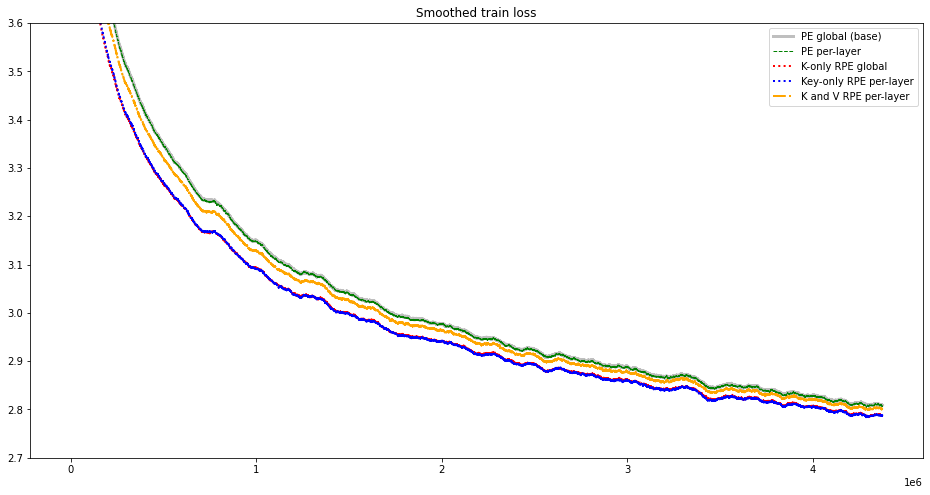

In [300]:
plt.figure(figsize=(16, 8))
window = 1000
plot_loss(loss_histories[key_base]['train_loss'],
          smooth_window=window,
          color='gray',
          linewidth=3,
          alpha=.5)
plot_loss(loss_histories['pe_perlayer_n8_h8_d512_c64']['train_loss'],
          smooth_window=window,
          color='green',
          linestyle='--',
          linewidth=1)
plot_loss(loss_histories['rpe_konly_global_n8_h8_d512_c64']['train_loss'],
          smooth_window=window,
          color='red',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_konly_perlayer_n8_h8_d512_c64']['train_loss'],
          smooth_window=window,
          color='blue',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_kv_perlayer_n8_h8_d512_c64']['train_loss'],
          smooth_window=window,
          color='orange',
          linestyle='-.',
          linewidth=2)
plt.title('Smoothed train loss')
plt.legend([
    'PE global (base)',
    'PE per-layer',
    'K-only RPE global',
    'Key-only RPE per-layer',
    'K and V RPE per-layer',
])
plt.ylim([2.7, 3.6])

(3.3, 4.0)

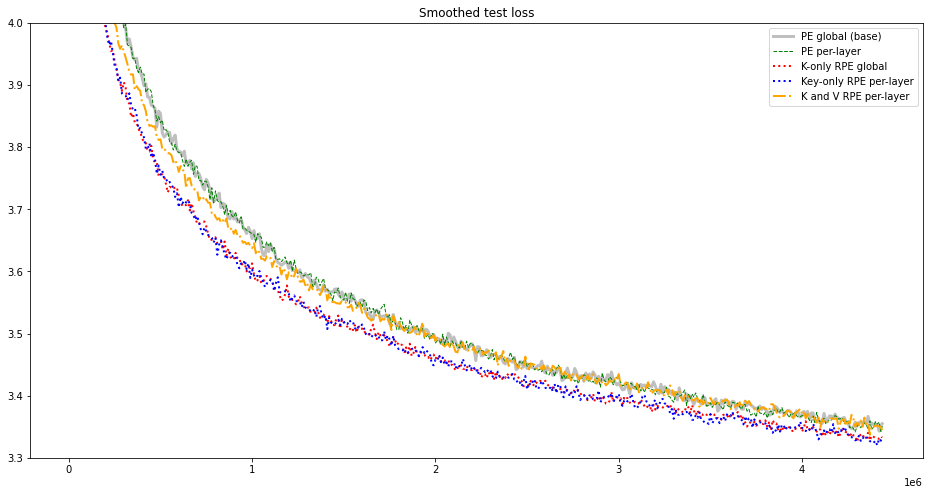

In [302]:
plt.figure(figsize=(16, 8))
plot_loss(loss_histories[key_base]['test_loss'],
          color='gray',
          linewidth=3,
          alpha=.5)
plot_loss(loss_histories['pe_perlayer_n8_h8_d512_c64']['test_loss'],
          color='green',
          linestyle='--',
          linewidth=1)
plot_loss(loss_histories['rpe_konly_global_n8_h8_d512_c64']['test_loss'],
          color='red',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_konly_perlayer_n8_h8_d512_c64']['test_loss'],
          color='blue',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_kv_perlayer_n8_h8_d512_c64']['test_loss'],
          color='orange',
          linestyle='-.',
          linewidth=2)
plt.title('Smoothed test loss')
plt.legend([
    'PE global (base)',
    'PE per-layer',
    'K-only RPE global',
    'Key-only RPE per-layer',
    'K and V RPE per-layer',
])
plt.ylim([3.3, 4])

Overall using relative positional embeddings (RPE) seems to be more optimal than absolute positional embeddings (PE), whether these embeddings are created per-layer or not. Interestingly there is no difference in per-layer vs. global key-only RPE, and key and value RPE seems to perform worse.

Note that these conclusions are from a very limited run (1 epoch) due to time and computational constraints.